# Analysis of the State Farm image data

This notebook provides analysis of the provided State Farm data, using Theano and Keras to build the NN.

### Prerequisites
Please see the Readme.md file for pre-requisite Python libraries

Note that the data is available from Kaggle here:  
https://www.kaggle.com/c/state-farm-distracted-driver-detection/data

Please extract the data set into the /imgs folder within this code.  For example ./state-farm/imgs/ 

If this is the 1st run after downloading the data, then please set create_repository to True below.


## Set up the environment
First, let's import what we need and set up environment variables, etc.

If the following commands error with the message "Exception: Can't change the value of this config parameter after initialization!" then please re-start ipython with the following command:

THEANO_FLAGS=device=gpu,floatX=float32 ipython notebook


In [1]:
import theano
theano.config.device = 'gpu'
theano.config.floatX = 'float32'

Exception: Can't change the value of this config parameter after initialization!

In [26]:
# Imports of the relevant libraries
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# These are the locations of the images provided by Kaggle
# Root Dir is needed for Python, but not for create lmdb shell script later... (we need it there too!)
image_root_dir = './imgs/'
train_image_source_dir = "./train/"
test_image_source_dir = "./test/"
driver_image_list = "./driver_imgs_list.csv"

# These are the locations of the images that we will work with 
# Note that as we're continually mix up training and validation drivers/images, 
# then we will store images in one directory and use code to determine whether to train or validate
train_images_dir = "./images/train/"
#validation_images_dir = "./images/validate/" 
test_images_dir = "./images/test/"

# Some more controls
# color type: 1 - grey, 3 - rgb
color_type = 1 
image_width = 224 
image_height = 224 

create_repository = False    # True forces pre-processing images, set to True for the first run

## Start by pre-processing the images
There are only 27 different drivers so in order to avoid overfitting, or testing using very similar data to training, we will split the data based on the driver into train and validation sets.

Initially though, let's get the list of drivers, see how many images are available for each driver, and which classification they have been labelled with.


In [3]:
# Training set is in the provided csv file
driver_list = pd.read_csv(driver_image_list)
print ("Training data summary: \n{}".format(driver_list.head()))

test_image_list = os.listdir(image_root_dir + test_image_source_dir)
print ("\nTesting data summary: \n{}".format(test_image_list[0:9]))

Training data summary: 
  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

Testing data summary: 
['img_60161.jpg', 'img_94786.jpg', 'img_85853.jpg', 'img_36327.jpg', 'img_39014.jpg', 'img_84595.jpg', 'img_57915.jpg', 'img_37039.jpg', 'img_11940.jpg']


Process images so that they are in an format more suited to training and testing

In [4]:
def get_driver_images_and_classes(driver_list):
    image_list = []
    class_list = []
    total = 0
    for driver_row in [ drvr for drvr in driver_list.iterrows() ]:   # if drvr[1]['subject'] in filter 
        driver = driver_row[1]  # Drop the index created by the Pandas Dataframe
        driver_class = int(driver['classname'][1:])  # Get integer to represent class (eg 'c0' is class '0')
        image_list.append(driver['img'])
        class_list.append(driver_class)
        total += 1
    print (image_list[2000])
    print ("Total number of training images found {}".format(total))
    #Return a list of images and their classification
    return np.array(image_list), np.array(class_list)

# Create a training list of images and classes from the training set
images, classes = get_driver_images_and_classes(driver_list)

img_29411.jpg
Total number of training images found 22424


In [10]:
import cv2

# Process the image, for now this is resize only
# We'll handle colour/greyscale when we load as cv2 does this for us
# TODO - Move directory creation to Python code to be OS independent

def pre_process_image(image):
    processed_img = cv2.resize(image, (image_width, image_height)) 
    return processed_img
    
def create_train_image_repository(images_dest_dir, images_list, class_list, color_type=1):
    print ("create_image_repository(): Processing images into {}".format(images_dest_dir))
    copied = 0 
    for f, c in zip(images_list, class_list):
        dest_dir = images_dest_dir + str(c) + "/"
        if os.path.exists(dest_dir) == False:
            !mkdir $dest_dir
        image_filename = image_root_dir + train_image_source_dir + '/c' + str(c) + '/' + f
        
        if color_type == 1:
            orig_img = cv2.imread(image_filename, 0)
            #print(orig_img)
        elif color_type == 3:
            orig_img = cv2.imread(image_filename)
        processed_image = pre_process_image(orig_img)
        cv2.imwrite(images_dest_dir + str(c) + "/" + f, processed_image)
        copied += 1
        if copied % 100 == 0:
            print ("."),
    print ("\nCopied {} images...Done!".format(copied))
    return copied

def create_test_image_repository(dest_dir, images_list, color_type=1):
    print ("create_image_repository(): Processing images into {}".format(dest_dir))
    copied = 0 
    for f in images_list:
        if os.path.exists(dest_dir) == False:
            !mkdir $dest_dir
        image_filename = image_root_dir + test_image_source_dir + f
        #print(image_filename)
        if color_type == 1:
            orig_img = cv2.imread(image_filename, 0)
        elif color_type == 3:
            orig_img = cv2.imread(image_filename)
        print (orig_img)
        processed_image = pre_process_image(orig_img)
        cv2.imwrite(dest_dir + f, processed_image)
        copied += 1
        if copied % 100 == 0:
            print ("."),
    print ("\nCopied {} images...Done!".format(copied))
    return copied

## Pre-process images if required

In [11]:
# Start by clearing out any old data (ignore failures here if the directory doesn't exist)
# TODO - Move to Python code to be OS independent

if create_repository:
    print ("Deleting old repositories if they exist, this may take a while...")
    !rm -rf $train_images_dir
    #!rm -rf $validation_images_dir
    !rm -rf $test_images_dir

    # Create directories
    !mkdir -p $train_images_dir
    #!mkdir -p $validation_images_dir
    !mkdir -p $test_images_dir

    create_test_image_repository(test_images_dir, test_image_list, color_type=color_type)
    create_train_image_repository(train_images_dir, images, classes, color_type=color_type)

In [12]:
# Currently unused
def render_image(image_filename):
    print ("render_image(): Rendering {}".format(image_filename))
    image = cv2.imread(image_filename, color_type_global)
    plt.axis("off")
    #plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.imshow(image)
    plt.show() 
    #print image.shape
    #plt.imshow(image)

## Create train, validation and test data sets

Seperate the drivers into a training and validation set.  To ensure we don't have overfitting (the training set and the validation set contain the same or similar images) we will split on drivers, so a driver can only appear in training or validation but not both.


In [13]:
driver_ids = []
for id, driver in driver_list.iterrows():
    if driver['subject'] not in driver_ids:
        driver_ids.append(driver['subject'])
print ("Found {} drivers: {}".format(len(driver_ids), driver_ids))

Found 26 drivers: ['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']


Split into train and validation data tests (split = percentage to have in training set)
and then create X_train, y_train, X_valid, y_valid

In [19]:
from keras.utils import np_utils

def create_train_validation_data(driver_list, filter):
    #sample = driver_list[driver_list.subject.isin(filter)].ix[:, 'classname':'img']
    images = []
    labels = []
    total = 0
    print (driver_list)
    for driver_row in [ drvr for drvr in driver_list[driver_list.subject.isin(filter)].ix[:, 'classname':'img'].iterrows() ]:   # if drvr[1]['subject'] in filter 
        driver = driver_row[1]  # Drop the index created by the Pandas Dataframe
        print (driver)
        label = int(driver['classname'][1:])
        filename = train_images_dir + str(label) + "/" + driver['img']
        print(filename)
        if color_type == 1:
            #image = cv2.imread(filename, 0).transpose()  # Is the color_type needed here as these are pre-processed images??
            image = cv2.transpose(cv2.imread(filename, 0))  # Is the color_type needed here as these are pre-processed images??
            #print(cv2.imread(filename, 0).shape())
        elif color_type == 3:
            #image = cv2.imread(filename).transpose()     # Is the color_type needed here as these are pre-processed images??
            image = cv2.transpose(cv2.imread(filename))    # Is the color_type needed here as these are pre-processed images??
            
        images.append(image)
        
        labels.append(label)
        total += 1
        if total % 100 == 0:
            print ("."),
    print ("\nProcessed {} rows.".format(total))
    
    images = np.array(images, dtype=np.uint8)
    images = images.reshape(images.shape[0], color_type, image_width, image_height)
    images = images.astype('float32')
    images /= 255
    
    labels = np.array(labels, dtype=np.uint8)
    labels = np_utils.to_categorical(labels, 10)

    return images, labels

In [20]:
def split_drivers_into_train_and_validate(driver_list, split = 1.0):
    driver_valid_list = []
    # Take a random sample of drivers into the training list
    driver_train_list = np.random.choice(driver_list, int(len(driver_list)*split), replace = False)
    # Take the remaining drivers into the validation list
    driver_valid_list = [ driver for driver in driver_list if driver not in driver_train_list]
    return driver_train_list, driver_valid_list

In [21]:
training_list, validation_list = split_drivers_into_train_and_validate(driver_ids, split = 0.95)
print (training_list)
print (validation_list)

['p049' 'p061' 'p041' 'p081' 'p047' 'p016' 'p064' 'p015' 'p014' 'p066'
 'p035' 'p039' 'p026' 'p056' 'p021' 'p022' 'p052' 'p012' 'p075' 'p042'
 'p051' 'p024' 'p002' 'p050']
['p045', 'p072']


In [23]:
print ("Creating training/validation data:")
X_train, y_train = create_train_validation_data(driver_list, training_list)
print ("Creating validation data:")
X_valid, y_valid = create_train_validation_data(driver_list, validation_list)

Creating training/validation data:
      subject classname            img
0        p002        c0  img_44733.jpg
1        p002        c0  img_72999.jpg
2        p002        c0  img_25094.jpg
3        p002        c0  img_69092.jpg
4        p002        c0  img_92629.jpg
5        p002        c0   img_3370.jpg
6        p002        c0  img_67639.jpg
7        p002        c0  img_58560.jpg
8        p002        c0  img_35779.jpg
9        p002        c0  img_10012.jpg
10       p002        c0  img_70354.jpg
11       p002        c0  img_54617.jpg
12       p002        c0  img_26684.jpg
13       p002        c0  img_82409.jpg
14       p002        c0   img_5585.jpg
15       p002        c0  img_19029.jpg
16       p002        c0  img_40930.jpg
17       p002        c0  img_31547.jpg
18       p002        c0  img_87373.jpg
19       p002        c0  img_10627.jpg
20       p002        c0  img_66355.jpg
21       p002        c0  img_97714.jpg
22       p002        c0  img_37344.jpg
23       p002        c0  img_

/Users/ounei/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


classname               c0
img          img_44733.jpg
Name: 0, dtype: object
./images/train/0/img_44733.jpg
classname               c0
img          img_72999.jpg
Name: 1, dtype: object
./images/train/0/img_72999.jpg
classname               c0
img          img_25094.jpg
Name: 2, dtype: object
./images/train/0/img_25094.jpg
classname               c0
img          img_69092.jpg
Name: 3, dtype: object
./images/train/0/img_69092.jpg
classname               c0
img          img_92629.jpg
Name: 4, dtype: object
./images/train/0/img_92629.jpg
classname              c0
img          img_3370.jpg
Name: 5, dtype: object
./images/train/0/img_3370.jpg
classname               c0
img          img_67639.jpg
Name: 6, dtype: object
./images/train/0/img_67639.jpg
classname               c0
img          img_58560.jpg
Name: 7, dtype: object
./images/train/0/img_58560.jpg
classname               c0
img          img_35779.jpg
Name: 8, dtype: object
./images/train/0/img_35779.jpg
classname               c0
img 

classname               c1
img          img_50388.jpg
Name: 114, dtype: object
./images/train/1/img_50388.jpg
classname               c1
img          img_20320.jpg
Name: 115, dtype: object
./images/train/1/img_20320.jpg
classname              c1
img          img_5877.jpg
Name: 116, dtype: object
./images/train/1/img_5877.jpg
classname               c1
img          img_85210.jpg
Name: 117, dtype: object
./images/train/1/img_85210.jpg
classname               c1
img          img_52037.jpg
Name: 118, dtype: object
./images/train/1/img_52037.jpg
classname               c1
img          img_25477.jpg
Name: 119, dtype: object
./images/train/1/img_25477.jpg
classname               c1
img          img_37212.jpg
Name: 120, dtype: object
./images/train/1/img_37212.jpg
classname               c1
img          img_49167.jpg
Name: 121, dtype: object
./images/train/1/img_49167.jpg
classname               c1
img          img_35243.jpg
Name: 122, dtype: object
./images/train/1/img_35243.jpg
classname    

classname               c2
img          img_56031.jpg
Name: 223, dtype: object
./images/train/2/img_56031.jpg
classname               c2
img          img_91424.jpg
Name: 224, dtype: object
./images/train/2/img_91424.jpg
classname               c2
img          img_23781.jpg
Name: 225, dtype: object
./images/train/2/img_23781.jpg
classname               c2
img          img_37594.jpg
Name: 226, dtype: object
./images/train/2/img_37594.jpg
classname              c2
img          img_5410.jpg
Name: 227, dtype: object
./images/train/2/img_5410.jpg
classname              c2
img          img_9986.jpg
Name: 228, dtype: object
./images/train/2/img_9986.jpg
classname               c2
img          img_95044.jpg
Name: 229, dtype: object
./images/train/2/img_95044.jpg
classname               c2
img          img_89388.jpg
Name: 230, dtype: object
./images/train/2/img_89388.jpg
classname               c2
img          img_41336.jpg
Name: 231, dtype: object
./images/train/2/img_41336.jpg
classname       

classname                c4
img          img_101528.jpg
Name: 348, dtype: object
./images/train/4/img_101528.jpg
classname               c4
img          img_84187.jpg
Name: 349, dtype: object
./images/train/4/img_84187.jpg
classname               c4
img          img_43696.jpg
Name: 350, dtype: object
./images/train/4/img_43696.jpg
classname               c4
img          img_37441.jpg
Name: 351, dtype: object
./images/train/4/img_37441.jpg
classname               c4
img          img_50372.jpg
Name: 352, dtype: object
./images/train/4/img_50372.jpg
classname               c4
img          img_37643.jpg
Name: 353, dtype: object
./images/train/4/img_37643.jpg
classname             c4
img          img_858.jpg
Name: 354, dtype: object
./images/train/4/img_858.jpg
classname               c4
img          img_75950.jpg
Name: 355, dtype: object
./images/train/4/img_75950.jpg
classname               c4
img          img_31005.jpg
Name: 356, dtype: object
./images/train/4/img_31005.jpg
classname    

classname               c5
img          img_43370.jpg
Name: 470, dtype: object
./images/train/5/img_43370.jpg
classname               c5
img          img_55047.jpg
Name: 471, dtype: object
./images/train/5/img_55047.jpg
classname               c5
img          img_40645.jpg
Name: 472, dtype: object
./images/train/5/img_40645.jpg
classname               c5
img          img_15127.jpg
Name: 473, dtype: object
./images/train/5/img_15127.jpg
classname               c5
img          img_87951.jpg
Name: 474, dtype: object
./images/train/5/img_87951.jpg
classname               c6
img          img_45361.jpg
Name: 475, dtype: object
./images/train/6/img_45361.jpg
classname               c6
img          img_43580.jpg
Name: 476, dtype: object
./images/train/6/img_43580.jpg
classname               c6
img          img_90192.jpg
Name: 477, dtype: object
./images/train/6/img_90192.jpg
classname               c6
img          img_82510.jpg
Name: 478, dtype: object
./images/train/6/img_82510.jpg
classname 

classname               c7
img          img_42302.jpg
Name: 572, dtype: object
./images/train/7/img_42302.jpg
classname               c7
img          img_43930.jpg
Name: 573, dtype: object
./images/train/7/img_43930.jpg
classname               c7
img          img_87435.jpg
Name: 574, dtype: object
./images/train/7/img_87435.jpg
classname              c7
img          img_8817.jpg
Name: 575, dtype: object
./images/train/7/img_8817.jpg
classname               c7
img          img_91196.jpg
Name: 576, dtype: object
./images/train/7/img_91196.jpg
classname               c7
img          img_46523.jpg
Name: 577, dtype: object
./images/train/7/img_46523.jpg
classname               c7
img          img_31543.jpg
Name: 578, dtype: object
./images/train/7/img_31543.jpg
classname              c7
img          img_7907.jpg
Name: 579, dtype: object
./images/train/7/img_7907.jpg
classname               c7
img          img_16411.jpg
Name: 580, dtype: object
./images/train/7/img_16411.jpg
classname       

classname               c9
img          img_58919.jpg
Name: 694, dtype: object
./images/train/9/img_58919.jpg
classname               c9
img          img_37205.jpg
Name: 695, dtype: object
./images/train/9/img_37205.jpg
classname               c9
img          img_50897.jpg
Name: 696, dtype: object
./images/train/9/img_50897.jpg
classname               c9
img          img_45690.jpg
Name: 697, dtype: object
./images/train/9/img_45690.jpg
classname             c9
img          img_993.jpg
Name: 698, dtype: object
./images/train/9/img_993.jpg
classname               c9
img          img_77780.jpg
Name: 699, dtype: object
./images/train/9/img_77780.jpg
.
classname               c9
img          img_56129.jpg
Name: 700, dtype: object
./images/train/9/img_56129.jpg
classname               c9
img          img_40697.jpg
Name: 701, dtype: object
./images/train/9/img_40697.jpg
classname               c9
img          img_29490.jpg
Name: 702, dtype: object
./images/train/9/img_29490.jpg
classname     

classname               c0
img          img_37234.jpg
Name: 808, dtype: object
./images/train/0/img_37234.jpg
classname               c1
img          img_45632.jpg
Name: 809, dtype: object
./images/train/1/img_45632.jpg
classname               c1
img          img_26825.jpg
Name: 810, dtype: object
./images/train/1/img_26825.jpg
classname               c1
img          img_94183.jpg
Name: 811, dtype: object
./images/train/1/img_94183.jpg
classname               c1
img          img_19014.jpg
Name: 812, dtype: object
./images/train/1/img_19014.jpg
classname               c1
img          img_64769.jpg
Name: 813, dtype: object
./images/train/1/img_64769.jpg
classname               c1
img          img_27582.jpg
Name: 814, dtype: object
./images/train/1/img_27582.jpg
classname               c1
img          img_65051.jpg
Name: 815, dtype: object
./images/train/1/img_65051.jpg
classname               c1
img          img_41920.jpg
Name: 816, dtype: object
./images/train/1/img_41920.jpg
classname 

classname               c2
img          img_20837.jpg
Name: 910, dtype: object
./images/train/2/img_20837.jpg
classname               c2
img          img_68142.jpg
Name: 911, dtype: object
./images/train/2/img_68142.jpg
classname              c2
img          img_8535.jpg
Name: 912, dtype: object
./images/train/2/img_8535.jpg
classname               c2
img          img_61039.jpg
Name: 913, dtype: object
./images/train/2/img_61039.jpg
classname               c2
img          img_99218.jpg
Name: 914, dtype: object
./images/train/2/img_99218.jpg
classname               c2
img          img_13514.jpg
Name: 915, dtype: object
./images/train/2/img_13514.jpg
classname               c2
img          img_43342.jpg
Name: 916, dtype: object
./images/train/2/img_43342.jpg
classname               c2
img          img_36123.jpg
Name: 917, dtype: object
./images/train/2/img_36123.jpg
classname               c2
img          img_85485.jpg
Name: 918, dtype: object
./images/train/2/img_85485.jpg
classname    

classname               c3
img          img_40181.jpg
Name: 1031, dtype: object
./images/train/3/img_40181.jpg
classname               c3
img          img_35790.jpg
Name: 1032, dtype: object
./images/train/3/img_35790.jpg
classname              c3
img          img_3317.jpg
Name: 1033, dtype: object
./images/train/3/img_3317.jpg
classname               c3
img          img_73623.jpg
Name: 1034, dtype: object
./images/train/3/img_73623.jpg
classname               c3
img          img_71525.jpg
Name: 1035, dtype: object
./images/train/3/img_71525.jpg
classname               c3
img          img_14358.jpg
Name: 1036, dtype: object
./images/train/3/img_14358.jpg
classname               c3
img          img_56777.jpg
Name: 1037, dtype: object
./images/train/3/img_56777.jpg
classname               c3
img          img_15926.jpg
Name: 1038, dtype: object
./images/train/3/img_15926.jpg
classname               c3
img          img_17511.jpg
Name: 1039, dtype: object
./images/train/3/img_17511.jpg
clas

classname               c4
img          img_61037.jpg
Name: 1149, dtype: object
./images/train/4/img_61037.jpg
classname               c4
img          img_22219.jpg
Name: 1150, dtype: object
./images/train/4/img_22219.jpg
classname               c4
img          img_12729.jpg
Name: 1151, dtype: object
./images/train/4/img_12729.jpg
classname               c4
img          img_37670.jpg
Name: 1152, dtype: object
./images/train/4/img_37670.jpg
classname               c4
img          img_43975.jpg
Name: 1153, dtype: object
./images/train/4/img_43975.jpg
classname               c4
img          img_63260.jpg
Name: 1154, dtype: object
./images/train/4/img_63260.jpg
classname               c4
img          img_14643.jpg
Name: 1155, dtype: object
./images/train/4/img_14643.jpg
classname               c4
img          img_27831.jpg
Name: 1156, dtype: object
./images/train/4/img_27831.jpg
classname               c4
img          img_69524.jpg
Name: 1157, dtype: object
./images/train/4/img_69524.jpg
c

classname               c5
img          img_69519.jpg
Name: 1270, dtype: object
./images/train/5/img_69519.jpg
classname               c5
img          img_79555.jpg
Name: 1271, dtype: object
./images/train/5/img_79555.jpg
classname               c5
img          img_88607.jpg
Name: 1272, dtype: object
./images/train/5/img_88607.jpg
classname               c5
img          img_81638.jpg
Name: 1273, dtype: object
./images/train/5/img_81638.jpg
classname               c5
img          img_53938.jpg
Name: 1274, dtype: object
./images/train/5/img_53938.jpg
classname               c5
img          img_21382.jpg
Name: 1275, dtype: object
./images/train/5/img_21382.jpg
classname               c5
img          img_56799.jpg
Name: 1276, dtype: object
./images/train/5/img_56799.jpg
classname               c6
img          img_55547.jpg
Name: 1277, dtype: object
./images/train/6/img_55547.jpg
classname               c6
img          img_82468.jpg
Name: 1278, dtype: object
./images/train/6/img_82468.jpg
c

classname               c7
img          img_54386.jpg
Name: 1392, dtype: object
./images/train/7/img_54386.jpg
classname             c7
img          img_845.jpg
Name: 1393, dtype: object
./images/train/7/img_845.jpg
classname               c7
img          img_36913.jpg
Name: 1394, dtype: object
./images/train/7/img_36913.jpg
classname                c7
img          img_101759.jpg
Name: 1395, dtype: object
./images/train/7/img_101759.jpg
classname               c7
img          img_83798.jpg
Name: 1396, dtype: object
./images/train/7/img_83798.jpg
classname               c7
img          img_85922.jpg
Name: 1397, dtype: object
./images/train/7/img_85922.jpg
classname               c7
img          img_31783.jpg
Name: 1398, dtype: object
./images/train/7/img_31783.jpg
classname               c7
img          img_78903.jpg
Name: 1399, dtype: object
./images/train/7/img_78903.jpg
.
classname               c7
img          img_48156.jpg
Name: 1400, dtype: object
./images/train/7/img_48156.jpg
cl

classname               c9
img          img_19854.jpg
Name: 1515, dtype: object
./images/train/9/img_19854.jpg
classname               c9
img          img_99569.jpg
Name: 1516, dtype: object
./images/train/9/img_99569.jpg
classname               c9
img          img_24302.jpg
Name: 1517, dtype: object
./images/train/9/img_24302.jpg
classname               c9
img          img_51689.jpg
Name: 1518, dtype: object
./images/train/9/img_51689.jpg
classname               c9
img          img_23612.jpg
Name: 1519, dtype: object
./images/train/9/img_23612.jpg
classname              c9
img          img_2723.jpg
Name: 1520, dtype: object
./images/train/9/img_2723.jpg
classname               c9
img          img_89399.jpg
Name: 1521, dtype: object
./images/train/9/img_89399.jpg
classname               c9
img          img_77820.jpg
Name: 1522, dtype: object
./images/train/9/img_77820.jpg
classname               c9
img          img_20392.jpg
Name: 1523, dtype: object
./images/train/9/img_20392.jpg
clas

classname               c0
img          img_17359.jpg
Name: 1608, dtype: object
./images/train/0/img_17359.jpg
classname              c0
img          img_1005.jpg
Name: 1609, dtype: object
./images/train/0/img_1005.jpg
classname               c0
img          img_41017.jpg
Name: 1610, dtype: object
./images/train/0/img_41017.jpg
classname               c0
img          img_23996.jpg
Name: 1611, dtype: object
./images/train/0/img_23996.jpg
classname               c0
img          img_55791.jpg
Name: 1612, dtype: object
./images/train/0/img_55791.jpg
classname               c0
img          img_95735.jpg
Name: 1613, dtype: object
./images/train/0/img_95735.jpg
classname               c0
img          img_67027.jpg
Name: 1614, dtype: object
./images/train/0/img_67027.jpg
classname               c0
img          img_95086.jpg
Name: 1615, dtype: object
./images/train/0/img_95086.jpg
classname               c0
img          img_89168.jpg
Name: 1616, dtype: object
./images/train/0/img_89168.jpg
clas

./images/train/1/img_41670.jpg
classname               c1
img          img_43955.jpg
Name: 1707, dtype: object
./images/train/1/img_43955.jpg
classname              c1
img          img_7322.jpg
Name: 1708, dtype: object
./images/train/1/img_7322.jpg
classname               c1
img          img_18964.jpg
Name: 1709, dtype: object
./images/train/1/img_18964.jpg
classname               c1
img          img_76678.jpg
Name: 1710, dtype: object
./images/train/1/img_76678.jpg
classname               c1
img          img_75152.jpg
Name: 1711, dtype: object
./images/train/1/img_75152.jpg
classname               c1
img          img_41780.jpg
Name: 1712, dtype: object
./images/train/1/img_41780.jpg
classname               c1
img          img_35598.jpg
Name: 1713, dtype: object
./images/train/1/img_35598.jpg
classname              c1
img          img_1830.jpg
Name: 1714, dtype: object
./images/train/1/img_1830.jpg
classname               c1
img          img_50710.jpg
Name: 1715, dtype: object
./image

classname              c2
img          img_1504.jpg
Name: 1807, dtype: object
./images/train/2/img_1504.jpg
classname               c2
img          img_18144.jpg
Name: 1808, dtype: object
./images/train/2/img_18144.jpg
classname               c2
img          img_69900.jpg
Name: 1809, dtype: object
./images/train/2/img_69900.jpg
classname               c2
img          img_24240.jpg
Name: 1810, dtype: object
./images/train/2/img_24240.jpg
classname               c2
img          img_39826.jpg
Name: 1811, dtype: object
./images/train/2/img_39826.jpg
classname               c2
img          img_48228.jpg
Name: 1812, dtype: object
./images/train/2/img_48228.jpg
classname               c2
img          img_45228.jpg
Name: 1813, dtype: object
./images/train/2/img_45228.jpg
classname               c2
img          img_39809.jpg
Name: 1814, dtype: object
./images/train/2/img_39809.jpg
classname               c2
img          img_19360.jpg
Name: 1815, dtype: object
./images/train/2/img_19360.jpg
clas

classname               c3
img          img_81138.jpg
Name: 1917, dtype: object
./images/train/3/img_81138.jpg
classname               c3
img          img_89740.jpg
Name: 1918, dtype: object
./images/train/3/img_89740.jpg
classname               c3
img          img_36150.jpg
Name: 1919, dtype: object
./images/train/3/img_36150.jpg
classname              c3
img          img_4087.jpg
Name: 1920, dtype: object
./images/train/3/img_4087.jpg
classname             c3
img          img_216.jpg
Name: 1921, dtype: object
./images/train/3/img_216.jpg
classname               c3
img          img_99727.jpg
Name: 1922, dtype: object
./images/train/3/img_99727.jpg
classname               c3
img          img_84682.jpg
Name: 1923, dtype: object
./images/train/3/img_84682.jpg
classname               c3
img          img_96851.jpg
Name: 1924, dtype: object
./images/train/3/img_96851.jpg
classname               c3
img          img_13211.jpg
Name: 1925, dtype: object
./images/train/3/img_13211.jpg
classname 

classname               c4
img          img_16500.jpg
Name: 2008, dtype: object
./images/train/4/img_16500.jpg
classname               c4
img          img_62412.jpg
Name: 2009, dtype: object
./images/train/4/img_62412.jpg
classname               c4
img          img_55675.jpg
Name: 2010, dtype: object
./images/train/4/img_55675.jpg
classname               c4
img          img_63308.jpg
Name: 2011, dtype: object
./images/train/4/img_63308.jpg
classname                c4
img          img_101920.jpg
Name: 2012, dtype: object
./images/train/4/img_101920.jpg
classname               c4
img          img_99540.jpg
Name: 2013, dtype: object
./images/train/4/img_99540.jpg
classname               c4
img          img_25361.jpg
Name: 2014, dtype: object
./images/train/4/img_25361.jpg
classname               c4
img          img_60902.jpg
Name: 2015, dtype: object
./images/train/4/img_60902.jpg
classname               c4
img          img_42954.jpg
Name: 2016, dtype: object
./images/train/4/img_42954.jp

classname               c5
img          img_52213.jpg
Name: 2082, dtype: object
./images/train/5/img_52213.jpg
classname               c5
img          img_28973.jpg
Name: 2083, dtype: object
./images/train/5/img_28973.jpg
classname               c5
img          img_95711.jpg
Name: 2084, dtype: object
./images/train/5/img_95711.jpg
classname               c5
img          img_19934.jpg
Name: 2085, dtype: object
./images/train/5/img_19934.jpg
classname              c5
img          img_4344.jpg
Name: 2086, dtype: object
./images/train/5/img_4344.jpg
classname               c5
img          img_16491.jpg
Name: 2087, dtype: object
./images/train/5/img_16491.jpg
classname               c5
img          img_77895.jpg
Name: 2088, dtype: object
./images/train/5/img_77895.jpg
classname               c5
img          img_65653.jpg
Name: 2089, dtype: object
./images/train/5/img_65653.jpg
classname               c5
img          img_81929.jpg
Name: 2090, dtype: object
./images/train/5/img_81929.jpg
clas

classname               c6
img          img_76554.jpg
Name: 2185, dtype: object
./images/train/6/img_76554.jpg
classname               c6
img          img_39861.jpg
Name: 2186, dtype: object
./images/train/6/img_39861.jpg
classname               c6
img          img_30542.jpg
Name: 2187, dtype: object
./images/train/6/img_30542.jpg
classname               c6
img          img_90051.jpg
Name: 2188, dtype: object
./images/train/6/img_90051.jpg
classname               c6
img          img_51832.jpg
Name: 2189, dtype: object
./images/train/6/img_51832.jpg
classname               c6
img          img_16740.jpg
Name: 2190, dtype: object
./images/train/6/img_16740.jpg
classname              c6
img          img_9842.jpg
Name: 2191, dtype: object
./images/train/6/img_9842.jpg
classname               c6
img          img_26988.jpg
Name: 2192, dtype: object
./images/train/6/img_26988.jpg
classname               c6
img          img_32516.jpg
Name: 2193, dtype: object
./images/train/6/img_32516.jpg
clas

classname               c7
img          img_39371.jpg
Name: 2292, dtype: object
./images/train/7/img_39371.jpg
classname               c7
img          img_75743.jpg
Name: 2293, dtype: object
./images/train/7/img_75743.jpg
classname               c7
img          img_58770.jpg
Name: 2294, dtype: object
./images/train/7/img_58770.jpg
classname             c7
img          img_629.jpg
Name: 2295, dtype: object
./images/train/7/img_629.jpg
classname              c7
img          img_8744.jpg
Name: 2296, dtype: object
./images/train/7/img_8744.jpg
classname               c7
img          img_41901.jpg
Name: 2297, dtype: object
./images/train/7/img_41901.jpg
classname               c7
img          img_18345.jpg
Name: 2298, dtype: object
./images/train/7/img_18345.jpg
classname               c7
img          img_28308.jpg
Name: 2299, dtype: object
./images/train/7/img_28308.jpg
.
classname               c7
img          img_34690.jpg
Name: 2300, dtype: object
./images/train/7/img_34690.jpg
classnam

classname               c8
img          img_36882.jpg
Name: 2368, dtype: object
./images/train/8/img_36882.jpg
classname               c8
img          img_84560.jpg
Name: 2369, dtype: object
./images/train/8/img_84560.jpg
classname               c8
img          img_12151.jpg
Name: 2370, dtype: object
./images/train/8/img_12151.jpg
classname               c8
img          img_39245.jpg
Name: 2371, dtype: object
./images/train/8/img_39245.jpg
classname               c9
img          img_58318.jpg
Name: 2372, dtype: object
./images/train/9/img_58318.jpg
classname               c9
img          img_54320.jpg
Name: 2373, dtype: object
./images/train/9/img_54320.jpg
classname               c9
img          img_73160.jpg
Name: 2374, dtype: object
./images/train/9/img_73160.jpg
classname               c9
img          img_17772.jpg
Name: 2375, dtype: object
./images/train/9/img_17772.jpg
classname               c9
img          img_11850.jpg
Name: 2376, dtype: object
./images/train/9/img_11850.jpg
c

classname               c0
img          img_27901.jpg
Name: 2470, dtype: object
./images/train/0/img_27901.jpg
classname               c0
img          img_51736.jpg
Name: 2471, dtype: object
./images/train/0/img_51736.jpg
classname              c0
img          img_1063.jpg
Name: 2472, dtype: object
./images/train/0/img_1063.jpg
classname               c0
img          img_86533.jpg
Name: 2473, dtype: object
./images/train/0/img_86533.jpg
classname               c0
img          img_79538.jpg
Name: 2474, dtype: object
./images/train/0/img_79538.jpg
classname               c0
img          img_88057.jpg
Name: 2475, dtype: object
./images/train/0/img_88057.jpg
classname               c0
img          img_73279.jpg
Name: 2476, dtype: object
./images/train/0/img_73279.jpg
classname              c0
img          img_4020.jpg
Name: 2477, dtype: object
./images/train/0/img_4020.jpg
classname               c0
img          img_19401.jpg
Name: 2478, dtype: object
./images/train/0/img_19401.jpg
classna

Name: 2577, dtype: object
./images/train/1/img_21184.jpg
classname               c1
img          img_78090.jpg
Name: 2578, dtype: object
./images/train/1/img_78090.jpg
classname               c1
img          img_87486.jpg
Name: 2579, dtype: object
./images/train/1/img_87486.jpg
classname               c1
img          img_74840.jpg
Name: 2580, dtype: object
./images/train/1/img_74840.jpg
classname               c1
img          img_80772.jpg
Name: 2581, dtype: object
./images/train/1/img_80772.jpg
classname               c1
img          img_17933.jpg
Name: 2582, dtype: object
./images/train/1/img_17933.jpg
classname               c1
img          img_89704.jpg
Name: 2583, dtype: object
./images/train/1/img_89704.jpg
classname               c1
img          img_15079.jpg
Name: 2584, dtype: object
./images/train/1/img_15079.jpg
classname               c1
img          img_56082.jpg
Name: 2585, dtype: object
./images/train/1/img_56082.jpg
classname              c1
img          img_7941.jpg
Nam

classname               c3
img          img_71831.jpg
Name: 2676, dtype: object
./images/train/3/img_71831.jpg
classname               c3
img          img_70705.jpg
Name: 2677, dtype: object
./images/train/3/img_70705.jpg
classname               c3
img          img_21510.jpg
Name: 2678, dtype: object
./images/train/3/img_21510.jpg
classname               c3
img          img_38684.jpg
Name: 2679, dtype: object
./images/train/3/img_38684.jpg
classname               c3
img          img_17291.jpg
Name: 2680, dtype: object
./images/train/3/img_17291.jpg
classname               c3
img          img_84716.jpg
Name: 2681, dtype: object
./images/train/3/img_84716.jpg
classname               c3
img          img_95266.jpg
Name: 2682, dtype: object
./images/train/3/img_95266.jpg
classname               c3
img          img_63556.jpg
Name: 2683, dtype: object
./images/train/3/img_63556.jpg
classname               c3
img          img_89871.jpg
Name: 2684, dtype: object
./images/train/3/img_89871.jpg
c

classname               c4
img          img_25501.jpg
Name: 2785, dtype: object
./images/train/4/img_25501.jpg
classname               c4
img          img_20169.jpg
Name: 2786, dtype: object
./images/train/4/img_20169.jpg
classname               c4
img          img_70764.jpg
Name: 2787, dtype: object
./images/train/4/img_70764.jpg
classname               c4
img          img_42776.jpg
Name: 2788, dtype: object
./images/train/4/img_42776.jpg
classname               c4
img          img_87639.jpg
Name: 2789, dtype: object
./images/train/4/img_87639.jpg
classname               c4
img          img_42719.jpg
Name: 2790, dtype: object
./images/train/4/img_42719.jpg
classname               c4
img          img_58155.jpg
Name: 2791, dtype: object
./images/train/4/img_58155.jpg
classname               c4
img          img_84158.jpg
Name: 2792, dtype: object
./images/train/4/img_84158.jpg
classname               c4
img          img_60279.jpg
Name: 2793, dtype: object
./images/train/4/img_60279.jpg
c

classname               c5
img          img_52293.jpg
Name: 2899, dtype: object
./images/train/5/img_52293.jpg
.
classname               c5
img          img_36211.jpg
Name: 2900, dtype: object
./images/train/5/img_36211.jpg
classname               c5
img          img_43449.jpg
Name: 2901, dtype: object
./images/train/5/img_43449.jpg
classname               c5
img          img_45933.jpg
Name: 2902, dtype: object
./images/train/5/img_45933.jpg
classname              c5
img          img_8763.jpg
Name: 2903, dtype: object
./images/train/5/img_8763.jpg
classname               c5
img          img_51205.jpg
Name: 2904, dtype: object
./images/train/5/img_51205.jpg
classname              c5
img          img_9234.jpg
Name: 2905, dtype: object
./images/train/5/img_9234.jpg
classname              c5
img          img_5584.jpg
Name: 2906, dtype: object
./images/train/5/img_5584.jpg
classname                c5
img          img_101030.jpg
Name: 2907, dtype: object
./images/train/5/img_101030.jpg
class

classname               c6
img          img_91643.jpg
Name: 3054, dtype: object
./images/train/6/img_91643.jpg
classname               c6
img          img_24156.jpg
Name: 3055, dtype: object
./images/train/6/img_24156.jpg
classname               c6
img          img_46553.jpg
Name: 3056, dtype: object
./images/train/6/img_46553.jpg
classname               c6
img          img_95524.jpg
Name: 3057, dtype: object
./images/train/6/img_95524.jpg
classname               c6
img          img_12019.jpg
Name: 3058, dtype: object
./images/train/6/img_12019.jpg
classname               c6
img          img_95963.jpg
Name: 3059, dtype: object
./images/train/6/img_95963.jpg
classname               c6
img          img_76493.jpg
Name: 3060, dtype: object
./images/train/6/img_76493.jpg
classname               c6
img          img_26875.jpg
Name: 3061, dtype: object
./images/train/6/img_26875.jpg
classname              c6
img          img_2974.jpg
Name: 3062, dtype: object
./images/train/6/img_2974.jpg
clas

classname               c7
img          img_93810.jpg
Name: 3142, dtype: object
./images/train/7/img_93810.jpg
classname               c7
img          img_18073.jpg
Name: 3143, dtype: object
./images/train/7/img_18073.jpg
classname               c7
img          img_76012.jpg
Name: 3144, dtype: object
./images/train/7/img_76012.jpg
classname               c7
img          img_76827.jpg
Name: 3145, dtype: object
./images/train/7/img_76827.jpg
classname               c7
img          img_67513.jpg
Name: 3146, dtype: object
./images/train/7/img_67513.jpg
classname               c7
img          img_27309.jpg
Name: 3147, dtype: object
./images/train/7/img_27309.jpg
classname               c7
img          img_38022.jpg
Name: 3148, dtype: object
./images/train/7/img_38022.jpg
classname               c7
img          img_30937.jpg
Name: 3149, dtype: object
./images/train/7/img_30937.jpg
classname              c7
img          img_4904.jpg
Name: 3150, dtype: object
./images/train/7/img_4904.jpg
clas

classname               c9
img          img_57067.jpg
Name: 3272, dtype: object
./images/train/9/img_57067.jpg
classname               c9
img          img_88054.jpg
Name: 3273, dtype: object
./images/train/9/img_88054.jpg
classname               c9
img          img_17562.jpg
Name: 3274, dtype: object
./images/train/9/img_17562.jpg
classname               c9
img          img_50127.jpg
Name: 3275, dtype: object
./images/train/9/img_50127.jpg
classname               c9
img          img_44951.jpg
Name: 3276, dtype: object
./images/train/9/img_44951.jpg
classname               c9
img          img_12651.jpg
Name: 3277, dtype: object
./images/train/9/img_12651.jpg
classname               c9
img          img_58066.jpg
Name: 3278, dtype: object
./images/train/9/img_58066.jpg
classname               c9
img          img_87554.jpg
Name: 3279, dtype: object
./images/train/9/img_87554.jpg
classname             c9
img          img_631.jpg
Name: 3280, dtype: object
./images/train/9/img_631.jpg
classna

classname               c0
img          img_69407.jpg
Name: 3377, dtype: object
./images/train/0/img_69407.jpg
classname               c0
img          img_45276.jpg
Name: 3378, dtype: object
./images/train/0/img_45276.jpg
classname               c0
img          img_63493.jpg
Name: 3379, dtype: object
./images/train/0/img_63493.jpg
classname               c0
img          img_65425.jpg
Name: 3380, dtype: object
./images/train/0/img_65425.jpg
classname               c0
img          img_68304.jpg
Name: 3381, dtype: object
./images/train/0/img_68304.jpg
classname               c0
img          img_19505.jpg
Name: 3382, dtype: object
./images/train/0/img_19505.jpg
classname               c0
img          img_95306.jpg
Name: 3383, dtype: object
./images/train/0/img_95306.jpg
classname               c0
img          img_29245.jpg
Name: 3384, dtype: object
./images/train/0/img_29245.jpg
classname               c0
img          img_80294.jpg
Name: 3385, dtype: object
./images/train/0/img_80294.jpg
c

classname               c1
img          img_84978.jpg
Name: 3480, dtype: object
./images/train/1/img_84978.jpg
classname               c1
img          img_97028.jpg
Name: 3481, dtype: object
./images/train/1/img_97028.jpg
classname               c1
img          img_58563.jpg
Name: 3482, dtype: object
./images/train/1/img_58563.jpg
classname               c1
img          img_64207.jpg
Name: 3483, dtype: object
./images/train/1/img_64207.jpg
classname               c1
img          img_82684.jpg
Name: 3484, dtype: object
./images/train/1/img_82684.jpg
classname               c1
img          img_71544.jpg
Name: 3485, dtype: object
./images/train/1/img_71544.jpg
classname             c1
img          img_557.jpg
Name: 3486, dtype: object
./images/train/1/img_557.jpg
classname               c1
img          img_68285.jpg
Name: 3487, dtype: object
./images/train/1/img_68285.jpg
classname               c1
img          img_37608.jpg
Name: 3488, dtype: object
./images/train/1/img_37608.jpg
classna

classname               c2
img          img_94253.jpg
Name: 3565, dtype: object
./images/train/2/img_94253.jpg
classname               c2
img          img_94677.jpg
Name: 3566, dtype: object
./images/train/2/img_94677.jpg
classname               c2
img          img_15916.jpg
Name: 3567, dtype: object
./images/train/2/img_15916.jpg
classname               c2
img          img_39052.jpg
Name: 3568, dtype: object
./images/train/2/img_39052.jpg
classname               c2
img          img_65501.jpg
Name: 3569, dtype: object
./images/train/2/img_65501.jpg
classname               c2
img          img_21235.jpg
Name: 3570, dtype: object
./images/train/2/img_21235.jpg
classname               c2
img          img_37999.jpg
Name: 3571, dtype: object
./images/train/2/img_37999.jpg
classname              c2
img          img_7491.jpg
Name: 3572, dtype: object
./images/train/2/img_7491.jpg
classname               c2
img          img_85095.jpg
Name: 3573, dtype: object
./images/train/2/img_85095.jpg
clas

classname              c3
img          img_4287.jpg
Name: 3662, dtype: object
./images/train/3/img_4287.jpg
classname               c3
img          img_87937.jpg
Name: 3663, dtype: object
./images/train/3/img_87937.jpg
classname               c3
img          img_24057.jpg
Name: 3664, dtype: object
./images/train/3/img_24057.jpg
classname               c3
img          img_98946.jpg
Name: 3665, dtype: object
./images/train/3/img_98946.jpg
classname               c3
img          img_82302.jpg
Name: 3666, dtype: object
./images/train/3/img_82302.jpg
classname               c3
img          img_93903.jpg
Name: 3667, dtype: object
./images/train/3/img_93903.jpg
classname               c3
img          img_63540.jpg
Name: 3668, dtype: object
./images/train/3/img_63540.jpg
classname               c3
img          img_88895.jpg
Name: 3669, dtype: object
./images/train/3/img_88895.jpg
classname               c3
img          img_17322.jpg
Name: 3670, dtype: object
./images/train/3/img_17322.jpg
clas

classname               c4
img          img_72446.jpg
Name: 3765, dtype: object
./images/train/4/img_72446.jpg
classname               c4
img          img_70122.jpg
Name: 3766, dtype: object
./images/train/4/img_70122.jpg
classname               c4
img          img_89727.jpg
Name: 3767, dtype: object
./images/train/4/img_89727.jpg
classname               c4
img          img_49492.jpg
Name: 3768, dtype: object
./images/train/4/img_49492.jpg
classname               c4
img          img_84202.jpg
Name: 3769, dtype: object
./images/train/4/img_84202.jpg
classname               c4
img          img_99811.jpg
Name: 3770, dtype: object
./images/train/4/img_99811.jpg
classname               c4
img          img_42600.jpg
Name: 3771, dtype: object
./images/train/4/img_42600.jpg
classname              c4
img          img_2589.jpg
Name: 3772, dtype: object
./images/train/4/img_2589.jpg
classname               c4
img          img_58147.jpg
Name: 3773, dtype: object
./images/train/4/img_58147.jpg
clas

classname               c5
img          img_94088.jpg
Name: 3859, dtype: object
./images/train/5/img_94088.jpg
classname               c5
img          img_67648.jpg
Name: 3860, dtype: object
./images/train/5/img_67648.jpg
classname               c5
img          img_97449.jpg
Name: 3861, dtype: object
./images/train/5/img_97449.jpg
classname               c5
img          img_51694.jpg
Name: 3862, dtype: object
./images/train/5/img_51694.jpg
classname                c5
img          img_100638.jpg
Name: 3863, dtype: object
./images/train/5/img_100638.jpg
classname               c5
img          img_53740.jpg
Name: 3864, dtype: object
./images/train/5/img_53740.jpg
classname               c5
img          img_87484.jpg
Name: 3865, dtype: object
./images/train/5/img_87484.jpg
classname               c5
img          img_89131.jpg
Name: 3866, dtype: object
./images/train/5/img_89131.jpg
classname               c5
img          img_38841.jpg
Name: 3867, dtype: object
./images/train/5/img_38841.jp

classname               c6
img          img_32208.jpg
Name: 3978, dtype: object
./images/train/6/img_32208.jpg
classname               c6
img          img_81036.jpg
Name: 3979, dtype: object
./images/train/6/img_81036.jpg
classname               c6
img          img_72572.jpg
Name: 3980, dtype: object
./images/train/6/img_72572.jpg
classname              c6
img          img_3037.jpg
Name: 3981, dtype: object
./images/train/6/img_3037.jpg
classname               c6
img          img_46198.jpg
Name: 3982, dtype: object
./images/train/6/img_46198.jpg
classname               c6
img          img_67206.jpg
Name: 3983, dtype: object
./images/train/6/img_67206.jpg
classname               c6
img          img_75598.jpg
Name: 3984, dtype: object
./images/train/6/img_75598.jpg
classname               c6
img          img_94078.jpg
Name: 3985, dtype: object
./images/train/6/img_94078.jpg
classname               c6
img          img_31439.jpg
Name: 3986, dtype: object
./images/train/6/img_31439.jpg
clas

classname               c7
img          img_47265.jpg
Name: 4078, dtype: object
./images/train/7/img_47265.jpg
classname               c7
img          img_19405.jpg
Name: 4079, dtype: object
./images/train/7/img_19405.jpg
classname               c7
img          img_48335.jpg
Name: 4080, dtype: object
./images/train/7/img_48335.jpg
classname               c7
img          img_29230.jpg
Name: 4081, dtype: object
./images/train/7/img_29230.jpg
classname               c7
img          img_72482.jpg
Name: 4082, dtype: object
./images/train/7/img_72482.jpg
classname               c7
img          img_34534.jpg
Name: 4083, dtype: object
./images/train/7/img_34534.jpg
classname               c7
img          img_98101.jpg
Name: 4084, dtype: object
./images/train/7/img_98101.jpg
classname               c7
img          img_33166.jpg
Name: 4085, dtype: object
./images/train/7/img_33166.jpg
classname               c7
img          img_85590.jpg
Name: 4086, dtype: object
./images/train/7/img_85590.jpg
c

classname               c8
img          img_67361.jpg
Name: 4185, dtype: object
./images/train/8/img_67361.jpg
classname               c8
img          img_10191.jpg
Name: 4186, dtype: object
./images/train/8/img_10191.jpg
classname               c8
img          img_68300.jpg
Name: 4187, dtype: object
./images/train/8/img_68300.jpg
classname               c8
img          img_23588.jpg
Name: 4188, dtype: object
./images/train/8/img_23588.jpg
classname               c8
img          img_28169.jpg
Name: 4189, dtype: object
./images/train/8/img_28169.jpg
classname               c8
img          img_54487.jpg
Name: 4190, dtype: object
./images/train/8/img_54487.jpg
classname               c8
img          img_54614.jpg
Name: 4191, dtype: object
./images/train/8/img_54614.jpg
classname               c8
img          img_31951.jpg
Name: 4192, dtype: object
./images/train/8/img_31951.jpg
classname               c8
img          img_50401.jpg
Name: 4193, dtype: object
./images/train/8/img_50401.jpg
c

classname               c9
img          img_85632.jpg
Name: 4289, dtype: object
./images/train/9/img_85632.jpg
classname               c9
img          img_23917.jpg
Name: 4290, dtype: object
./images/train/9/img_23917.jpg
classname               c9
img          img_21298.jpg
Name: 4291, dtype: object
./images/train/9/img_21298.jpg
classname               c9
img          img_77368.jpg
Name: 4292, dtype: object
./images/train/9/img_77368.jpg
classname               c9
img          img_33074.jpg
Name: 4293, dtype: object
./images/train/9/img_33074.jpg
classname               c9
img          img_16331.jpg
Name: 4294, dtype: object
./images/train/9/img_16331.jpg
classname               c9
img          img_46518.jpg
Name: 4295, dtype: object
./images/train/9/img_46518.jpg
classname               c9
img          img_51095.jpg
Name: 4296, dtype: object
./images/train/9/img_51095.jpg
classname               c9
img          img_71377.jpg
Name: 4297, dtype: object
./images/train/9/img_71377.jpg
c

classname               c9
img          img_22903.jpg
Name: 4373, dtype: object
./images/train/9/img_22903.jpg
classname               c9
img          img_39317.jpg
Name: 4374, dtype: object
./images/train/9/img_39317.jpg
classname               c9
img          img_59203.jpg
Name: 4375, dtype: object
./images/train/9/img_59203.jpg
classname               c9
img          img_77718.jpg
Name: 4376, dtype: object
./images/train/9/img_77718.jpg
classname               c0
img          img_58285.jpg
Name: 4377, dtype: object
./images/train/0/img_58285.jpg
classname               c0
img          img_31808.jpg
Name: 4378, dtype: object
./images/train/0/img_31808.jpg
classname               c0
img          img_34091.jpg
Name: 4379, dtype: object
./images/train/0/img_34091.jpg
classname               c0
img          img_17767.jpg
Name: 4380, dtype: object
./images/train/0/img_17767.jpg
classname              c0
img          img_2528.jpg
Name: 4381, dtype: object
./images/train/0/img_2528.jpg
clas

classname               c0
img          img_42143.jpg
Name: 4474, dtype: object
./images/train/0/img_42143.jpg
classname               c0
img          img_62053.jpg
Name: 4475, dtype: object
./images/train/0/img_62053.jpg
classname               c0
img          img_37626.jpg
Name: 4476, dtype: object
./images/train/0/img_37626.jpg
classname              c0
img          img_1256.jpg
Name: 4477, dtype: object
./images/train/0/img_1256.jpg
classname              c0
img          img_2334.jpg
Name: 4478, dtype: object
./images/train/0/img_2334.jpg
classname               c0
img          img_77890.jpg
Name: 4479, dtype: object
./images/train/0/img_77890.jpg
classname               c0
img          img_90464.jpg
Name: 4480, dtype: object
./images/train/0/img_90464.jpg
classname               c0
img          img_17862.jpg
Name: 4481, dtype: object
./images/train/0/img_17862.jpg
classname               c0
img          img_87330.jpg
Name: 4482, dtype: object
./images/train/0/img_87330.jpg
classna

classname              c1
img          img_4454.jpg
Name: 4585, dtype: object
./images/train/1/img_4454.jpg
classname               c1
img          img_85229.jpg
Name: 4586, dtype: object
./images/train/1/img_85229.jpg
classname               c1
img          img_26995.jpg
Name: 4587, dtype: object
./images/train/1/img_26995.jpg
classname               c1
img          img_55309.jpg
Name: 4588, dtype: object
./images/train/1/img_55309.jpg
classname                c1
img          img_100776.jpg
Name: 4589, dtype: object
./images/train/1/img_100776.jpg
classname               c1
img          img_75493.jpg
Name: 4590, dtype: object
./images/train/1/img_75493.jpg
classname               c1
img          img_13543.jpg
Name: 4591, dtype: object
./images/train/1/img_13543.jpg
classname               c1
img          img_77000.jpg
Name: 4592, dtype: object
./images/train/1/img_77000.jpg
classname              c1
img          img_9726.jpg
Name: 4593, dtype: object
./images/train/1/img_9726.jpg
clas

classname               c2
img          img_83377.jpg
Name: 4698, dtype: object
./images/train/2/img_83377.jpg
classname               c2
img          img_23015.jpg
Name: 4699, dtype: object
./images/train/2/img_23015.jpg
.
classname               c2
img          img_27895.jpg
Name: 4700, dtype: object
./images/train/2/img_27895.jpg
classname               c2
img          img_69051.jpg
Name: 4701, dtype: object
./images/train/2/img_69051.jpg
classname               c2
img          img_49866.jpg
Name: 4702, dtype: object
./images/train/2/img_49866.jpg
classname               c2
img          img_52919.jpg
Name: 4703, dtype: object
./images/train/2/img_52919.jpg
classname               c2
img          img_57587.jpg
Name: 4704, dtype: object
./images/train/2/img_57587.jpg
classname               c2
img          img_19043.jpg
Name: 4705, dtype: object
./images/train/2/img_19043.jpg
classname               c2
img          img_76744.jpg
Name: 4706, dtype: object
./images/train/2/img_76744.jpg

classname               c3
img          img_12248.jpg
Name: 4817, dtype: object
./images/train/3/img_12248.jpg
classname              c3
img          img_2115.jpg
Name: 4818, dtype: object
./images/train/3/img_2115.jpg
classname               c3
img          img_22676.jpg
Name: 4819, dtype: object
./images/train/3/img_22676.jpg
classname               c3
img          img_65301.jpg
Name: 4820, dtype: object
./images/train/3/img_65301.jpg
classname               c3
img          img_42123.jpg
Name: 4821, dtype: object
./images/train/3/img_42123.jpg
classname                c3
img          img_101014.jpg
Name: 4822, dtype: object
./images/train/3/img_101014.jpg
classname               c3
img          img_13240.jpg
Name: 4823, dtype: object
./images/train/3/img_13240.jpg
classname               c3
img          img_72989.jpg
Name: 4824, dtype: object
./images/train/3/img_72989.jpg
classname               c3
img          img_50402.jpg
Name: 4825, dtype: object
./images/train/3/img_50402.jpg
c

classname               c4
img          img_48472.jpg
Name: 4937, dtype: object
./images/train/4/img_48472.jpg
classname               c4
img          img_15184.jpg
Name: 4938, dtype: object
./images/train/4/img_15184.jpg
classname               c4
img          img_69473.jpg
Name: 4939, dtype: object
./images/train/4/img_69473.jpg
classname               c4
img          img_15721.jpg
Name: 4940, dtype: object
./images/train/4/img_15721.jpg
classname               c4
img          img_98481.jpg
Name: 4941, dtype: object
./images/train/4/img_98481.jpg
classname               c4
img          img_29879.jpg
Name: 4942, dtype: object
./images/train/4/img_29879.jpg
classname               c4
img          img_98932.jpg
Name: 4943, dtype: object
./images/train/4/img_98932.jpg
classname              c4
img          img_6004.jpg
Name: 4944, dtype: object
./images/train/4/img_6004.jpg
classname               c4
img          img_14593.jpg
Name: 4945, dtype: object
./images/train/4/img_14593.jpg
clas

classname              c4
img          img_6018.jpg
Name: 5012, dtype: object
./images/train/4/img_6018.jpg
classname               c4
img          img_16123.jpg
Name: 5013, dtype: object
./images/train/4/img_16123.jpg
classname               c4
img          img_49619.jpg
Name: 5014, dtype: object
./images/train/4/img_49619.jpg
classname              c4
img          img_1578.jpg
Name: 5015, dtype: object
./images/train/4/img_1578.jpg
classname               c4
img          img_33576.jpg
Name: 5016, dtype: object
./images/train/4/img_33576.jpg
classname               c4
img          img_18793.jpg
Name: 5017, dtype: object
./images/train/4/img_18793.jpg
classname               c4
img          img_82855.jpg
Name: 5018, dtype: object
./images/train/4/img_82855.jpg
classname               c4
img          img_75719.jpg
Name: 5019, dtype: object
./images/train/4/img_75719.jpg
classname                c4
img          img_101588.jpg
Name: 5020, dtype: object
./images/train/4/img_101588.jpg
clas

classname               c5
img          img_40123.jpg
Name: 5114, dtype: object
./images/train/5/img_40123.jpg
classname               c5
img          img_28013.jpg
Name: 5115, dtype: object
./images/train/5/img_28013.jpg
classname               c5
img          img_35061.jpg
Name: 5116, dtype: object
./images/train/5/img_35061.jpg
classname               c5
img          img_44279.jpg
Name: 5117, dtype: object
./images/train/5/img_44279.jpg
classname               c5
img          img_53336.jpg
Name: 5118, dtype: object
./images/train/5/img_53336.jpg
classname               c5
img          img_17647.jpg
Name: 5119, dtype: object
./images/train/5/img_17647.jpg
classname               c5
img          img_98456.jpg
Name: 5120, dtype: object
./images/train/5/img_98456.jpg
classname               c5
img          img_26120.jpg
Name: 5121, dtype: object
./images/train/5/img_26120.jpg
classname               c5
img          img_11109.jpg
Name: 5122, dtype: object
./images/train/5/img_11109.jpg
c

classname               c6
img          img_52227.jpg
Name: 5222, dtype: object
./images/train/6/img_52227.jpg
classname               c6
img          img_91490.jpg
Name: 5223, dtype: object
./images/train/6/img_91490.jpg
classname               c6
img          img_92917.jpg
Name: 5224, dtype: object
./images/train/6/img_92917.jpg
classname               c6
img          img_16493.jpg
Name: 5225, dtype: object
./images/train/6/img_16493.jpg
classname               c6
img          img_79723.jpg
Name: 5226, dtype: object
./images/train/6/img_79723.jpg
classname             c6
img          img_875.jpg
Name: 5227, dtype: object
./images/train/6/img_875.jpg
classname               c6
img          img_74014.jpg
Name: 5228, dtype: object
./images/train/6/img_74014.jpg
classname               c6
img          img_51441.jpg
Name: 5229, dtype: object
./images/train/6/img_51441.jpg
classname              c6
img          img_1513.jpg
Name: 5230, dtype: object
./images/train/6/img_1513.jpg
classname 

classname               c7
img          img_50030.jpg
Name: 5311, dtype: object
./images/train/7/img_50030.jpg
classname               c7
img          img_25320.jpg
Name: 5312, dtype: object
./images/train/7/img_25320.jpg
classname               c7
img          img_71003.jpg
Name: 5313, dtype: object
./images/train/7/img_71003.jpg
classname               c7
img          img_42145.jpg
Name: 5314, dtype: object
./images/train/7/img_42145.jpg
classname               c7
img          img_75150.jpg
Name: 5315, dtype: object
./images/train/7/img_75150.jpg
classname               c7
img          img_80730.jpg
Name: 5316, dtype: object
./images/train/7/img_80730.jpg
classname               c7
img          img_72142.jpg
Name: 5317, dtype: object
./images/train/7/img_72142.jpg
classname               c7
img          img_19755.jpg
Name: 5318, dtype: object
./images/train/7/img_19755.jpg
classname               c7
img          img_86270.jpg
Name: 5319, dtype: object
./images/train/7/img_86270.jpg
c

classname               c8
img          img_26265.jpg
Name: 5455, dtype: object
./images/train/8/img_26265.jpg
classname              c8
img          img_7757.jpg
Name: 5456, dtype: object
./images/train/8/img_7757.jpg
classname               c8
img          img_58956.jpg
Name: 5457, dtype: object
./images/train/8/img_58956.jpg
classname               c8
img          img_39165.jpg
Name: 5458, dtype: object
./images/train/8/img_39165.jpg
classname               c8
img          img_31505.jpg
Name: 5459, dtype: object
./images/train/8/img_31505.jpg
classname               c8
img          img_41700.jpg
Name: 5460, dtype: object
./images/train/8/img_41700.jpg
classname               c8
img          img_57796.jpg
Name: 5461, dtype: object
./images/train/8/img_57796.jpg
classname              c8
img          img_6289.jpg
Name: 5462, dtype: object
./images/train/8/img_6289.jpg
classname                c8
img          img_101264.jpg
Name: 5463, dtype: object
./images/train/8/img_101264.jpg
clas

classname               c9
img          img_34442.jpg
Name: 5535, dtype: object
./images/train/9/img_34442.jpg
classname               c9
img          img_47671.jpg
Name: 5536, dtype: object
./images/train/9/img_47671.jpg
classname               c9
img          img_74561.jpg
Name: 5537, dtype: object
./images/train/9/img_74561.jpg
classname               c9
img          img_62665.jpg
Name: 5538, dtype: object
./images/train/9/img_62665.jpg
classname               c9
img          img_78934.jpg
Name: 5539, dtype: object
./images/train/9/img_78934.jpg
classname               c9
img          img_11675.jpg
Name: 5540, dtype: object
./images/train/9/img_11675.jpg
classname               c9
img          img_71015.jpg
Name: 5541, dtype: object
./images/train/9/img_71015.jpg
classname               c9
img          img_21708.jpg
Name: 5542, dtype: object
./images/train/9/img_21708.jpg
classname               c9
img          img_59409.jpg
Name: 5543, dtype: object
./images/train/9/img_59409.jpg
c

classname               c0
img          img_44422.jpg
Name: 5677, dtype: object
./images/train/0/img_44422.jpg
classname              c0
img          img_5232.jpg
Name: 5678, dtype: object
./images/train/0/img_5232.jpg
classname               c0
img          img_75414.jpg
Name: 5679, dtype: object
./images/train/0/img_75414.jpg
classname               c0
img          img_23082.jpg
Name: 5680, dtype: object
./images/train/0/img_23082.jpg
classname               c0
img          img_16035.jpg
Name: 5681, dtype: object
./images/train/0/img_16035.jpg
classname               c0
img          img_65599.jpg
Name: 5682, dtype: object
./images/train/0/img_65599.jpg
classname               c0
img          img_29868.jpg
Name: 5683, dtype: object
./images/train/0/img_29868.jpg
classname               c0
img          img_92947.jpg
Name: 5684, dtype: object
./images/train/0/img_92947.jpg
classname               c0
img          img_39681.jpg
Name: 5685, dtype: object
./images/train/0/img_39681.jpg
clas

classname               c1
img          img_79103.jpg
Name: 5821, dtype: object
./images/train/1/img_79103.jpg
classname               c1
img          img_15232.jpg
Name: 5822, dtype: object
./images/train/1/img_15232.jpg
classname               c1
img          img_85259.jpg
Name: 5823, dtype: object
./images/train/1/img_85259.jpg
classname               c1
img          img_95204.jpg
Name: 5824, dtype: object
./images/train/1/img_95204.jpg
classname               c1
img          img_51806.jpg
Name: 5825, dtype: object
./images/train/1/img_51806.jpg
classname               c1
img          img_79926.jpg
Name: 5826, dtype: object
./images/train/1/img_79926.jpg
classname               c1
img          img_56821.jpg
Name: 5827, dtype: object
./images/train/1/img_56821.jpg
classname               c1
img          img_22980.jpg
Name: 5828, dtype: object
./images/train/1/img_22980.jpg
classname               c1
img          img_69858.jpg
Name: 5829, dtype: object
./images/train/1/img_69858.jpg
c

classname              c2
img          img_7143.jpg
Name: 5929, dtype: object
./images/train/2/img_7143.jpg
classname               c2
img          img_13350.jpg
Name: 5930, dtype: object
./images/train/2/img_13350.jpg
classname               c2
img          img_50575.jpg
Name: 5931, dtype: object
./images/train/2/img_50575.jpg
classname              c2
img          img_1428.jpg
Name: 5932, dtype: object
./images/train/2/img_1428.jpg
classname               c2
img          img_90357.jpg
Name: 5933, dtype: object
./images/train/2/img_90357.jpg
classname               c2
img          img_72365.jpg
Name: 5934, dtype: object
./images/train/2/img_72365.jpg
classname               c2
img          img_24515.jpg
Name: 5935, dtype: object
./images/train/2/img_24515.jpg
classname               c2
img          img_69982.jpg
Name: 5936, dtype: object
./images/train/2/img_69982.jpg
classname               c2
img          img_61715.jpg
Name: 5937, dtype: object
./images/train/2/img_61715.jpg
classna

classname               c3
img          img_47378.jpg
Name: 6055, dtype: object
./images/train/3/img_47378.jpg
classname               c3
img          img_71022.jpg
Name: 6056, dtype: object
./images/train/3/img_71022.jpg
classname             c3
img          img_955.jpg
Name: 6057, dtype: object
./images/train/3/img_955.jpg
classname               c3
img          img_33391.jpg
Name: 6058, dtype: object
./images/train/3/img_33391.jpg
classname               c3
img          img_23512.jpg
Name: 6059, dtype: object
./images/train/3/img_23512.jpg
classname               c3
img          img_24480.jpg
Name: 6060, dtype: object
./images/train/3/img_24480.jpg
classname               c3
img          img_93179.jpg
Name: 6061, dtype: object
./images/train/3/img_93179.jpg
classname               c3
img          img_96814.jpg
Name: 6062, dtype: object
./images/train/3/img_96814.jpg
classname                c3
img          img_100281.jpg
Name: 6063, dtype: object
./images/train/3/img_100281.jpg
clas

classname               c4
img          img_43917.jpg
Name: 6178, dtype: object
./images/train/4/img_43917.jpg
classname               c4
img          img_20898.jpg
Name: 6179, dtype: object
./images/train/4/img_20898.jpg
classname               c4
img          img_69678.jpg
Name: 6180, dtype: object
./images/train/4/img_69678.jpg
classname               c4
img          img_68414.jpg
Name: 6181, dtype: object
./images/train/4/img_68414.jpg
classname               c4
img          img_22120.jpg
Name: 6182, dtype: object
./images/train/4/img_22120.jpg
classname               c4
img          img_35983.jpg
Name: 6183, dtype: object
./images/train/4/img_35983.jpg
classname               c4
img          img_44286.jpg
Name: 6184, dtype: object
./images/train/4/img_44286.jpg
classname               c4
img          img_22802.jpg
Name: 6185, dtype: object
./images/train/4/img_22802.jpg
classname               c4
img          img_55640.jpg
Name: 6186, dtype: object
./images/train/4/img_55640.jpg
c

classname               c5
img          img_33684.jpg
Name: 6307, dtype: object
./images/train/5/img_33684.jpg
classname                c5
img          img_102040.jpg
Name: 6308, dtype: object
./images/train/5/img_102040.jpg
classname               c5
img          img_99106.jpg
Name: 6309, dtype: object
./images/train/5/img_99106.jpg
classname              c5
img          img_3686.jpg
Name: 6310, dtype: object
./images/train/5/img_3686.jpg
classname               c5
img          img_46343.jpg
Name: 6311, dtype: object
./images/train/5/img_46343.jpg
classname               c5
img          img_11972.jpg
Name: 6312, dtype: object
./images/train/5/img_11972.jpg
classname               c5
img          img_18999.jpg
Name: 6313, dtype: object
./images/train/5/img_18999.jpg
classname               c5
img          img_27750.jpg
Name: 6314, dtype: object
./images/train/5/img_27750.jpg
classname               c5
img          img_38533.jpg
Name: 6315, dtype: object
./images/train/5/img_38533.jpg
c

classname                c6
img          img_100396.jpg
Name: 6429, dtype: object
./images/train/6/img_100396.jpg
classname               c6
img          img_30869.jpg
Name: 6430, dtype: object
./images/train/6/img_30869.jpg
classname               c6
img          img_70687.jpg
Name: 6431, dtype: object
./images/train/6/img_70687.jpg
classname               c6
img          img_40201.jpg
Name: 6432, dtype: object
./images/train/6/img_40201.jpg
classname               c6
img          img_41544.jpg
Name: 6433, dtype: object
./images/train/6/img_41544.jpg
classname               c6
img          img_61021.jpg
Name: 6434, dtype: object
./images/train/6/img_61021.jpg
classname               c6
img          img_53582.jpg
Name: 6435, dtype: object
./images/train/6/img_53582.jpg
classname               c6
img          img_34685.jpg
Name: 6436, dtype: object
./images/train/6/img_34685.jpg
classname              c6
img          img_9263.jpg
Name: 6437, dtype: object
./images/train/6/img_9263.jpg
c

classname               c7
img          img_48294.jpg
Name: 6538, dtype: object
./images/train/7/img_48294.jpg
classname               c7
img          img_58191.jpg
Name: 6539, dtype: object
./images/train/7/img_58191.jpg
classname               c7
img          img_41723.jpg
Name: 6540, dtype: object
./images/train/7/img_41723.jpg
classname               c7
img          img_57954.jpg
Name: 6541, dtype: object
./images/train/7/img_57954.jpg
classname               c7
img          img_56849.jpg
Name: 6542, dtype: object
./images/train/7/img_56849.jpg
classname               c7
img          img_61990.jpg
Name: 6543, dtype: object
./images/train/7/img_61990.jpg
classname               c7
img          img_84346.jpg
Name: 6544, dtype: object
./images/train/7/img_84346.jpg
classname               c7
img          img_85796.jpg
Name: 6545, dtype: object
./images/train/7/img_85796.jpg
classname               c7
img          img_22106.jpg
Name: 6546, dtype: object
./images/train/7/img_22106.jpg
c

classname               c8
img          img_10273.jpg
Name: 6646, dtype: object
./images/train/8/img_10273.jpg
classname               c8
img          img_78206.jpg
Name: 6647, dtype: object
./images/train/8/img_78206.jpg
classname               c8
img          img_21946.jpg
Name: 6648, dtype: object
./images/train/8/img_21946.jpg
classname               c8
img          img_23854.jpg
Name: 6649, dtype: object
./images/train/8/img_23854.jpg
classname               c8
img          img_42796.jpg
Name: 6650, dtype: object
./images/train/8/img_42796.jpg
classname               c8
img          img_20475.jpg
Name: 6651, dtype: object
./images/train/8/img_20475.jpg
classname               c8
img          img_75572.jpg
Name: 6652, dtype: object
./images/train/8/img_75572.jpg
classname               c8
img          img_94897.jpg
Name: 6653, dtype: object
./images/train/8/img_94897.jpg
classname               c8
img          img_15437.jpg
Name: 6654, dtype: object
./images/train/8/img_15437.jpg
c

classname               c9
img          img_97287.jpg
Name: 6760, dtype: object
./images/train/9/img_97287.jpg
classname               c9
img          img_32794.jpg
Name: 6761, dtype: object
./images/train/9/img_32794.jpg
classname               c9
img          img_68543.jpg
Name: 6762, dtype: object
./images/train/9/img_68543.jpg
classname               c9
img          img_97105.jpg
Name: 6763, dtype: object
./images/train/9/img_97105.jpg
classname              c9
img          img_4658.jpg
Name: 6764, dtype: object
./images/train/9/img_4658.jpg
classname               c9
img          img_68805.jpg
Name: 6765, dtype: object
./images/train/9/img_68805.jpg
classname               c9
img          img_83528.jpg
Name: 6766, dtype: object
./images/train/9/img_83528.jpg
classname               c9
img          img_12000.jpg
Name: 6767, dtype: object
./images/train/9/img_12000.jpg
classname               c9
img          img_44953.jpg
Name: 6768, dtype: object
./images/train/9/img_44953.jpg
clas

classname               c0
img          img_52396.jpg
Name: 6867, dtype: object
./images/train/0/img_52396.jpg
classname               c0
img          img_97519.jpg
Name: 6868, dtype: object
./images/train/0/img_97519.jpg
classname               c0
img          img_15330.jpg
Name: 6869, dtype: object
./images/train/0/img_15330.jpg
classname               c0
img          img_53535.jpg
Name: 6870, dtype: object
./images/train/0/img_53535.jpg
classname               c0
img          img_19429.jpg
Name: 6871, dtype: object
./images/train/0/img_19429.jpg
classname              c0
img          img_7547.jpg
Name: 6872, dtype: object
./images/train/0/img_7547.jpg
classname               c0
img          img_18339.jpg
Name: 6873, dtype: object
./images/train/0/img_18339.jpg
classname               c0
img          img_90146.jpg
Name: 6874, dtype: object
./images/train/0/img_90146.jpg
classname               c0
img          img_81588.jpg
Name: 6875, dtype: object
./images/train/0/img_81588.jpg
clas

classname               c0
img          img_49480.jpg
Name: 6975, dtype: object
./images/train/0/img_49480.jpg
classname              c0
img          img_9457.jpg
Name: 6976, dtype: object
./images/train/0/img_9457.jpg
classname             c1
img          img_149.jpg
Name: 6977, dtype: object
./images/train/1/img_149.jpg
classname              c1
img          img_2302.jpg
Name: 6978, dtype: object
./images/train/1/img_2302.jpg
classname               c1
img          img_94230.jpg
Name: 6979, dtype: object
./images/train/1/img_94230.jpg
classname              c1
img          img_1242.jpg
Name: 6980, dtype: object
./images/train/1/img_1242.jpg
classname               c1
img          img_35002.jpg
Name: 6981, dtype: object
./images/train/1/img_35002.jpg
classname               c1
img          img_84847.jpg
Name: 6982, dtype: object
./images/train/1/img_84847.jpg
classname                c1
img          img_101180.jpg
Name: 6983, dtype: object
./images/train/1/img_101180.jpg
classname    

classname               c1
img          img_12030.jpg
Name: 7079, dtype: object
./images/train/1/img_12030.jpg
classname               c1
img          img_37050.jpg
Name: 7080, dtype: object
./images/train/1/img_37050.jpg
classname               c1
img          img_88506.jpg
Name: 7081, dtype: object
./images/train/1/img_88506.jpg
classname               c1
img          img_87069.jpg
Name: 7082, dtype: object
./images/train/1/img_87069.jpg
classname               c1
img          img_62585.jpg
Name: 7083, dtype: object
./images/train/1/img_62585.jpg
classname               c1
img          img_63767.jpg
Name: 7084, dtype: object
./images/train/1/img_63767.jpg
classname               c1
img          img_12499.jpg
Name: 7085, dtype: object
./images/train/1/img_12499.jpg
classname               c1
img          img_71778.jpg
Name: 7086, dtype: object
./images/train/1/img_71778.jpg
classname               c1
img          img_21395.jpg
Name: 7087, dtype: object
./images/train/1/img_21395.jpg
c

classname               c2
img          img_90482.jpg
Name: 7195, dtype: object
./images/train/2/img_90482.jpg
classname               c2
img          img_91844.jpg
Name: 7196, dtype: object
./images/train/2/img_91844.jpg
classname               c2
img          img_17703.jpg
Name: 7197, dtype: object
./images/train/2/img_17703.jpg
classname               c2
img          img_96354.jpg
Name: 7198, dtype: object
./images/train/2/img_96354.jpg
classname               c2
img          img_25103.jpg
Name: 7199, dtype: object
./images/train/2/img_25103.jpg
.
classname               c2
img          img_92885.jpg
Name: 7200, dtype: object
./images/train/2/img_92885.jpg
classname               c2
img          img_39730.jpg
Name: 7201, dtype: object
./images/train/2/img_39730.jpg
classname               c2
img          img_92230.jpg
Name: 7202, dtype: object
./images/train/2/img_92230.jpg
classname               c2
img          img_19890.jpg
Name: 7203, dtype: object
./images/train/2/img_19890.jpg

classname               c3
img          img_24849.jpg
Name: 7320, dtype: object
./images/train/3/img_24849.jpg
classname               c3
img          img_97728.jpg
Name: 7321, dtype: object
./images/train/3/img_97728.jpg
classname               c3
img          img_83975.jpg
Name: 7322, dtype: object
./images/train/3/img_83975.jpg
classname               c3
img          img_74204.jpg
Name: 7323, dtype: object
./images/train/3/img_74204.jpg
classname                c3
img          img_100838.jpg
Name: 7324, dtype: object
./images/train/3/img_100838.jpg
classname               c3
img          img_97966.jpg
Name: 7325, dtype: object
./images/train/3/img_97966.jpg
classname               c3
img          img_40547.jpg
Name: 7326, dtype: object
./images/train/3/img_40547.jpg
classname               c3
img          img_90742.jpg
Name: 7327, dtype: object
./images/train/3/img_90742.jpg
classname               c3
img          img_51458.jpg
Name: 7328, dtype: object
./images/train/3/img_51458.jp

classname               c4
img          img_96600.jpg
Name: 7416, dtype: object
./images/train/4/img_96600.jpg
classname               c4
img          img_62722.jpg
Name: 7417, dtype: object
./images/train/4/img_62722.jpg
classname               c4
img          img_86321.jpg
Name: 7418, dtype: object
./images/train/4/img_86321.jpg
classname               c4
img          img_80561.jpg
Name: 7419, dtype: object
./images/train/4/img_80561.jpg
classname               c4
img          img_83158.jpg
Name: 7420, dtype: object
./images/train/4/img_83158.jpg
classname               c4
img          img_26333.jpg
Name: 7421, dtype: object
./images/train/4/img_26333.jpg
classname               c4
img          img_16220.jpg
Name: 7422, dtype: object
./images/train/4/img_16220.jpg
classname               c4
img          img_75911.jpg
Name: 7423, dtype: object
./images/train/4/img_75911.jpg
classname              c4
img          img_2274.jpg
Name: 7424, dtype: object
./images/train/4/img_2274.jpg
clas

classname               c5
img          img_48176.jpg
Name: 7530, dtype: object
./images/train/5/img_48176.jpg
classname              c5
img          img_3103.jpg
Name: 7531, dtype: object
./images/train/5/img_3103.jpg
classname               c5
img          img_31631.jpg
Name: 7532, dtype: object
./images/train/5/img_31631.jpg
classname               c5
img          img_28905.jpg
Name: 7533, dtype: object
./images/train/5/img_28905.jpg
classname               c5
img          img_47814.jpg
Name: 7534, dtype: object
./images/train/5/img_47814.jpg
classname               c5
img          img_68833.jpg
Name: 7535, dtype: object
./images/train/5/img_68833.jpg
classname               c5
img          img_27470.jpg
Name: 7536, dtype: object
./images/train/5/img_27470.jpg
classname               c5
img          img_23350.jpg
Name: 7537, dtype: object
./images/train/5/img_23350.jpg
classname               c5
img          img_75652.jpg
Name: 7538, dtype: object
./images/train/5/img_75652.jpg
clas

classname               c6
img          img_66881.jpg
Name: 7653, dtype: object
./images/train/6/img_66881.jpg
classname               c6
img          img_66433.jpg
Name: 7654, dtype: object
./images/train/6/img_66433.jpg
classname               c6
img          img_64231.jpg
Name: 7655, dtype: object
./images/train/6/img_64231.jpg
classname              c6
img          img_1906.jpg
Name: 7656, dtype: object
./images/train/6/img_1906.jpg
classname               c6
img          img_28470.jpg
Name: 7657, dtype: object
./images/train/6/img_28470.jpg
classname               c6
img          img_19690.jpg
Name: 7658, dtype: object
./images/train/6/img_19690.jpg
classname              c6
img          img_9401.jpg
Name: 7659, dtype: object
./images/train/6/img_9401.jpg
classname               c6
img          img_91850.jpg
Name: 7660, dtype: object
./images/train/6/img_91850.jpg
classname               c6
img          img_11782.jpg
Name: 7661, dtype: object
./images/train/6/img_11782.jpg
classna

classname                c7
img          img_100347.jpg
Name: 7763, dtype: object
./images/train/7/img_100347.jpg
classname               c7
img          img_13805.jpg
Name: 7764, dtype: object
./images/train/7/img_13805.jpg
classname               c7
img          img_77697.jpg
Name: 7765, dtype: object
./images/train/7/img_77697.jpg
classname               c7
img          img_73791.jpg
Name: 7766, dtype: object
./images/train/7/img_73791.jpg
classname               c7
img          img_76240.jpg
Name: 7767, dtype: object
./images/train/7/img_76240.jpg
classname               c7
img          img_46308.jpg
Name: 7768, dtype: object
./images/train/7/img_46308.jpg
classname               c7
img          img_23715.jpg
Name: 7769, dtype: object
./images/train/7/img_23715.jpg
classname               c7
img          img_18602.jpg
Name: 7770, dtype: object
./images/train/7/img_18602.jpg
classname               c7
img          img_18226.jpg
Name: 7771, dtype: object
./images/train/7/img_18226.jp

classname               c8
img          img_73005.jpg
Name: 7888, dtype: object
./images/train/8/img_73005.jpg
classname               c8
img          img_45021.jpg
Name: 7889, dtype: object
./images/train/8/img_45021.jpg
classname               c8
img          img_93136.jpg
Name: 7890, dtype: object
./images/train/8/img_93136.jpg
classname               c8
img          img_75474.jpg
Name: 7891, dtype: object
./images/train/8/img_75474.jpg
classname               c8
img          img_90873.jpg
Name: 7892, dtype: object
./images/train/8/img_90873.jpg
classname               c8
img          img_67529.jpg
Name: 7893, dtype: object
./images/train/8/img_67529.jpg
classname               c8
img          img_98681.jpg
Name: 7894, dtype: object
./images/train/8/img_98681.jpg
classname               c8
img          img_49819.jpg
Name: 7895, dtype: object
./images/train/8/img_49819.jpg
classname               c8
img          img_62542.jpg
Name: 7896, dtype: object
./images/train/8/img_62542.jpg
c

classname              c9
img          img_4141.jpg
Name: 7998, dtype: object
./images/train/9/img_4141.jpg
classname               c9
img          img_80769.jpg
Name: 7999, dtype: object
./images/train/9/img_80769.jpg
.
classname              c9
img          img_5799.jpg
Name: 8000, dtype: object
./images/train/9/img_5799.jpg
classname               c9
img          img_48837.jpg
Name: 8001, dtype: object
./images/train/9/img_48837.jpg
classname               c9
img          img_16978.jpg
Name: 8002, dtype: object
./images/train/9/img_16978.jpg
classname               c9
img          img_40051.jpg
Name: 8003, dtype: object
./images/train/9/img_40051.jpg
classname               c9
img          img_15736.jpg
Name: 8004, dtype: object
./images/train/9/img_15736.jpg
classname               c9
img          img_62724.jpg
Name: 8005, dtype: object
./images/train/9/img_62724.jpg
classname               c9
img          img_53052.jpg
Name: 8006, dtype: object
./images/train/9/img_53052.jpg
class

classname               c0
img          img_18409.jpg
Name: 8089, dtype: object
./images/train/0/img_18409.jpg
classname               c0
img          img_72543.jpg
Name: 8090, dtype: object
./images/train/0/img_72543.jpg
classname               c0
img          img_44933.jpg
Name: 8091, dtype: object
./images/train/0/img_44933.jpg
classname               c0
img          img_87801.jpg
Name: 8092, dtype: object
./images/train/0/img_87801.jpg
classname               c0
img          img_46053.jpg
Name: 8093, dtype: object
./images/train/0/img_46053.jpg
classname               c0
img          img_68539.jpg
Name: 8094, dtype: object
./images/train/0/img_68539.jpg
classname              c0
img          img_5342.jpg
Name: 8095, dtype: object
./images/train/0/img_5342.jpg
classname               c0
img          img_24706.jpg
Name: 8096, dtype: object
./images/train/0/img_24706.jpg
classname               c0
img          img_54170.jpg
Name: 8097, dtype: object
./images/train/0/img_54170.jpg
clas

classname               c1
img          img_33949.jpg
Name: 8248, dtype: object
./images/train/1/img_33949.jpg
classname               c1
img          img_46685.jpg
Name: 8249, dtype: object
./images/train/1/img_46685.jpg
classname               c1
img          img_95335.jpg
Name: 8250, dtype: object
./images/train/1/img_95335.jpg
classname              c1
img          img_8900.jpg
Name: 8251, dtype: object
./images/train/1/img_8900.jpg
classname               c1
img          img_11297.jpg
Name: 8252, dtype: object
./images/train/1/img_11297.jpg
classname               c1
img          img_52495.jpg
Name: 8253, dtype: object
./images/train/1/img_52495.jpg
classname               c1
img          img_88655.jpg
Name: 8254, dtype: object
./images/train/1/img_88655.jpg
classname               c1
img          img_99452.jpg
Name: 8255, dtype: object
./images/train/1/img_99452.jpg
classname               c1
img          img_26950.jpg
Name: 8256, dtype: object
./images/train/1/img_26950.jpg
clas

classname               c2
img          img_90774.jpg
Name: 8360, dtype: object
./images/train/2/img_90774.jpg
classname               c2
img          img_87260.jpg
Name: 8361, dtype: object
./images/train/2/img_87260.jpg
classname               c2
img          img_52669.jpg
Name: 8362, dtype: object
./images/train/2/img_52669.jpg
classname               c2
img          img_55444.jpg
Name: 8363, dtype: object
./images/train/2/img_55444.jpg
classname               c2
img          img_88354.jpg
Name: 8364, dtype: object
./images/train/2/img_88354.jpg
classname               c2
img          img_63151.jpg
Name: 8365, dtype: object
./images/train/2/img_63151.jpg
classname              c2
img          img_4221.jpg
Name: 8366, dtype: object
./images/train/2/img_4221.jpg
classname               c2
img          img_71349.jpg
Name: 8367, dtype: object
./images/train/2/img_71349.jpg
classname              c2
img          img_6296.jpg
Name: 8368, dtype: object
./images/train/2/img_6296.jpg
classna

classname               c3
img          img_23719.jpg
Name: 8478, dtype: object
./images/train/3/img_23719.jpg
classname               c3
img          img_78082.jpg
Name: 8479, dtype: object
./images/train/3/img_78082.jpg
classname               c3
img          img_80000.jpg
Name: 8480, dtype: object
./images/train/3/img_80000.jpg
classname               c3
img          img_99080.jpg
Name: 8481, dtype: object
./images/train/3/img_99080.jpg
classname               c3
img          img_75567.jpg
Name: 8482, dtype: object
./images/train/3/img_75567.jpg
classname               c3
img          img_30170.jpg
Name: 8483, dtype: object
./images/train/3/img_30170.jpg
classname               c3
img          img_13683.jpg
Name: 8484, dtype: object
./images/train/3/img_13683.jpg
classname               c3
img          img_37584.jpg
Name: 8485, dtype: object
./images/train/3/img_37584.jpg
classname               c3
img          img_89687.jpg
Name: 8486, dtype: object
./images/train/3/img_89687.jpg
c

classname               c3
img          img_16810.jpg
Name: 8585, dtype: object
./images/train/3/img_16810.jpg
classname               c3
img          img_57086.jpg
Name: 8586, dtype: object
./images/train/3/img_57086.jpg
classname               c3
img          img_49783.jpg
Name: 8587, dtype: object
./images/train/3/img_49783.jpg
classname               c3
img          img_70360.jpg
Name: 8588, dtype: object
./images/train/3/img_70360.jpg
classname               c3
img          img_57834.jpg
Name: 8589, dtype: object
./images/train/3/img_57834.jpg
classname               c3
img          img_17005.jpg
Name: 8590, dtype: object
./images/train/3/img_17005.jpg
classname               c3
img          img_87006.jpg
Name: 8591, dtype: object
./images/train/3/img_87006.jpg
classname               c3
img          img_66557.jpg
Name: 8592, dtype: object
./images/train/3/img_66557.jpg
classname               c4
img          img_91307.jpg
Name: 8593, dtype: object
./images/train/4/img_91307.jpg
c

classname               c4
img          img_33345.jpg
Name: 8696, dtype: object
./images/train/4/img_33345.jpg
classname               c4
img          img_82854.jpg
Name: 8697, dtype: object
./images/train/4/img_82854.jpg
classname               c4
img          img_87294.jpg
Name: 8698, dtype: object
./images/train/4/img_87294.jpg
classname               c4
img          img_20911.jpg
Name: 8699, dtype: object
./images/train/4/img_20911.jpg
.
classname               c4
img          img_21449.jpg
Name: 8700, dtype: object
./images/train/4/img_21449.jpg
classname               c4
img          img_70652.jpg
Name: 8701, dtype: object
./images/train/4/img_70652.jpg
classname               c4
img          img_31106.jpg
Name: 8702, dtype: object
./images/train/4/img_31106.jpg
classname               c4
img          img_21005.jpg
Name: 8703, dtype: object
./images/train/4/img_21005.jpg
classname               c4
img          img_29762.jpg
Name: 8704, dtype: object
./images/train/4/img_29762.jpg

.
classname               c5
img          img_25157.jpg
Name: 8800, dtype: object
./images/train/5/img_25157.jpg
classname               c5
img          img_83565.jpg
Name: 8801, dtype: object
./images/train/5/img_83565.jpg
classname               c5
img          img_68953.jpg
Name: 8802, dtype: object
./images/train/5/img_68953.jpg
classname               c5
img          img_16858.jpg
Name: 8803, dtype: object
./images/train/5/img_16858.jpg
classname               c5
img          img_89816.jpg
Name: 8804, dtype: object
./images/train/5/img_89816.jpg
classname               c5
img          img_32499.jpg
Name: 8805, dtype: object
./images/train/5/img_32499.jpg
classname               c5
img          img_42793.jpg
Name: 8806, dtype: object
./images/train/5/img_42793.jpg
classname             c5
img          img_717.jpg
Name: 8807, dtype: object
./images/train/5/img_717.jpg
classname              c5
img          img_1304.jpg
Name: 8808, dtype: object
./images/train/5/img_1304.jpg
classnam

classname               c6
img          img_10966.jpg
Name: 8924, dtype: object
./images/train/6/img_10966.jpg
classname               c6
img          img_91546.jpg
Name: 8925, dtype: object
./images/train/6/img_91546.jpg
classname               c6
img          img_92371.jpg
Name: 8926, dtype: object
./images/train/6/img_92371.jpg
classname               c6
img          img_45774.jpg
Name: 8927, dtype: object
./images/train/6/img_45774.jpg
classname               c6
img          img_75931.jpg
Name: 8928, dtype: object
./images/train/6/img_75931.jpg
classname               c6
img          img_66152.jpg
Name: 8929, dtype: object
./images/train/6/img_66152.jpg
classname               c6
img          img_46634.jpg
Name: 8930, dtype: object
./images/train/6/img_46634.jpg
classname               c6
img          img_65836.jpg
Name: 8931, dtype: object
./images/train/6/img_65836.jpg
classname               c6
img          img_98577.jpg
Name: 8932, dtype: object
./images/train/6/img_98577.jpg
c

classname               c7
img          img_91263.jpg
Name: 9033, dtype: object
./images/train/7/img_91263.jpg
classname              c7
img          img_9897.jpg
Name: 9034, dtype: object
./images/train/7/img_9897.jpg
classname              c7
img          img_3661.jpg
Name: 9035, dtype: object
./images/train/7/img_3661.jpg
classname               c7
img          img_86086.jpg
Name: 9036, dtype: object
./images/train/7/img_86086.jpg
classname               c7
img          img_47798.jpg
Name: 9037, dtype: object
./images/train/7/img_47798.jpg
classname               c7
img          img_95172.jpg
Name: 9038, dtype: object
./images/train/7/img_95172.jpg
classname               c7
img          img_11121.jpg
Name: 9039, dtype: object
./images/train/7/img_11121.jpg
classname               c7
img          img_86500.jpg
Name: 9040, dtype: object
./images/train/7/img_86500.jpg
classname               c7
img          img_11004.jpg
Name: 9041, dtype: object
./images/train/7/img_11004.jpg
classna

classname               c8
img          img_86836.jpg
Name: 9128, dtype: object
./images/train/8/img_86836.jpg
classname               c8
img          img_66573.jpg
Name: 9129, dtype: object
./images/train/8/img_66573.jpg
classname               c8
img          img_94630.jpg
Name: 9130, dtype: object
./images/train/8/img_94630.jpg
classname               c8
img          img_43230.jpg
Name: 9131, dtype: object
./images/train/8/img_43230.jpg
classname               c8
img          img_83931.jpg
Name: 9132, dtype: object
./images/train/8/img_83931.jpg
classname               c8
img          img_44267.jpg
Name: 9133, dtype: object
./images/train/8/img_44267.jpg
classname               c8
img          img_37069.jpg
Name: 9134, dtype: object
./images/train/8/img_37069.jpg
classname               c8
img          img_47128.jpg
Name: 9135, dtype: object
./images/train/8/img_47128.jpg
classname               c8
img          img_28340.jpg
Name: 9136, dtype: object
./images/train/8/img_28340.jpg
c

classname               c9
img          img_27847.jpg
Name: 9235, dtype: object
./images/train/9/img_27847.jpg
classname               c9
img          img_37406.jpg
Name: 9236, dtype: object
./images/train/9/img_37406.jpg
classname               c9
img          img_25887.jpg
Name: 9237, dtype: object
./images/train/9/img_25887.jpg
classname              c9
img          img_4597.jpg
Name: 9238, dtype: object
./images/train/9/img_4597.jpg
classname               c9
img          img_49894.jpg
Name: 9239, dtype: object
./images/train/9/img_49894.jpg
classname              c9
img          img_8601.jpg
Name: 9240, dtype: object
./images/train/9/img_8601.jpg
classname               c9
img          img_38956.jpg
Name: 9241, dtype: object
./images/train/9/img_38956.jpg
classname               c9
img          img_12588.jpg
Name: 9242, dtype: object
./images/train/9/img_12588.jpg
classname               c9
img          img_71469.jpg
Name: 9243, dtype: object
./images/train/9/img_71469.jpg
classna

classname               c0
img          img_55813.jpg
Name: 9351, dtype: object
./images/train/0/img_55813.jpg
classname               c0
img          img_74437.jpg
Name: 9352, dtype: object
./images/train/0/img_74437.jpg
classname               c0
img          img_50058.jpg
Name: 9353, dtype: object
./images/train/0/img_50058.jpg
classname              c0
img          img_7373.jpg
Name: 9354, dtype: object
./images/train/0/img_7373.jpg
classname               c0
img          img_57153.jpg
Name: 9355, dtype: object
./images/train/0/img_57153.jpg
classname               c0
img          img_17396.jpg
Name: 9356, dtype: object
./images/train/0/img_17396.jpg
classname               c0
img          img_50998.jpg
Name: 9357, dtype: object
./images/train/0/img_50998.jpg
classname               c0
img          img_15596.jpg
Name: 9358, dtype: object
./images/train/0/img_15596.jpg
classname               c0
img          img_97072.jpg
Name: 9359, dtype: object
./images/train/0/img_97072.jpg
clas

classname               c2
img          img_23445.jpg
Name: 9461, dtype: object
./images/train/2/img_23445.jpg
classname               c2
img          img_18020.jpg
Name: 9462, dtype: object
./images/train/2/img_18020.jpg
classname              c2
img          img_6465.jpg
Name: 9463, dtype: object
./images/train/2/img_6465.jpg
classname               c2
img          img_62883.jpg
Name: 9464, dtype: object
./images/train/2/img_62883.jpg
classname               c2
img          img_73004.jpg
Name: 9465, dtype: object
./images/train/2/img_73004.jpg
classname               c2
img          img_11588.jpg
Name: 9466, dtype: object
./images/train/2/img_11588.jpg
classname               c2
img          img_22992.jpg
Name: 9467, dtype: object
./images/train/2/img_22992.jpg
classname               c2
img          img_94108.jpg
Name: 9468, dtype: object
./images/train/2/img_94108.jpg
classname               c2
img          img_14852.jpg
Name: 9469, dtype: object
./images/train/2/img_14852.jpg
clas

classname               c3
img          img_56292.jpg
Name: 9573, dtype: object
./images/train/3/img_56292.jpg
classname               c3
img          img_76920.jpg
Name: 9574, dtype: object
./images/train/3/img_76920.jpg
classname               c3
img          img_70592.jpg
Name: 9575, dtype: object
./images/train/3/img_70592.jpg
classname               c3
img          img_12316.jpg
Name: 9576, dtype: object
./images/train/3/img_12316.jpg
classname               c3
img          img_43136.jpg
Name: 9577, dtype: object
./images/train/3/img_43136.jpg
classname               c3
img          img_34827.jpg
Name: 9578, dtype: object
./images/train/3/img_34827.jpg
classname               c3
img          img_91604.jpg
Name: 9579, dtype: object
./images/train/3/img_91604.jpg
classname               c3
img          img_48169.jpg
Name: 9580, dtype: object
./images/train/3/img_48169.jpg
classname               c3
img          img_23475.jpg
Name: 9581, dtype: object
./images/train/3/img_23475.jpg
c

classname               c4
img          img_64670.jpg
Name: 9683, dtype: object
./images/train/4/img_64670.jpg
classname               c4
img          img_84456.jpg
Name: 9684, dtype: object
./images/train/4/img_84456.jpg
classname              c4
img          img_8574.jpg
Name: 9685, dtype: object
./images/train/4/img_8574.jpg
classname               c4
img          img_39421.jpg
Name: 9686, dtype: object
./images/train/4/img_39421.jpg
classname              c4
img          img_8119.jpg
Name: 9687, dtype: object
./images/train/4/img_8119.jpg
classname               c4
img          img_52001.jpg
Name: 9688, dtype: object
./images/train/4/img_52001.jpg
classname               c4
img          img_60417.jpg
Name: 9689, dtype: object
./images/train/4/img_60417.jpg
classname               c4
img          img_52720.jpg
Name: 9690, dtype: object
./images/train/4/img_52720.jpg
classname               c4
img          img_84074.jpg
Name: 9691, dtype: object
./images/train/4/img_84074.jpg
classna

classname               c5
img          img_95144.jpg
Name: 9790, dtype: object
./images/train/5/img_95144.jpg
classname               c5
img          img_84486.jpg
Name: 9791, dtype: object
./images/train/5/img_84486.jpg
classname              c5
img          img_8261.jpg
Name: 9792, dtype: object
./images/train/5/img_8261.jpg
classname               c5
img          img_51074.jpg
Name: 9793, dtype: object
./images/train/5/img_51074.jpg
classname               c5
img          img_32636.jpg
Name: 9794, dtype: object
./images/train/5/img_32636.jpg
classname               c5
img          img_23538.jpg
Name: 9795, dtype: object
./images/train/5/img_23538.jpg
classname               c5
img          img_55809.jpg
Name: 9796, dtype: object
./images/train/5/img_55809.jpg
classname               c5
img          img_98053.jpg
Name: 9797, dtype: object
./images/train/5/img_98053.jpg
classname               c5
img          img_17216.jpg
Name: 9798, dtype: object
./images/train/5/img_17216.jpg
clas

classname               c7
img          img_29831.jpg
Name: 9901, dtype: object
./images/train/7/img_29831.jpg
classname               c7
img          img_73740.jpg
Name: 9902, dtype: object
./images/train/7/img_73740.jpg
classname               c7
img          img_60119.jpg
Name: 9903, dtype: object
./images/train/7/img_60119.jpg
classname               c7
img          img_11561.jpg
Name: 9904, dtype: object
./images/train/7/img_11561.jpg
classname               c7
img          img_74834.jpg
Name: 9905, dtype: object
./images/train/7/img_74834.jpg
classname               c7
img          img_44693.jpg
Name: 9906, dtype: object
./images/train/7/img_44693.jpg
classname               c7
img          img_41111.jpg
Name: 9907, dtype: object
./images/train/7/img_41111.jpg
classname               c7
img          img_17358.jpg
Name: 9908, dtype: object
./images/train/7/img_17358.jpg
classname               c7
img          img_73685.jpg
Name: 9909, dtype: object
./images/train/7/img_73685.jpg
c

classname               c8
img          img_45725.jpg
Name: 10010, dtype: object
./images/train/8/img_45725.jpg
classname               c8
img          img_30638.jpg
Name: 10011, dtype: object
./images/train/8/img_30638.jpg
classname                c8
img          img_101470.jpg
Name: 10012, dtype: object
./images/train/8/img_101470.jpg
classname              c8
img          img_2861.jpg
Name: 10013, dtype: object
./images/train/8/img_2861.jpg
classname              c8
img          img_9464.jpg
Name: 10014, dtype: object
./images/train/8/img_9464.jpg
classname               c8
img          img_80074.jpg
Name: 10015, dtype: object
./images/train/8/img_80074.jpg
classname               c8
img          img_22684.jpg
Name: 10016, dtype: object
./images/train/8/img_22684.jpg
classname               c8
img          img_85605.jpg
Name: 10017, dtype: object
./images/train/8/img_85605.jpg
classname               c8
img          img_54471.jpg
Name: 10018, dtype: object
./images/train/8/img_54471

classname               c0
img          img_63126.jpg
Name: 10124, dtype: object
./images/train/0/img_63126.jpg
classname               c0
img          img_50896.jpg
Name: 10125, dtype: object
./images/train/0/img_50896.jpg
classname               c0
img          img_56494.jpg
Name: 10126, dtype: object
./images/train/0/img_56494.jpg
classname               c0
img          img_83251.jpg
Name: 10127, dtype: object
./images/train/0/img_83251.jpg
classname               c0
img          img_13938.jpg
Name: 10128, dtype: object
./images/train/0/img_13938.jpg
classname               c0
img          img_71818.jpg
Name: 10129, dtype: object
./images/train/0/img_71818.jpg
classname               c0
img          img_33494.jpg
Name: 10130, dtype: object
./images/train/0/img_33494.jpg
classname               c0
img          img_22974.jpg
Name: 10131, dtype: object
./images/train/0/img_22974.jpg
classname               c0
img          img_71078.jpg
Name: 10132, dtype: object
./images/train/0/img_71

classname               c1
img          img_24690.jpg
Name: 10231, dtype: object
./images/train/1/img_24690.jpg
classname               c1
img          img_55461.jpg
Name: 10232, dtype: object
./images/train/1/img_55461.jpg
classname               c1
img          img_14118.jpg
Name: 10233, dtype: object
./images/train/1/img_14118.jpg
classname               c1
img          img_66072.jpg
Name: 10234, dtype: object
./images/train/1/img_66072.jpg
classname               c1
img          img_84934.jpg
Name: 10235, dtype: object
./images/train/1/img_84934.jpg
classname               c1
img          img_15052.jpg
Name: 10236, dtype: object
./images/train/1/img_15052.jpg
classname               c1
img          img_84731.jpg
Name: 10237, dtype: object
./images/train/1/img_84731.jpg
classname               c1
img          img_69211.jpg
Name: 10238, dtype: object
./images/train/1/img_69211.jpg
classname               c1
img          img_64318.jpg
Name: 10239, dtype: object
./images/train/1/img_64

classname               c3
img          img_55997.jpg
Name: 10317, dtype: object
./images/train/3/img_55997.jpg
classname               c3
img          img_14169.jpg
Name: 10318, dtype: object
./images/train/3/img_14169.jpg
classname               c3
img          img_80688.jpg
Name: 10319, dtype: object
./images/train/3/img_80688.jpg
classname               c3
img          img_25460.jpg
Name: 10320, dtype: object
./images/train/3/img_25460.jpg
classname               c3
img          img_25072.jpg
Name: 10321, dtype: object
./images/train/3/img_25072.jpg
classname               c3
img          img_32553.jpg
Name: 10322, dtype: object
./images/train/3/img_32553.jpg
classname               c3
img          img_16935.jpg
Name: 10323, dtype: object
./images/train/3/img_16935.jpg
classname               c3
img          img_25235.jpg
Name: 10324, dtype: object
./images/train/3/img_25235.jpg
classname              c3
img          img_4578.jpg
Name: 10325, dtype: object
./images/train/3/img_4578

classname               c4
img          img_28828.jpg
Name: 10428, dtype: object
./images/train/4/img_28828.jpg
classname               c4
img          img_28935.jpg
Name: 10429, dtype: object
./images/train/4/img_28935.jpg
classname               c4
img          img_64320.jpg
Name: 10430, dtype: object
./images/train/4/img_64320.jpg
classname               c4
img          img_93285.jpg
Name: 10431, dtype: object
./images/train/4/img_93285.jpg
classname               c4
img          img_58895.jpg
Name: 10432, dtype: object
./images/train/4/img_58895.jpg
classname              c4
img          img_6211.jpg
Name: 10433, dtype: object
./images/train/4/img_6211.jpg
classname               c4
img          img_87829.jpg
Name: 10434, dtype: object
./images/train/4/img_87829.jpg
classname               c4
img          img_90158.jpg
Name: 10435, dtype: object
./images/train/4/img_90158.jpg
classname               c4
img          img_56830.jpg
Name: 10436, dtype: object
./images/train/4/img_56830

classname              c6
img          img_3758.jpg
Name: 10536, dtype: object
./images/train/6/img_3758.jpg
classname               c6
img          img_29261.jpg
Name: 10537, dtype: object
./images/train/6/img_29261.jpg
classname               c6
img          img_58845.jpg
Name: 10538, dtype: object
./images/train/6/img_58845.jpg
classname              c6
img          img_1875.jpg
Name: 10539, dtype: object
./images/train/6/img_1875.jpg
classname               c6
img          img_84546.jpg
Name: 10540, dtype: object
./images/train/6/img_84546.jpg
classname              c6
img          img_4158.jpg
Name: 10541, dtype: object
./images/train/6/img_4158.jpg
classname                c6
img          img_101575.jpg
Name: 10542, dtype: object
./images/train/6/img_101575.jpg
classname               c6
img          img_33786.jpg
Name: 10543, dtype: object
./images/train/6/img_33786.jpg
classname               c6
img          img_66740.jpg
Name: 10544, dtype: object
./images/train/6/img_66740.jp

classname               c7
img          img_73360.jpg
Name: 10616, dtype: object
./images/train/7/img_73360.jpg
classname               c7
img          img_33777.jpg
Name: 10617, dtype: object
./images/train/7/img_33777.jpg
classname               c7
img          img_45560.jpg
Name: 10618, dtype: object
./images/train/7/img_45560.jpg
classname              c7
img          img_4505.jpg
Name: 10619, dtype: object
./images/train/7/img_4505.jpg
classname              c7
img          img_7566.jpg
Name: 10620, dtype: object
./images/train/7/img_7566.jpg
classname              c7
img          img_1498.jpg
Name: 10621, dtype: object
./images/train/7/img_1498.jpg
classname               c7
img          img_95855.jpg
Name: 10622, dtype: object
./images/train/7/img_95855.jpg
classname               c7
img          img_31676.jpg
Name: 10623, dtype: object
./images/train/7/img_31676.jpg
classname               c7
img          img_76565.jpg
Name: 10624, dtype: object
./images/train/7/img_76565.jpg
c

classname               c8
img          img_78438.jpg
Name: 10696, dtype: object
./images/train/8/img_78438.jpg
classname               c8
img          img_20537.jpg
Name: 10697, dtype: object
./images/train/8/img_20537.jpg
classname              c8
img          img_7203.jpg
Name: 10698, dtype: object
./images/train/8/img_7203.jpg
classname               c8
img          img_23591.jpg
Name: 10699, dtype: object
./images/train/8/img_23591.jpg
.
classname               c8
img          img_28909.jpg
Name: 10700, dtype: object
./images/train/8/img_28909.jpg
classname               c8
img          img_11896.jpg
Name: 10701, dtype: object
./images/train/8/img_11896.jpg
classname               c8
img          img_37528.jpg
Name: 10702, dtype: object
./images/train/8/img_37528.jpg
classname               c9
img          img_99601.jpg
Name: 10703, dtype: object
./images/train/9/img_99601.jpg
classname               c9
img          img_60822.jpg
Name: 10704, dtype: object
./images/train/9/img_608

classname               c0
img          img_13696.jpg
Name: 10782, dtype: object
./images/train/0/img_13696.jpg
classname              c0
img          img_4441.jpg
Name: 10783, dtype: object
./images/train/0/img_4441.jpg
classname               c0
img          img_13328.jpg
Name: 10784, dtype: object
./images/train/0/img_13328.jpg
classname               c0
img          img_34274.jpg
Name: 10785, dtype: object
./images/train/0/img_34274.jpg
classname               c0
img          img_91925.jpg
Name: 10786, dtype: object
./images/train/0/img_91925.jpg
classname               c0
img          img_41494.jpg
Name: 10787, dtype: object
./images/train/0/img_41494.jpg
classname               c0
img          img_67609.jpg
Name: 10788, dtype: object
./images/train/0/img_67609.jpg
classname               c0
img          img_21470.jpg
Name: 10789, dtype: object
./images/train/0/img_21470.jpg
classname               c0
img          img_48729.jpg
Name: 10790, dtype: object
./images/train/0/img_48729

classname              c1
img          img_8845.jpg
Name: 10887, dtype: object
./images/train/1/img_8845.jpg
classname               c1
img          img_72719.jpg
Name: 10888, dtype: object
./images/train/1/img_72719.jpg
classname               c1
img          img_18831.jpg
Name: 10889, dtype: object
./images/train/1/img_18831.jpg
classname               c1
img          img_14450.jpg
Name: 10890, dtype: object
./images/train/1/img_14450.jpg
classname               c1
img          img_94361.jpg
Name: 10891, dtype: object
./images/train/1/img_94361.jpg
classname              c2
img          img_5220.jpg
Name: 10892, dtype: object
./images/train/2/img_5220.jpg
classname               c2
img          img_29309.jpg
Name: 10893, dtype: object
./images/train/2/img_29309.jpg
classname               c2
img          img_71234.jpg
Name: 10894, dtype: object
./images/train/2/img_71234.jpg
classname               c2
img          img_47995.jpg
Name: 10895, dtype: object
./images/train/2/img_47995.jp

classname              c3
img          img_8276.jpg
Name: 11007, dtype: object
./images/train/3/img_8276.jpg
classname               c3
img          img_61346.jpg
Name: 11008, dtype: object
./images/train/3/img_61346.jpg
classname               c3
img          img_68776.jpg
Name: 11009, dtype: object
./images/train/3/img_68776.jpg
classname               c3
img          img_69889.jpg
Name: 11010, dtype: object
./images/train/3/img_69889.jpg
classname               c3
img          img_72533.jpg
Name: 11011, dtype: object
./images/train/3/img_72533.jpg
classname               c4
img          img_97844.jpg
Name: 11012, dtype: object
./images/train/4/img_97844.jpg
classname               c4
img          img_24973.jpg
Name: 11013, dtype: object
./images/train/4/img_24973.jpg
classname               c4
img          img_70434.jpg
Name: 11014, dtype: object
./images/train/4/img_70434.jpg
classname                c4
img          img_102043.jpg
Name: 11015, dtype: object
./images/train/4/img_102

classname               c5
img          img_34794.jpg
Name: 11120, dtype: object
./images/train/5/img_34794.jpg
classname              c5
img          img_9848.jpg
Name: 11121, dtype: object
./images/train/5/img_9848.jpg
classname               c5
img          img_59195.jpg
Name: 11122, dtype: object
./images/train/5/img_59195.jpg
classname               c5
img          img_18193.jpg
Name: 11123, dtype: object
./images/train/5/img_18193.jpg
classname               c5
img          img_37512.jpg
Name: 11124, dtype: object
./images/train/5/img_37512.jpg
classname              c5
img          img_4341.jpg
Name: 11125, dtype: object
./images/train/5/img_4341.jpg
classname               c5
img          img_80629.jpg
Name: 11126, dtype: object
./images/train/5/img_80629.jpg
classname               c5
img          img_58231.jpg
Name: 11127, dtype: object
./images/train/5/img_58231.jpg
classname               c5
img          img_96529.jpg
Name: 11128, dtype: object
./images/train/5/img_96529.jp

classname               c7
img          img_32878.jpg
Name: 11218, dtype: object
./images/train/7/img_32878.jpg
classname               c7
img          img_58990.jpg
Name: 11219, dtype: object
./images/train/7/img_58990.jpg
classname               c7
img          img_82833.jpg
Name: 11220, dtype: object
./images/train/7/img_82833.jpg
classname               c7
img          img_36907.jpg
Name: 11221, dtype: object
./images/train/7/img_36907.jpg
classname               c7
img          img_84688.jpg
Name: 11222, dtype: object
./images/train/7/img_84688.jpg
classname               c7
img          img_32236.jpg
Name: 11223, dtype: object
./images/train/7/img_32236.jpg
classname               c7
img          img_56636.jpg
Name: 11224, dtype: object
./images/train/7/img_56636.jpg
classname               c7
img          img_63177.jpg
Name: 11225, dtype: object
./images/train/7/img_63177.jpg
classname             c7
img          img_939.jpg
Name: 11226, dtype: object
./images/train/7/img_939.jp

classname               c9
img          img_35288.jpg
Name: 11324, dtype: object
./images/train/9/img_35288.jpg
classname               c9
img          img_34355.jpg
Name: 11325, dtype: object
./images/train/9/img_34355.jpg
classname               c9
img          img_71759.jpg
Name: 11326, dtype: object
./images/train/9/img_71759.jpg
classname               c9
img          img_39424.jpg
Name: 11327, dtype: object
./images/train/9/img_39424.jpg
classname               c9
img          img_37020.jpg
Name: 11328, dtype: object
./images/train/9/img_37020.jpg
classname               c9
img          img_63992.jpg
Name: 11329, dtype: object
./images/train/9/img_63992.jpg
classname               c9
img          img_35488.jpg
Name: 11330, dtype: object
./images/train/9/img_35488.jpg
classname               c9
img          img_13982.jpg
Name: 11331, dtype: object
./images/train/9/img_13982.jpg
classname               c9
img          img_19147.jpg
Name: 11332, dtype: object
./images/train/9/img_19

classname               c1
img          img_74124.jpg
Name: 11436, dtype: object
./images/train/1/img_74124.jpg
classname               c1
img          img_51876.jpg
Name: 11437, dtype: object
./images/train/1/img_51876.jpg
classname               c1
img          img_13365.jpg
Name: 11438, dtype: object
./images/train/1/img_13365.jpg
classname               c1
img          img_82970.jpg
Name: 11439, dtype: object
./images/train/1/img_82970.jpg
classname               c1
img          img_97001.jpg
Name: 11440, dtype: object
./images/train/1/img_97001.jpg
classname               c1
img          img_20213.jpg
Name: 11441, dtype: object
./images/train/1/img_20213.jpg
classname               c1
img          img_67012.jpg
Name: 11442, dtype: object
./images/train/1/img_67012.jpg
classname               c1
img          img_74838.jpg
Name: 11443, dtype: object
./images/train/1/img_74838.jpg
classname               c1
img          img_16333.jpg
Name: 11444, dtype: object
./images/train/1/img_16

classname               c3
img          img_47186.jpg
Name: 11552, dtype: object
./images/train/3/img_47186.jpg
classname               c3
img          img_19533.jpg
Name: 11553, dtype: object
./images/train/3/img_19533.jpg
classname               c3
img          img_95867.jpg
Name: 11554, dtype: object
./images/train/3/img_95867.jpg
classname               c3
img          img_50738.jpg
Name: 11555, dtype: object
./images/train/3/img_50738.jpg
classname              c3
img          img_4482.jpg
Name: 11556, dtype: object
./images/train/3/img_4482.jpg
classname               c3
img          img_60885.jpg
Name: 11557, dtype: object
./images/train/3/img_60885.jpg
classname              c3
img          img_8919.jpg
Name: 11558, dtype: object
./images/train/3/img_8919.jpg
classname               c3
img          img_74591.jpg
Name: 11559, dtype: object
./images/train/3/img_74591.jpg
classname               c3
img          img_81417.jpg
Name: 11560, dtype: object
./images/train/3/img_81417.jp

classname               c4
img          img_57658.jpg
Name: 11667, dtype: object
./images/train/4/img_57658.jpg
classname               c5
img          img_78708.jpg
Name: 11668, dtype: object
./images/train/5/img_78708.jpg
classname              c5
img          img_7010.jpg
Name: 11669, dtype: object
./images/train/5/img_7010.jpg
classname               c5
img          img_62115.jpg
Name: 11670, dtype: object
./images/train/5/img_62115.jpg
classname               c5
img          img_53077.jpg
Name: 11671, dtype: object
./images/train/5/img_53077.jpg
classname               c5
img          img_12211.jpg
Name: 11672, dtype: object
./images/train/5/img_12211.jpg
classname               c5
img          img_59994.jpg
Name: 11673, dtype: object
./images/train/5/img_59994.jpg
classname               c5
img          img_47157.jpg
Name: 11674, dtype: object
./images/train/5/img_47157.jpg
classname               c5
img          img_18028.jpg
Name: 11675, dtype: object
./images/train/5/img_18028

classname               c6
img          img_36965.jpg
Name: 11760, dtype: object
./images/train/6/img_36965.jpg
classname               c6
img          img_85418.jpg
Name: 11761, dtype: object
./images/train/6/img_85418.jpg
classname               c6
img          img_26010.jpg
Name: 11762, dtype: object
./images/train/6/img_26010.jpg
classname               c6
img          img_58117.jpg
Name: 11763, dtype: object
./images/train/6/img_58117.jpg
classname               c6
img          img_75122.jpg
Name: 11764, dtype: object
./images/train/6/img_75122.jpg
classname               c6
img          img_19400.jpg
Name: 11765, dtype: object
./images/train/6/img_19400.jpg
classname               c6
img          img_63133.jpg
Name: 11766, dtype: object
./images/train/6/img_63133.jpg
classname               c6
img          img_75536.jpg
Name: 11767, dtype: object
./images/train/6/img_75536.jpg
classname                c6
img          img_100568.jpg
Name: 11768, dtype: object
./images/train/6/img_

classname               c8
img          img_96673.jpg
Name: 11862, dtype: object
./images/train/8/img_96673.jpg
classname               c8
img          img_90349.jpg
Name: 11863, dtype: object
./images/train/8/img_90349.jpg
classname               c8
img          img_37043.jpg
Name: 11864, dtype: object
./images/train/8/img_37043.jpg
classname               c8
img          img_82536.jpg
Name: 11865, dtype: object
./images/train/8/img_82536.jpg
classname               c8
img          img_70019.jpg
Name: 11866, dtype: object
./images/train/8/img_70019.jpg
classname               c8
img          img_30324.jpg
Name: 11867, dtype: object
./images/train/8/img_30324.jpg
classname               c8
img          img_15203.jpg
Name: 11868, dtype: object
./images/train/8/img_15203.jpg
classname               c8
img          img_58070.jpg
Name: 11869, dtype: object
./images/train/8/img_58070.jpg
classname              c8
img          img_8245.jpg
Name: 11870, dtype: object
./images/train/8/img_8245

classname               c0
img          img_50636.jpg
Name: 12689, dtype: object
./images/train/0/img_50636.jpg
classname               c0
img          img_21289.jpg
Name: 12690, dtype: object
./images/train/0/img_21289.jpg
classname               c0
img          img_78893.jpg
Name: 12691, dtype: object
./images/train/0/img_78893.jpg
classname               c0
img          img_96307.jpg
Name: 12692, dtype: object
./images/train/0/img_96307.jpg
classname               c0
img          img_57869.jpg
Name: 12693, dtype: object
./images/train/0/img_57869.jpg
classname               c0
img          img_74623.jpg
Name: 12694, dtype: object
./images/train/0/img_74623.jpg
classname               c0
img          img_31798.jpg
Name: 12695, dtype: object
./images/train/0/img_31798.jpg
classname               c0
img          img_29282.jpg
Name: 12696, dtype: object
./images/train/0/img_29282.jpg
classname              c0
img          img_7411.jpg
Name: 12697, dtype: object
./images/train/0/img_7411

classname               c1
img          img_62487.jpg
Name: 12795, dtype: object
./images/train/1/img_62487.jpg
classname               c1
img          img_75568.jpg
Name: 12796, dtype: object
./images/train/1/img_75568.jpg
classname               c1
img          img_23001.jpg
Name: 12797, dtype: object
./images/train/1/img_23001.jpg
classname                c1
img          img_101579.jpg
Name: 12798, dtype: object
./images/train/1/img_101579.jpg
classname               c1
img          img_47539.jpg
Name: 12799, dtype: object
./images/train/1/img_47539.jpg
classname               c1
img          img_82473.jpg
Name: 12800, dtype: object
./images/train/1/img_82473.jpg
classname               c1
img          img_78978.jpg
Name: 12801, dtype: object
./images/train/1/img_78978.jpg
classname               c1
img          img_52088.jpg
Name: 12802, dtype: object
./images/train/1/img_52088.jpg
classname               c1
img          img_93011.jpg
Name: 12803, dtype: object
./images/train/1/img

classname               c3
img          img_10748.jpg
Name: 12950, dtype: object
./images/train/3/img_10748.jpg
classname               c3
img          img_27636.jpg
Name: 12951, dtype: object
./images/train/3/img_27636.jpg
classname               c3
img          img_31862.jpg
Name: 12952, dtype: object
./images/train/3/img_31862.jpg
classname               c3
img          img_28316.jpg
Name: 12953, dtype: object
./images/train/3/img_28316.jpg
classname              c3
img          img_2284.jpg
Name: 12954, dtype: object
./images/train/3/img_2284.jpg
classname               c3
img          img_34567.jpg
Name: 12955, dtype: object
./images/train/3/img_34567.jpg
classname               c3
img          img_18618.jpg
Name: 12956, dtype: object
./images/train/3/img_18618.jpg
classname               c3
img          img_94549.jpg
Name: 12957, dtype: object
./images/train/3/img_94549.jpg
classname               c3
img          img_40030.jpg
Name: 12958, dtype: object
./images/train/3/img_40030

classname               c4
img          img_37291.jpg
Name: 13042, dtype: object
./images/train/4/img_37291.jpg
classname               c4
img          img_39782.jpg
Name: 13043, dtype: object
./images/train/4/img_39782.jpg
classname               c4
img          img_30120.jpg
Name: 13044, dtype: object
./images/train/4/img_30120.jpg
classname                c4
img          img_102058.jpg
Name: 13045, dtype: object
./images/train/4/img_102058.jpg
classname               c4
img          img_40089.jpg
Name: 13046, dtype: object
./images/train/4/img_40089.jpg
classname               c4
img          img_89731.jpg
Name: 13047, dtype: object
./images/train/4/img_89731.jpg
classname                c4
img          img_100297.jpg
Name: 13048, dtype: object
./images/train/4/img_100297.jpg
classname               c4
img          img_90219.jpg
Name: 13049, dtype: object
./images/train/4/img_90219.jpg
classname               c4
img          img_18743.jpg
Name: 13050, dtype: object
./images/train/4/

classname               c5
img          img_93220.jpg
Name: 13161, dtype: object
./images/train/5/img_93220.jpg
classname               c5
img          img_31389.jpg
Name: 13162, dtype: object
./images/train/5/img_31389.jpg
classname               c5
img          img_36200.jpg
Name: 13163, dtype: object
./images/train/5/img_36200.jpg
classname               c5
img          img_61969.jpg
Name: 13164, dtype: object
./images/train/5/img_61969.jpg
classname               c5
img          img_79526.jpg
Name: 13165, dtype: object
./images/train/5/img_79526.jpg
classname              c5
img          img_6759.jpg
Name: 13166, dtype: object
./images/train/5/img_6759.jpg
classname               c5
img          img_54068.jpg
Name: 13167, dtype: object
./images/train/5/img_54068.jpg
classname               c5
img          img_68575.jpg
Name: 13168, dtype: object
./images/train/5/img_68575.jpg
classname               c5
img          img_20458.jpg
Name: 13169, dtype: object
./images/train/5/img_20458

classname               c7
img          img_37036.jpg
Name: 13280, dtype: object
./images/train/7/img_37036.jpg
classname               c7
img          img_19923.jpg
Name: 13281, dtype: object
./images/train/7/img_19923.jpg
classname               c7
img          img_22247.jpg
Name: 13282, dtype: object
./images/train/7/img_22247.jpg
classname               c7
img          img_84407.jpg
Name: 13283, dtype: object
./images/train/7/img_84407.jpg
classname               c7
img          img_96730.jpg
Name: 13284, dtype: object
./images/train/7/img_96730.jpg
classname               c7
img          img_89814.jpg
Name: 13285, dtype: object
./images/train/7/img_89814.jpg
classname               c7
img          img_74476.jpg
Name: 13286, dtype: object
./images/train/7/img_74476.jpg
classname               c7
img          img_93920.jpg
Name: 13287, dtype: object
./images/train/7/img_93920.jpg
classname               c7
img          img_42911.jpg
Name: 13288, dtype: object
./images/train/7/img_42

classname               c8
img          img_62180.jpg
Name: 13376, dtype: object
./images/train/8/img_62180.jpg
classname              c8
img          img_4823.jpg
Name: 13377, dtype: object
./images/train/8/img_4823.jpg
classname               c8
img          img_61896.jpg
Name: 13378, dtype: object
./images/train/8/img_61896.jpg
classname              c8
img          img_6884.jpg
Name: 13379, dtype: object
./images/train/8/img_6884.jpg
classname               c8
img          img_85265.jpg
Name: 13380, dtype: object
./images/train/8/img_85265.jpg
classname               c8
img          img_52816.jpg
Name: 13381, dtype: object
./images/train/8/img_52816.jpg
classname               c8
img          img_17827.jpg
Name: 13382, dtype: object
./images/train/8/img_17827.jpg
classname             c8
img          img_798.jpg
Name: 13383, dtype: object
./images/train/8/img_798.jpg
classname               c8
img          img_75915.jpg
Name: 13384, dtype: object
./images/train/8/img_75915.jpg
clas

classname               c9
img          img_38594.jpg
Name: 13464, dtype: object
./images/train/9/img_38594.jpg
classname               c9
img          img_49617.jpg
Name: 13465, dtype: object
./images/train/9/img_49617.jpg
classname               c9
img          img_83702.jpg
Name: 13466, dtype: object
./images/train/9/img_83702.jpg
classname               c9
img          img_95043.jpg
Name: 13467, dtype: object
./images/train/9/img_95043.jpg
classname               c9
img          img_46220.jpg
Name: 13468, dtype: object
./images/train/9/img_46220.jpg
classname               c9
img          img_52200.jpg
Name: 13469, dtype: object
./images/train/9/img_52200.jpg
classname               c9
img          img_75871.jpg
Name: 13470, dtype: object
./images/train/9/img_75871.jpg
classname               c9
img          img_10239.jpg
Name: 13471, dtype: object
./images/train/9/img_10239.jpg
classname               c9
img          img_90178.jpg
Name: 13472, dtype: object
./images/train/9/img_90

classname              c0
img          img_1083.jpg
Name: 13582, dtype: object
./images/train/0/img_1083.jpg
classname               c0
img          img_47956.jpg
Name: 13583, dtype: object
./images/train/0/img_47956.jpg
classname               c0
img          img_30340.jpg
Name: 13584, dtype: object
./images/train/0/img_30340.jpg
classname               c0
img          img_33727.jpg
Name: 13585, dtype: object
./images/train/0/img_33727.jpg
classname               c0
img          img_18225.jpg
Name: 13586, dtype: object
./images/train/0/img_18225.jpg
classname               c0
img          img_80488.jpg
Name: 13587, dtype: object
./images/train/0/img_80488.jpg
classname               c0
img          img_64755.jpg
Name: 13588, dtype: object
./images/train/0/img_64755.jpg
classname              c0
img          img_9345.jpg
Name: 13589, dtype: object
./images/train/0/img_9345.jpg
classname               c0
img          img_21733.jpg
Name: 13590, dtype: object
./images/train/0/img_21733.jp

classname               c2
img          img_52270.jpg
Name: 13725, dtype: object
./images/train/2/img_52270.jpg
classname               c2
img          img_58860.jpg
Name: 13726, dtype: object
./images/train/2/img_58860.jpg
classname              c2
img          img_1571.jpg
Name: 13727, dtype: object
./images/train/2/img_1571.jpg
classname               c2
img          img_99290.jpg
Name: 13728, dtype: object
./images/train/2/img_99290.jpg
classname               c2
img          img_12724.jpg
Name: 13729, dtype: object
./images/train/2/img_12724.jpg
classname               c2
img          img_30562.jpg
Name: 13730, dtype: object
./images/train/2/img_30562.jpg
classname                c2
img          img_100502.jpg
Name: 13731, dtype: object
./images/train/2/img_100502.jpg
classname               c2
img          img_59140.jpg
Name: 13732, dtype: object
./images/train/2/img_59140.jpg
classname               c2
img          img_46875.jpg
Name: 13733, dtype: object
./images/train/2/img_46

classname              c3
img          img_5051.jpg
Name: 13815, dtype: object
./images/train/3/img_5051.jpg
classname               c3
img          img_42641.jpg
Name: 13816, dtype: object
./images/train/3/img_42641.jpg
classname               c3
img          img_65530.jpg
Name: 13817, dtype: object
./images/train/3/img_65530.jpg
classname               c3
img          img_46323.jpg
Name: 13818, dtype: object
./images/train/3/img_46323.jpg
classname               c3
img          img_11623.jpg
Name: 13819, dtype: object
./images/train/3/img_11623.jpg
classname               c3
img          img_87290.jpg
Name: 13820, dtype: object
./images/train/3/img_87290.jpg
classname               c3
img          img_98881.jpg
Name: 13821, dtype: object
./images/train/3/img_98881.jpg
classname               c3
img          img_52280.jpg
Name: 13822, dtype: object
./images/train/3/img_52280.jpg
classname               c3
img          img_44546.jpg
Name: 13823, dtype: object
./images/train/3/img_44546

classname               c3
img          img_73824.jpg
Name: 13896, dtype: object
./images/train/3/img_73824.jpg
classname               c3
img          img_27995.jpg
Name: 13897, dtype: object
./images/train/3/img_27995.jpg
classname               c3
img          img_11441.jpg
Name: 13898, dtype: object
./images/train/3/img_11441.jpg
classname               c3
img          img_25159.jpg
Name: 13899, dtype: object
./images/train/3/img_25159.jpg
classname               c3
img          img_81225.jpg
Name: 13900, dtype: object
./images/train/3/img_81225.jpg
classname               c3
img          img_12960.jpg
Name: 13901, dtype: object
./images/train/3/img_12960.jpg
classname               c3
img          img_36299.jpg
Name: 13902, dtype: object
./images/train/3/img_36299.jpg
classname               c3
img          img_43207.jpg
Name: 13903, dtype: object
./images/train/3/img_43207.jpg
classname               c3
img          img_46984.jpg
Name: 13904, dtype: object
./images/train/3/img_46

classname               c4
img          img_47937.jpg
Name: 14005, dtype: object
./images/train/4/img_47937.jpg
classname               c4
img          img_84794.jpg
Name: 14006, dtype: object
./images/train/4/img_84794.jpg
classname               c4
img          img_11494.jpg
Name: 14007, dtype: object
./images/train/4/img_11494.jpg
classname               c4
img          img_86791.jpg
Name: 14008, dtype: object
./images/train/4/img_86791.jpg
classname               c4
img          img_67203.jpg
Name: 14009, dtype: object
./images/train/4/img_67203.jpg
classname              c4
img          img_7962.jpg
Name: 14010, dtype: object
./images/train/4/img_7962.jpg
classname               c4
img          img_80885.jpg
Name: 14011, dtype: object
./images/train/4/img_80885.jpg
classname               c4
img          img_21756.jpg
Name: 14012, dtype: object
./images/train/4/img_21756.jpg
classname               c4
img          img_25113.jpg
Name: 14013, dtype: object
./images/train/4/img_25113

.
classname               c5
img          img_91131.jpg
Name: 14124, dtype: object
./images/train/5/img_91131.jpg
classname               c5
img          img_49682.jpg
Name: 14125, dtype: object
./images/train/5/img_49682.jpg
classname               c5
img          img_75640.jpg
Name: 14126, dtype: object
./images/train/5/img_75640.jpg
classname             c5
img          img_578.jpg
Name: 14127, dtype: object
./images/train/5/img_578.jpg
classname              c5
img          img_5875.jpg
Name: 14128, dtype: object
./images/train/5/img_5875.jpg
classname               c5
img          img_51970.jpg
Name: 14129, dtype: object
./images/train/5/img_51970.jpg
classname               c5
img          img_32333.jpg
Name: 14130, dtype: object
./images/train/5/img_32333.jpg
classname               c5
img          img_94164.jpg
Name: 14131, dtype: object
./images/train/5/img_94164.jpg
classname              c5
img          img_7736.jpg
Name: 14132, dtype: object
./images/train/5/img_7736.jpg
cl

classname               c6
img          img_13194.jpg
Name: 14260, dtype: object
./images/train/6/img_13194.jpg
classname               c6
img          img_30146.jpg
Name: 14261, dtype: object
./images/train/6/img_30146.jpg
classname               c6
img          img_93604.jpg
Name: 14262, dtype: object
./images/train/6/img_93604.jpg
classname               c6
img          img_68693.jpg
Name: 14263, dtype: object
./images/train/6/img_68693.jpg
classname               c6
img          img_10818.jpg
Name: 14264, dtype: object
./images/train/6/img_10818.jpg
classname               c7
img          img_72286.jpg
Name: 14265, dtype: object
./images/train/7/img_72286.jpg
classname               c7
img          img_37922.jpg
Name: 14266, dtype: object
./images/train/7/img_37922.jpg
classname               c7
img          img_54414.jpg
Name: 14267, dtype: object
./images/train/7/img_54414.jpg
classname               c7
img          img_82743.jpg
Name: 14268, dtype: object
./images/train/7/img_82

classname               c8
img          img_80432.jpg
Name: 14382, dtype: object
./images/train/8/img_80432.jpg
classname               c8
img          img_84399.jpg
Name: 14383, dtype: object
./images/train/8/img_84399.jpg
classname               c8
img          img_20614.jpg
Name: 14384, dtype: object
./images/train/8/img_20614.jpg
classname              c8
img          img_1493.jpg
Name: 14385, dtype: object
./images/train/8/img_1493.jpg
classname               c8
img          img_30621.jpg
Name: 14386, dtype: object
./images/train/8/img_30621.jpg
classname               c8
img          img_16872.jpg
Name: 14387, dtype: object
./images/train/8/img_16872.jpg
classname               c8
img          img_44088.jpg
Name: 14388, dtype: object
./images/train/8/img_44088.jpg
classname               c8
img          img_28537.jpg
Name: 14389, dtype: object
./images/train/8/img_28537.jpg
classname               c8
img          img_55098.jpg
Name: 14390, dtype: object
./images/train/8/img_55098

classname               c0
img          img_91975.jpg
Name: 14555, dtype: object
./images/train/0/img_91975.jpg
classname               c0
img          img_53863.jpg
Name: 14556, dtype: object
./images/train/0/img_53863.jpg
classname               c0
img          img_96276.jpg
Name: 14557, dtype: object
./images/train/0/img_96276.jpg
classname              c0
img          img_1617.jpg
Name: 14558, dtype: object
./images/train/0/img_1617.jpg
classname               c0
img          img_96270.jpg
Name: 14559, dtype: object
./images/train/0/img_96270.jpg
classname               c0
img          img_78223.jpg
Name: 14560, dtype: object
./images/train/0/img_78223.jpg
classname               c0
img          img_74742.jpg
Name: 14561, dtype: object
./images/train/0/img_74742.jpg
classname               c0
img          img_37094.jpg
Name: 14562, dtype: object
./images/train/0/img_37094.jpg
classname               c0
img          img_72977.jpg
Name: 14563, dtype: object
./images/train/0/img_72977

classname               c1
img          img_18177.jpg
Name: 14662, dtype: object
./images/train/1/img_18177.jpg
classname              c1
img          img_9915.jpg
Name: 14663, dtype: object
./images/train/1/img_9915.jpg
classname               c1
img          img_38434.jpg
Name: 14664, dtype: object
./images/train/1/img_38434.jpg
classname               c1
img          img_30552.jpg
Name: 14665, dtype: object
./images/train/1/img_30552.jpg
classname               c1
img          img_38140.jpg
Name: 14666, dtype: object
./images/train/1/img_38140.jpg
classname               c1
img          img_90023.jpg
Name: 14667, dtype: object
./images/train/1/img_90023.jpg
classname               c1
img          img_60251.jpg
Name: 14668, dtype: object
./images/train/1/img_60251.jpg
classname               c1
img          img_87879.jpg
Name: 14669, dtype: object
./images/train/1/img_87879.jpg
classname               c1
img          img_60804.jpg
Name: 14670, dtype: object
./images/train/1/img_60804

classname               c3
img          img_43857.jpg
Name: 14789, dtype: object
./images/train/3/img_43857.jpg
classname               c3
img          img_68738.jpg
Name: 14790, dtype: object
./images/train/3/img_68738.jpg
classname               c3
img          img_97062.jpg
Name: 14791, dtype: object
./images/train/3/img_97062.jpg
classname               c3
img          img_68026.jpg
Name: 14792, dtype: object
./images/train/3/img_68026.jpg
classname               c3
img          img_22611.jpg
Name: 14793, dtype: object
./images/train/3/img_22611.jpg
classname              c3
img          img_9480.jpg
Name: 14794, dtype: object
./images/train/3/img_9480.jpg
classname               c3
img          img_95067.jpg
Name: 14795, dtype: object
./images/train/3/img_95067.jpg
classname               c3
img          img_19758.jpg
Name: 14796, dtype: object
./images/train/3/img_19758.jpg
classname               c3
img          img_97634.jpg
Name: 14797, dtype: object
./images/train/3/img_97634

classname              c4
img          img_7085.jpg
Name: 14904, dtype: object
./images/train/4/img_7085.jpg
classname               c4
img          img_62104.jpg
Name: 14905, dtype: object
./images/train/4/img_62104.jpg
classname               c4
img          img_29748.jpg
Name: 14906, dtype: object
./images/train/4/img_29748.jpg
classname               c4
img          img_23727.jpg
Name: 14907, dtype: object
./images/train/4/img_23727.jpg
classname                c4
img          img_101366.jpg
Name: 14908, dtype: object
./images/train/4/img_101366.jpg
classname               c4
img          img_79064.jpg
Name: 14909, dtype: object
./images/train/4/img_79064.jpg
classname               c4
img          img_94869.jpg
Name: 14910, dtype: object
./images/train/4/img_94869.jpg
classname               c4
img          img_28927.jpg
Name: 14911, dtype: object
./images/train/4/img_28927.jpg
classname               c4
img          img_37004.jpg
Name: 14912, dtype: object
./images/train/4/img_37

classname              c5
img          img_8509.jpg
Name: 14993, dtype: object
./images/train/5/img_8509.jpg
classname               c5
img          img_73457.jpg
Name: 14994, dtype: object
./images/train/5/img_73457.jpg
classname               c5
img          img_91130.jpg
Name: 14995, dtype: object
./images/train/5/img_91130.jpg
classname               c5
img          img_94649.jpg
Name: 14996, dtype: object
./images/train/5/img_94649.jpg
classname               c5
img          img_44738.jpg
Name: 14997, dtype: object
./images/train/5/img_44738.jpg
classname               c5
img          img_55503.jpg
Name: 14998, dtype: object
./images/train/5/img_55503.jpg
classname               c5
img          img_12963.jpg
Name: 14999, dtype: object
./images/train/5/img_12963.jpg
classname               c5
img          img_52243.jpg
Name: 15000, dtype: object
./images/train/5/img_52243.jpg
classname               c5
img          img_52065.jpg
Name: 15001, dtype: object
./images/train/5/img_52065

classname               c6
img          img_11611.jpg
Name: 15079, dtype: object
./images/train/6/img_11611.jpg
classname               c6
img          img_52732.jpg
Name: 15080, dtype: object
./images/train/6/img_52732.jpg
classname               c6
img          img_90445.jpg
Name: 15081, dtype: object
./images/train/6/img_90445.jpg
classname               c6
img          img_66904.jpg
Name: 15082, dtype: object
./images/train/6/img_66904.jpg
classname               c6
img          img_36392.jpg
Name: 15083, dtype: object
./images/train/6/img_36392.jpg
classname                c6
img          img_102074.jpg
Name: 15084, dtype: object
./images/train/6/img_102074.jpg
classname               c6
img          img_90610.jpg
Name: 15085, dtype: object
./images/train/6/img_90610.jpg
classname               c6
img          img_73810.jpg
Name: 15086, dtype: object
./images/train/6/img_73810.jpg
classname              c6
img          img_3476.jpg
Name: 15087, dtype: object
./images/train/6/img_3

classname               c7
img          img_74433.jpg
Name: 15183, dtype: object
./images/train/7/img_74433.jpg
classname               c7
img          img_11047.jpg
Name: 15184, dtype: object
./images/train/7/img_11047.jpg
classname               c7
img          img_78397.jpg
Name: 15185, dtype: object
./images/train/7/img_78397.jpg
classname               c7
img          img_16717.jpg
Name: 15186, dtype: object
./images/train/7/img_16717.jpg
classname               c7
img          img_29983.jpg
Name: 15187, dtype: object
./images/train/7/img_29983.jpg
classname              c7
img          img_5064.jpg
Name: 15188, dtype: object
./images/train/7/img_5064.jpg
classname               c8
img          img_96461.jpg
Name: 15189, dtype: object
./images/train/8/img_96461.jpg
classname              c8
img          img_2378.jpg
Name: 15190, dtype: object
./images/train/8/img_2378.jpg
classname               c8
img          img_51168.jpg
Name: 15191, dtype: object
./images/train/8/img_51168.jp

classname               c9
img          img_54146.jpg
Name: 15279, dtype: object
./images/train/9/img_54146.jpg
classname               c9
img          img_82487.jpg
Name: 15280, dtype: object
./images/train/9/img_82487.jpg
classname               c9
img          img_36568.jpg
Name: 15281, dtype: object
./images/train/9/img_36568.jpg
classname               c9
img          img_65522.jpg
Name: 15282, dtype: object
./images/train/9/img_65522.jpg
classname               c9
img          img_99733.jpg
Name: 15283, dtype: object
./images/train/9/img_99733.jpg
classname               c9
img          img_68871.jpg
Name: 15284, dtype: object
./images/train/9/img_68871.jpg
classname               c9
img          img_35900.jpg
Name: 15285, dtype: object
./images/train/9/img_35900.jpg
classname               c9
img          img_52205.jpg
Name: 15286, dtype: object
./images/train/9/img_52205.jpg
classname               c9
img          img_21416.jpg
Name: 15287, dtype: object
./images/train/9/img_21

classname               c0
img          img_32479.jpg
Name: 15410, dtype: object
./images/train/0/img_32479.jpg
classname               c0
img          img_94325.jpg
Name: 15411, dtype: object
./images/train/0/img_94325.jpg
classname               c0
img          img_87674.jpg
Name: 15412, dtype: object
./images/train/0/img_87674.jpg
classname               c0
img          img_15198.jpg
Name: 15413, dtype: object
./images/train/0/img_15198.jpg
classname               c0
img          img_32651.jpg
Name: 15414, dtype: object
./images/train/0/img_32651.jpg
classname               c0
img          img_91575.jpg
Name: 15415, dtype: object
./images/train/0/img_91575.jpg
classname              c0
img          img_7426.jpg
Name: 15416, dtype: object
./images/train/0/img_7426.jpg
classname               c0
img          img_25185.jpg
Name: 15417, dtype: object
./images/train/0/img_25185.jpg
classname              c0
img          img_3243.jpg
Name: 15418, dtype: object
./images/train/0/img_3243.jp

classname               c0
img          img_10662.jpg
Name: 15486, dtype: object
./images/train/0/img_10662.jpg
classname              c0
img          img_9007.jpg
Name: 15487, dtype: object
./images/train/0/img_9007.jpg
classname               c0
img          img_85888.jpg
Name: 15488, dtype: object
./images/train/0/img_85888.jpg
classname               c0
img          img_63389.jpg
Name: 15489, dtype: object
./images/train/0/img_63389.jpg
classname               c0
img          img_36018.jpg
Name: 15490, dtype: object
./images/train/0/img_36018.jpg
classname               c0
img          img_24357.jpg
Name: 15491, dtype: object
./images/train/0/img_24357.jpg
classname               c0
img          img_33765.jpg
Name: 15492, dtype: object
./images/train/0/img_33765.jpg
classname               c0
img          img_79194.jpg
Name: 15493, dtype: object
./images/train/0/img_79194.jpg
classname                c0
img          img_101091.jpg
Name: 15494, dtype: object
./images/train/0/img_101

classname                c1
img          img_101657.jpg
Name: 15567, dtype: object
./images/train/1/img_101657.jpg
classname               c1
img          img_43798.jpg
Name: 15568, dtype: object
./images/train/1/img_43798.jpg
classname               c1
img          img_25023.jpg
Name: 15569, dtype: object
./images/train/1/img_25023.jpg
classname               c1
img          img_62284.jpg
Name: 15570, dtype: object
./images/train/1/img_62284.jpg
classname               c1
img          img_43668.jpg
Name: 15571, dtype: object
./images/train/1/img_43668.jpg
classname               c1
img          img_91152.jpg
Name: 15572, dtype: object
./images/train/1/img_91152.jpg
classname              c1
img          img_6587.jpg
Name: 15573, dtype: object
./images/train/1/img_6587.jpg
classname               c1
img          img_75368.jpg
Name: 15574, dtype: object
./images/train/1/img_75368.jpg
classname               c1
img          img_32563.jpg
Name: 15575, dtype: object
./images/train/1/img_32

classname              c2
img          img_8816.jpg
Name: 15655, dtype: object
./images/train/2/img_8816.jpg
classname               c2
img          img_36905.jpg
Name: 15656, dtype: object
./images/train/2/img_36905.jpg
classname               c2
img          img_97538.jpg
Name: 15657, dtype: object
./images/train/2/img_97538.jpg
classname              c2
img          img_9185.jpg
Name: 15658, dtype: object
./images/train/2/img_9185.jpg
classname               c2
img          img_41625.jpg
Name: 15659, dtype: object
./images/train/2/img_41625.jpg
classname              c2
img          img_9617.jpg
Name: 15660, dtype: object
./images/train/2/img_9617.jpg
classname              c2
img          img_3194.jpg
Name: 15661, dtype: object
./images/train/2/img_3194.jpg
classname               c2
img          img_91826.jpg
Name: 15662, dtype: object
./images/train/2/img_91826.jpg
classname               c2
img          img_96180.jpg
Name: 15663, dtype: object
./images/train/2/img_96180.jpg
clas

classname              c4
img          img_5512.jpg
Name: 15769, dtype: object
./images/train/4/img_5512.jpg
classname               c4
img          img_20925.jpg
Name: 15770, dtype: object
./images/train/4/img_20925.jpg
classname               c4
img          img_27381.jpg
Name: 15771, dtype: object
./images/train/4/img_27381.jpg
classname               c4
img          img_58313.jpg
Name: 15772, dtype: object
./images/train/4/img_58313.jpg
classname               c4
img          img_72386.jpg
Name: 15773, dtype: object
./images/train/4/img_72386.jpg
classname               c4
img          img_51354.jpg
Name: 15774, dtype: object
./images/train/4/img_51354.jpg
classname             c4
img          img_849.jpg
Name: 15775, dtype: object
./images/train/4/img_849.jpg
classname               c4
img          img_36036.jpg
Name: 15776, dtype: object
./images/train/4/img_36036.jpg
classname               c4
img          img_85923.jpg
Name: 15777, dtype: object
./images/train/4/img_85923.jpg
c

classname               c5
img          img_75063.jpg
Name: 15861, dtype: object
./images/train/5/img_75063.jpg
classname               c5
img          img_42467.jpg
Name: 15862, dtype: object
./images/train/5/img_42467.jpg
classname               c5
img          img_24442.jpg
Name: 15863, dtype: object
./images/train/5/img_24442.jpg
classname               c5
img          img_63551.jpg
Name: 15864, dtype: object
./images/train/5/img_63551.jpg
classname               c5
img          img_35088.jpg
Name: 15865, dtype: object
./images/train/5/img_35088.jpg
classname               c5
img          img_12574.jpg
Name: 15866, dtype: object
./images/train/5/img_12574.jpg
classname               c5
img          img_99955.jpg
Name: 15867, dtype: object
./images/train/5/img_99955.jpg
classname               c5
img          img_32000.jpg
Name: 15868, dtype: object
./images/train/5/img_32000.jpg
classname               c5
img          img_16024.jpg
Name: 15869, dtype: object
./images/train/5/img_16

classname               c6
img          img_41603.jpg
Name: 15999, dtype: object
./images/train/6/img_41603.jpg
classname               c6
img          img_25404.jpg
Name: 16000, dtype: object
./images/train/6/img_25404.jpg
classname               c6
img          img_33560.jpg
Name: 16001, dtype: object
./images/train/6/img_33560.jpg
classname               c6
img          img_53493.jpg
Name: 16002, dtype: object
./images/train/6/img_53493.jpg
classname               c6
img          img_26920.jpg
Name: 16003, dtype: object
./images/train/6/img_26920.jpg
classname               c6
img          img_90155.jpg
Name: 16004, dtype: object
./images/train/6/img_90155.jpg
classname               c6
img          img_97688.jpg
Name: 16005, dtype: object
./images/train/6/img_97688.jpg
classname               c6
img          img_13012.jpg
Name: 16006, dtype: object
./images/train/6/img_13012.jpg
classname               c6
img          img_90597.jpg
Name: 16007, dtype: object
./images/train/6/img_90

classname               c8
img          img_88266.jpg
Name: 16143, dtype: object
./images/train/8/img_88266.jpg
classname               c8
img          img_29052.jpg
Name: 16144, dtype: object
./images/train/8/img_29052.jpg
classname              c8
img          img_5383.jpg
Name: 16145, dtype: object
./images/train/8/img_5383.jpg
classname               c8
img          img_32711.jpg
Name: 16146, dtype: object
./images/train/8/img_32711.jpg
classname               c8
img          img_66306.jpg
Name: 16147, dtype: object
./images/train/8/img_66306.jpg
classname               c8
img          img_52284.jpg
Name: 16148, dtype: object
./images/train/8/img_52284.jpg
classname               c8
img          img_94317.jpg
Name: 16149, dtype: object
./images/train/8/img_94317.jpg
classname               c8
img          img_61434.jpg
Name: 16150, dtype: object
./images/train/8/img_61434.jpg
classname               c8
img          img_63196.jpg
Name: 16151, dtype: object
./images/train/8/img_63196

classname               c0
img          img_12247.jpg
Name: 16261, dtype: object
./images/train/0/img_12247.jpg
classname                c0
img          img_101383.jpg
Name: 16262, dtype: object
./images/train/0/img_101383.jpg
classname               c0
img          img_38113.jpg
Name: 16263, dtype: object
./images/train/0/img_38113.jpg
classname               c0
img          img_41646.jpg
Name: 16264, dtype: object
./images/train/0/img_41646.jpg
classname               c0
img          img_91409.jpg
Name: 16265, dtype: object
./images/train/0/img_91409.jpg
classname               c0
img          img_19051.jpg
Name: 16266, dtype: object
./images/train/0/img_19051.jpg
classname               c0
img          img_31747.jpg
Name: 16267, dtype: object
./images/train/0/img_31747.jpg
classname               c0
img          img_62538.jpg
Name: 16268, dtype: object
./images/train/0/img_62538.jpg
classname               c0
img          img_89139.jpg
Name: 16269, dtype: object
./images/train/0/img

classname               c1
img          img_72182.jpg
Name: 16376, dtype: object
./images/train/1/img_72182.jpg
classname               c1
img          img_92358.jpg
Name: 16377, dtype: object
./images/train/1/img_92358.jpg
classname               c1
img          img_62305.jpg
Name: 16378, dtype: object
./images/train/1/img_62305.jpg
classname               c1
img          img_71118.jpg
Name: 16379, dtype: object
./images/train/1/img_71118.jpg
classname               c1
img          img_10644.jpg
Name: 16380, dtype: object
./images/train/1/img_10644.jpg
classname               c1
img          img_97673.jpg
Name: 16381, dtype: object
./images/train/1/img_97673.jpg
classname               c1
img          img_87736.jpg
Name: 16382, dtype: object
./images/train/1/img_87736.jpg
classname               c1
img          img_15503.jpg
Name: 16383, dtype: object
./images/train/1/img_15503.jpg
classname                c1
img          img_101215.jpg
Name: 16384, dtype: object
./images/train/1/img_

classname               c3
img          img_37318.jpg
Name: 16509, dtype: object
./images/train/3/img_37318.jpg
classname               c3
img          img_31357.jpg
Name: 16510, dtype: object
./images/train/3/img_31357.jpg
classname               c3
img          img_37947.jpg
Name: 16511, dtype: object
./images/train/3/img_37947.jpg
classname               c3
img          img_85551.jpg
Name: 16512, dtype: object
./images/train/3/img_85551.jpg
classname               c3
img          img_87172.jpg
Name: 16513, dtype: object
./images/train/3/img_87172.jpg
classname               c3
img          img_26565.jpg
Name: 16514, dtype: object
./images/train/3/img_26565.jpg
classname               c3
img          img_17298.jpg
Name: 16515, dtype: object
./images/train/3/img_17298.jpg
classname               c3
img          img_55797.jpg
Name: 16516, dtype: object
./images/train/3/img_55797.jpg
classname               c3
img          img_76965.jpg
Name: 16517, dtype: object
./images/train/3/img_76

classname              c4
img          img_6469.jpg
Name: 16611, dtype: object
./images/train/4/img_6469.jpg
classname               c4
img          img_42724.jpg
Name: 16612, dtype: object
./images/train/4/img_42724.jpg
classname               c4
img          img_73752.jpg
Name: 16613, dtype: object
./images/train/4/img_73752.jpg
classname               c4
img          img_76076.jpg
Name: 16614, dtype: object
./images/train/4/img_76076.jpg
classname               c4
img          img_22738.jpg
Name: 16615, dtype: object
./images/train/4/img_22738.jpg
classname               c4
img          img_95397.jpg
Name: 16616, dtype: object
./images/train/4/img_95397.jpg
classname               c4
img          img_29339.jpg
Name: 16617, dtype: object
./images/train/4/img_29339.jpg
classname               c5
img          img_51627.jpg
Name: 16618, dtype: object
./images/train/5/img_51627.jpg
classname               c5
img          img_96732.jpg
Name: 16619, dtype: object
./images/train/5/img_96732

classname               c6
img          img_64122.jpg
Name: 16696, dtype: object
./images/train/6/img_64122.jpg
classname               c6
img          img_29761.jpg
Name: 16697, dtype: object
./images/train/6/img_29761.jpg
classname               c6
img          img_86141.jpg
Name: 16698, dtype: object
./images/train/6/img_86141.jpg
classname               c6
img          img_42194.jpg
Name: 16699, dtype: object
./images/train/6/img_42194.jpg
classname               c6
img          img_50117.jpg
Name: 16700, dtype: object
./images/train/6/img_50117.jpg
classname               c6
img          img_87988.jpg
Name: 16701, dtype: object
./images/train/6/img_87988.jpg
classname               c6
img          img_54681.jpg
Name: 16702, dtype: object
./images/train/6/img_54681.jpg
classname             c6
img          img_397.jpg
Name: 16703, dtype: object
./images/train/6/img_397.jpg
classname               c6
img          img_79568.jpg
Name: 16704, dtype: object
./images/train/6/img_79568.jp

classname               c7
img          img_76940.jpg
Name: 16771, dtype: object
./images/train/7/img_76940.jpg
classname               c7
img          img_58740.jpg
Name: 16772, dtype: object
./images/train/7/img_58740.jpg
classname               c7
img          img_71769.jpg
Name: 16773, dtype: object
./images/train/7/img_71769.jpg
classname               c7
img          img_72857.jpg
Name: 16774, dtype: object
./images/train/7/img_72857.jpg
classname               c7
img          img_41561.jpg
Name: 16775, dtype: object
./images/train/7/img_41561.jpg
classname               c7
img          img_45929.jpg
Name: 16776, dtype: object
./images/train/7/img_45929.jpg
classname               c7
img          img_13259.jpg
Name: 16777, dtype: object
./images/train/7/img_13259.jpg
classname               c7
img          img_83722.jpg
Name: 16778, dtype: object
./images/train/7/img_83722.jpg
classname               c7
img          img_43224.jpg
Name: 16779, dtype: object
./images/train/7/img_43

classname               c8
img          img_75545.jpg
Name: 16872, dtype: object
./images/train/8/img_75545.jpg
classname               c8
img          img_55449.jpg
Name: 16873, dtype: object
./images/train/8/img_55449.jpg
classname               c8
img          img_78406.jpg
Name: 16874, dtype: object
./images/train/8/img_78406.jpg
classname               c8
img          img_86842.jpg
Name: 16875, dtype: object
./images/train/8/img_86842.jpg
classname               c8
img          img_29381.jpg
Name: 16876, dtype: object
./images/train/8/img_29381.jpg
classname               c8
img          img_72798.jpg
Name: 16877, dtype: object
./images/train/8/img_72798.jpg
classname               c8
img          img_34788.jpg
Name: 16878, dtype: object
./images/train/8/img_34788.jpg
classname               c8
img          img_33794.jpg
Name: 16879, dtype: object
./images/train/8/img_33794.jpg
classname               c8
img          img_44459.jpg
Name: 16880, dtype: object
./images/train/8/img_44

classname               c9
img          img_75242.jpg
Name: 16972, dtype: object
./images/train/9/img_75242.jpg
classname               c9
img          img_55048.jpg
Name: 16973, dtype: object
./images/train/9/img_55048.jpg
classname               c9
img          img_16448.jpg
Name: 16974, dtype: object
./images/train/9/img_16448.jpg
classname               c9
img          img_36024.jpg
Name: 16975, dtype: object
./images/train/9/img_36024.jpg
classname               c9
img          img_82790.jpg
Name: 16976, dtype: object
./images/train/9/img_82790.jpg
classname               c9
img          img_37580.jpg
Name: 16977, dtype: object
./images/train/9/img_37580.jpg
classname               c9
img          img_58707.jpg
Name: 16978, dtype: object
./images/train/9/img_58707.jpg
classname               c9
img          img_75695.jpg
Name: 16979, dtype: object
./images/train/9/img_75695.jpg
classname               c9
img          img_93821.jpg
Name: 16980, dtype: object
./images/train/9/img_93

classname               c1
img          img_47138.jpg
Name: 17079, dtype: object
./images/train/1/img_47138.jpg
classname               c1
img          img_29257.jpg
Name: 17080, dtype: object
./images/train/1/img_29257.jpg
classname               c1
img          img_16677.jpg
Name: 17081, dtype: object
./images/train/1/img_16677.jpg
classname               c1
img          img_81254.jpg
Name: 17082, dtype: object
./images/train/1/img_81254.jpg
classname                c1
img          img_101520.jpg
Name: 17083, dtype: object
./images/train/1/img_101520.jpg
classname               c1
img          img_43562.jpg
Name: 17084, dtype: object
./images/train/1/img_43562.jpg
classname               c1
img          img_35110.jpg
Name: 17085, dtype: object
./images/train/1/img_35110.jpg
classname               c1
img          img_98787.jpg
Name: 17086, dtype: object
./images/train/1/img_98787.jpg
classname               c1
img          img_64319.jpg
Name: 17087, dtype: object
./images/train/1/img

classname               c2
img          img_97326.jpg
Name: 17174, dtype: object
./images/train/2/img_97326.jpg
classname               c2
img          img_42448.jpg
Name: 17175, dtype: object
./images/train/2/img_42448.jpg
classname               c2
img          img_88342.jpg
Name: 17176, dtype: object
./images/train/2/img_88342.jpg
classname               c2
img          img_47288.jpg
Name: 17177, dtype: object
./images/train/2/img_47288.jpg
classname               c2
img          img_40981.jpg
Name: 17178, dtype: object
./images/train/2/img_40981.jpg
classname               c2
img          img_13889.jpg
Name: 17179, dtype: object
./images/train/2/img_13889.jpg
classname               c2
img          img_86796.jpg
Name: 17180, dtype: object
./images/train/2/img_86796.jpg
classname               c2
img          img_64533.jpg
Name: 17181, dtype: object
./images/train/2/img_64533.jpg
classname              c2
img          img_3960.jpg
Name: 17182, dtype: object
./images/train/2/img_3960

classname               c3
img          img_36971.jpg
Name: 17269, dtype: object
./images/train/3/img_36971.jpg
classname               c3
img          img_48657.jpg
Name: 17270, dtype: object
./images/train/3/img_48657.jpg
classname               c3
img          img_49942.jpg
Name: 17271, dtype: object
./images/train/3/img_49942.jpg
classname               c3
img          img_23206.jpg
Name: 17272, dtype: object
./images/train/3/img_23206.jpg
classname               c3
img          img_78856.jpg
Name: 17273, dtype: object
./images/train/3/img_78856.jpg
classname               c3
img          img_51894.jpg
Name: 17274, dtype: object
./images/train/3/img_51894.jpg
classname               c3
img          img_19813.jpg
Name: 17275, dtype: object
./images/train/3/img_19813.jpg
classname               c3
img          img_47198.jpg
Name: 17276, dtype: object
./images/train/3/img_47198.jpg
classname               c3
img          img_87014.jpg
Name: 17277, dtype: object
./images/train/3/img_87

classname               c4
img          img_49513.jpg
Name: 17378, dtype: object
./images/train/4/img_49513.jpg
classname               c4
img          img_33539.jpg
Name: 17379, dtype: object
./images/train/4/img_33539.jpg
classname               c4
img          img_39916.jpg
Name: 17380, dtype: object
./images/train/4/img_39916.jpg
classname               c4
img          img_73989.jpg
Name: 17381, dtype: object
./images/train/4/img_73989.jpg
classname               c4
img          img_84210.jpg
Name: 17382, dtype: object
./images/train/4/img_84210.jpg
classname               c4
img          img_27857.jpg
Name: 17383, dtype: object
./images/train/4/img_27857.jpg
classname                c4
img          img_102060.jpg
Name: 17384, dtype: object
./images/train/4/img_102060.jpg
classname               c5
img          img_94594.jpg
Name: 17385, dtype: object
./images/train/5/img_94594.jpg
classname               c5
img          img_46091.jpg
Name: 17386, dtype: object
./images/train/5/img

classname               c6
img          img_80076.jpg
Name: 17484, dtype: object
./images/train/6/img_80076.jpg
classname               c6
img          img_76768.jpg
Name: 17485, dtype: object
./images/train/6/img_76768.jpg
classname               c6
img          img_88695.jpg
Name: 17486, dtype: object
./images/train/6/img_88695.jpg
classname               c6
img          img_13092.jpg
Name: 17487, dtype: object
./images/train/6/img_13092.jpg
classname               c6
img          img_14351.jpg
Name: 17488, dtype: object
./images/train/6/img_14351.jpg
classname               c6
img          img_19238.jpg
Name: 17489, dtype: object
./images/train/6/img_19238.jpg
classname               c6
img          img_24951.jpg
Name: 17490, dtype: object
./images/train/6/img_24951.jpg
classname               c6
img          img_35075.jpg
Name: 17491, dtype: object
./images/train/6/img_35075.jpg
classname               c6
img          img_50085.jpg
Name: 17492, dtype: object
./images/train/6/img_50

classname               c8
img          img_36411.jpg
Name: 17627, dtype: object
./images/train/8/img_36411.jpg
classname               c8
img          img_70488.jpg
Name: 17628, dtype: object
./images/train/8/img_70488.jpg
classname                c8
img          img_100976.jpg
Name: 17629, dtype: object
./images/train/8/img_100976.jpg
classname               c8
img          img_48710.jpg
Name: 17630, dtype: object
./images/train/8/img_48710.jpg
classname               c8
img          img_97488.jpg
Name: 17631, dtype: object
./images/train/8/img_97488.jpg
classname              c8
img          img_9471.jpg
Name: 17632, dtype: object
./images/train/8/img_9471.jpg
classname               c8
img          img_69954.jpg
Name: 17633, dtype: object
./images/train/8/img_69954.jpg
classname               c8
img          img_51986.jpg
Name: 17634, dtype: object
./images/train/8/img_51986.jpg
classname               c8
img          img_67941.jpg
Name: 17635, dtype: object
./images/train/8/img_67

classname               c9
img          img_22453.jpg
Name: 17732, dtype: object
./images/train/9/img_22453.jpg
classname               c9
img          img_85260.jpg
Name: 17733, dtype: object
./images/train/9/img_85260.jpg
classname               c9
img          img_73705.jpg
Name: 17734, dtype: object
./images/train/9/img_73705.jpg
classname               c9
img          img_53683.jpg
Name: 17735, dtype: object
./images/train/9/img_53683.jpg
classname               c9
img          img_82377.jpg
Name: 17736, dtype: object
./images/train/9/img_82377.jpg
classname               c9
img          img_10102.jpg
Name: 17737, dtype: object
./images/train/9/img_10102.jpg
classname               c9
img          img_32125.jpg
Name: 17738, dtype: object
./images/train/9/img_32125.jpg
classname               c9
img          img_90785.jpg
Name: 17739, dtype: object
./images/train/9/img_90785.jpg
classname               c9
img          img_45885.jpg
Name: 17740, dtype: object
./images/train/9/img_45

classname               c0
img          img_81260.jpg
Name: 17839, dtype: object
./images/train/0/img_81260.jpg
classname               c0
img          img_78518.jpg
Name: 17840, dtype: object
./images/train/0/img_78518.jpg
classname               c0
img          img_31937.jpg
Name: 17841, dtype: object
./images/train/0/img_31937.jpg
classname               c0
img          img_99715.jpg
Name: 17842, dtype: object
./images/train/0/img_99715.jpg
classname               c0
img          img_91268.jpg
Name: 17843, dtype: object
./images/train/0/img_91268.jpg
classname              c0
img          img_4983.jpg
Name: 17844, dtype: object
./images/train/0/img_4983.jpg
classname               c0
img          img_55934.jpg
Name: 17845, dtype: object
./images/train/0/img_55934.jpg
classname               c0
img          img_81396.jpg
Name: 17846, dtype: object
./images/train/0/img_81396.jpg
classname               c0
img          img_94353.jpg
Name: 17847, dtype: object
./images/train/0/img_94353

classname              c1
img          img_1844.jpg
Name: 17928, dtype: object
./images/train/1/img_1844.jpg
classname               c1
img          img_26271.jpg
Name: 17929, dtype: object
./images/train/1/img_26271.jpg
classname               c1
img          img_60337.jpg
Name: 17930, dtype: object
./images/train/1/img_60337.jpg
classname               c1
img          img_11071.jpg
Name: 17931, dtype: object
./images/train/1/img_11071.jpg
classname               c1
img          img_60435.jpg
Name: 17932, dtype: object
./images/train/1/img_60435.jpg
classname              c1
img          img_4591.jpg
Name: 17933, dtype: object
./images/train/1/img_4591.jpg
classname               c1
img          img_95561.jpg
Name: 17934, dtype: object
./images/train/1/img_95561.jpg
classname               c1
img          img_60115.jpg
Name: 17935, dtype: object
./images/train/1/img_60115.jpg
classname                c1
img          img_100754.jpg
Name: 17936, dtype: object
./images/train/1/img_100754

classname               c3
img          img_28684.jpg
Name: 18028, dtype: object
./images/train/3/img_28684.jpg
classname               c3
img          img_78068.jpg
Name: 18029, dtype: object
./images/train/3/img_78068.jpg
classname               c3
img          img_66182.jpg
Name: 18030, dtype: object
./images/train/3/img_66182.jpg
classname               c3
img          img_15895.jpg
Name: 18031, dtype: object
./images/train/3/img_15895.jpg
classname               c3
img          img_39900.jpg
Name: 18032, dtype: object
./images/train/3/img_39900.jpg
classname               c3
img          img_57439.jpg
Name: 18033, dtype: object
./images/train/3/img_57439.jpg
classname               c3
img          img_90398.jpg
Name: 18034, dtype: object
./images/train/3/img_90398.jpg
classname               c3
img          img_65627.jpg
Name: 18035, dtype: object
./images/train/3/img_65627.jpg
classname               c3
img          img_55979.jpg
Name: 18036, dtype: object
./images/train/3/img_55

classname               c5
img          img_61196.jpg
Name: 18193, dtype: object
./images/train/5/img_61196.jpg
classname               c5
img          img_83651.jpg
Name: 18194, dtype: object
./images/train/5/img_83651.jpg
classname               c5
img          img_77583.jpg
Name: 18195, dtype: object
./images/train/5/img_77583.jpg
classname              c5
img          img_6101.jpg
Name: 18196, dtype: object
./images/train/5/img_6101.jpg
classname               c5
img          img_19636.jpg
Name: 18197, dtype: object
./images/train/5/img_19636.jpg
classname               c5
img          img_74918.jpg
Name: 18198, dtype: object
./images/train/5/img_74918.jpg
classname               c5
img          img_99673.jpg
Name: 18199, dtype: object
./images/train/5/img_99673.jpg
classname               c5
img          img_35289.jpg
Name: 18200, dtype: object
./images/train/5/img_35289.jpg
classname               c5
img          img_70069.jpg
Name: 18201, dtype: object
./images/train/5/img_70069

classname               c6
img          img_95722.jpg
Name: 18279, dtype: object
./images/train/6/img_95722.jpg
classname               c6
img          img_48086.jpg
Name: 18280, dtype: object
./images/train/6/img_48086.jpg
classname               c6
img          img_36674.jpg
Name: 18281, dtype: object
./images/train/6/img_36674.jpg
classname               c6
img          img_48597.jpg
Name: 18282, dtype: object
./images/train/6/img_48597.jpg
classname                c6
img          img_101610.jpg
Name: 18283, dtype: object
./images/train/6/img_101610.jpg
classname               c6
img          img_57868.jpg
Name: 18284, dtype: object
./images/train/6/img_57868.jpg
classname              c6
img          img_4327.jpg
Name: 18285, dtype: object
./images/train/6/img_4327.jpg
classname               c6
img          img_31467.jpg
Name: 18286, dtype: object
./images/train/6/img_31467.jpg
classname               c6
img          img_75656.jpg
Name: 18287, dtype: object
./images/train/6/img_75

classname               c8
img          img_31856.jpg
Name: 18439, dtype: object
./images/train/8/img_31856.jpg
classname               c8
img          img_89709.jpg
Name: 18440, dtype: object
./images/train/8/img_89709.jpg
classname               c8
img          img_34327.jpg
Name: 18441, dtype: object
./images/train/8/img_34327.jpg
classname               c8
img          img_23002.jpg
Name: 18442, dtype: object
./images/train/8/img_23002.jpg
classname               c8
img          img_19530.jpg
Name: 18443, dtype: object
./images/train/8/img_19530.jpg
classname               c8
img          img_15331.jpg
Name: 18444, dtype: object
./images/train/8/img_15331.jpg
classname               c8
img          img_39422.jpg
Name: 18445, dtype: object
./images/train/8/img_39422.jpg
classname               c8
img          img_52764.jpg
Name: 18446, dtype: object
./images/train/8/img_52764.jpg
classname              c8
img          img_5840.jpg
Name: 18447, dtype: object
./images/train/8/img_5840

classname               c9
img          img_68499.jpg
Name: 18542, dtype: object
./images/train/9/img_68499.jpg
classname               c9
img          img_49916.jpg
Name: 18543, dtype: object
./images/train/9/img_49916.jpg
classname               c9
img          img_71006.jpg
Name: 18544, dtype: object
./images/train/9/img_71006.jpg
classname               c9
img          img_25341.jpg
Name: 18545, dtype: object
./images/train/9/img_25341.jpg
classname               c9
img          img_61052.jpg
Name: 18546, dtype: object
./images/train/9/img_61052.jpg
classname               c9
img          img_18759.jpg
Name: 18547, dtype: object
./images/train/9/img_18759.jpg
classname               c9
img          img_89196.jpg
Name: 18548, dtype: object
./images/train/9/img_89196.jpg
classname               c9
img          img_47823.jpg
Name: 18549, dtype: object
./images/train/9/img_47823.jpg
classname               c9
img          img_98054.jpg
Name: 18550, dtype: object
./images/train/9/img_98

classname               c0
img          img_86168.jpg
Name: 18669, dtype: object
./images/train/0/img_86168.jpg
classname               c1
img          img_69267.jpg
Name: 18670, dtype: object
./images/train/1/img_69267.jpg
classname               c1
img          img_16367.jpg
Name: 18671, dtype: object
./images/train/1/img_16367.jpg
classname               c1
img          img_47734.jpg
Name: 18672, dtype: object
./images/train/1/img_47734.jpg
classname               c1
img          img_45198.jpg
Name: 18673, dtype: object
./images/train/1/img_45198.jpg
classname               c1
img          img_40194.jpg
Name: 18674, dtype: object
./images/train/1/img_40194.jpg
classname              c1
img          img_5145.jpg
Name: 18675, dtype: object
./images/train/1/img_5145.jpg
classname               c1
img          img_79097.jpg
Name: 18676, dtype: object
./images/train/1/img_79097.jpg
classname               c1
img          img_81956.jpg
Name: 18677, dtype: object
./images/train/1/img_81956

classname               c2
img          img_22931.jpg
Name: 18767, dtype: object
./images/train/2/img_22931.jpg
classname               c2
img          img_13117.jpg
Name: 18768, dtype: object
./images/train/2/img_13117.jpg
classname               c2
img          img_75811.jpg
Name: 18769, dtype: object
./images/train/2/img_75811.jpg
classname              c2
img          img_4740.jpg
Name: 18770, dtype: object
./images/train/2/img_4740.jpg
classname               c2
img          img_84979.jpg
Name: 18771, dtype: object
./images/train/2/img_84979.jpg
classname               c2
img          img_10983.jpg
Name: 18772, dtype: object
./images/train/2/img_10983.jpg
classname               c2
img          img_91605.jpg
Name: 18773, dtype: object
./images/train/2/img_91605.jpg
classname               c2
img          img_57967.jpg
Name: 18774, dtype: object
./images/train/2/img_57967.jpg
classname               c2
img          img_17841.jpg
Name: 18775, dtype: object
./images/train/2/img_17841

classname               c3
img          img_56045.jpg
Name: 18852, dtype: object
./images/train/3/img_56045.jpg
classname               c3
img          img_38790.jpg
Name: 18853, dtype: object
./images/train/3/img_38790.jpg
classname               c3
img          img_61125.jpg
Name: 18854, dtype: object
./images/train/3/img_61125.jpg
classname               c3
img          img_87177.jpg
Name: 18855, dtype: object
./images/train/3/img_87177.jpg
classname               c3
img          img_87919.jpg
Name: 18856, dtype: object
./images/train/3/img_87919.jpg
classname               c3
img          img_23581.jpg
Name: 18857, dtype: object
./images/train/3/img_23581.jpg
classname               c3
img          img_50159.jpg
Name: 18858, dtype: object
./images/train/3/img_50159.jpg
classname               c3
img          img_52843.jpg
Name: 18859, dtype: object
./images/train/3/img_52843.jpg
classname               c3
img          img_69305.jpg
Name: 18860, dtype: object
./images/train/3/img_69

classname               c4
img          img_55474.jpg
Name: 18934, dtype: object
./images/train/4/img_55474.jpg
classname               c4
img          img_42869.jpg
Name: 18935, dtype: object
./images/train/4/img_42869.jpg
classname               c4
img          img_42976.jpg
Name: 18936, dtype: object
./images/train/4/img_42976.jpg
classname               c4
img          img_18710.jpg
Name: 18937, dtype: object
./images/train/4/img_18710.jpg
classname               c4
img          img_29050.jpg
Name: 18938, dtype: object
./images/train/4/img_29050.jpg
classname               c4
img          img_80127.jpg
Name: 18939, dtype: object
./images/train/4/img_80127.jpg
classname               c4
img          img_98962.jpg
Name: 18940, dtype: object
./images/train/4/img_98962.jpg
classname               c4
img          img_90329.jpg
Name: 18941, dtype: object
./images/train/4/img_90329.jpg
classname               c4
img          img_53561.jpg
Name: 18942, dtype: object
./images/train/4/img_53

classname               c5
img          img_36489.jpg
Name: 19026, dtype: object
./images/train/5/img_36489.jpg
classname               c5
img          img_39185.jpg
Name: 19027, dtype: object
./images/train/5/img_39185.jpg
classname               c5
img          img_18562.jpg
Name: 19028, dtype: object
./images/train/5/img_18562.jpg
classname               c5
img          img_89294.jpg
Name: 19029, dtype: object
./images/train/5/img_89294.jpg
classname               c5
img          img_96894.jpg
Name: 19030, dtype: object
./images/train/5/img_96894.jpg
classname               c5
img          img_70960.jpg
Name: 19031, dtype: object
./images/train/5/img_70960.jpg
classname               c5
img          img_38492.jpg
Name: 19032, dtype: object
./images/train/5/img_38492.jpg
classname               c5
img          img_82999.jpg
Name: 19033, dtype: object
./images/train/5/img_82999.jpg
classname               c5
img          img_67451.jpg
Name: 19034, dtype: object
./images/train/5/img_67

classname               c6
img          img_69839.jpg
Name: 19110, dtype: object
./images/train/6/img_69839.jpg
classname              c6
img          img_1071.jpg
Name: 19111, dtype: object
./images/train/6/img_1071.jpg
classname               c6
img          img_64485.jpg
Name: 19112, dtype: object
./images/train/6/img_64485.jpg
classname               c6
img          img_98642.jpg
Name: 19113, dtype: object
./images/train/6/img_98642.jpg
classname               c6
img          img_28772.jpg
Name: 19114, dtype: object
./images/train/6/img_28772.jpg
classname               c6
img          img_16627.jpg
Name: 19115, dtype: object
./images/train/6/img_16627.jpg
classname               c6
img          img_30943.jpg
Name: 19116, dtype: object
./images/train/6/img_30943.jpg
classname               c6
img          img_48787.jpg
Name: 19117, dtype: object
./images/train/6/img_48787.jpg
classname               c6
img          img_40353.jpg
Name: 19118, dtype: object
./images/train/6/img_40353

classname               c7
img          img_84636.jpg
Name: 19186, dtype: object
./images/train/7/img_84636.jpg
classname               c7
img          img_96664.jpg
Name: 19187, dtype: object
./images/train/7/img_96664.jpg
classname               c7
img          img_50313.jpg
Name: 19188, dtype: object
./images/train/7/img_50313.jpg
classname               c7
img          img_20186.jpg
Name: 19189, dtype: object
./images/train/7/img_20186.jpg
classname               c7
img          img_16851.jpg
Name: 19190, dtype: object
./images/train/7/img_16851.jpg
classname               c7
img          img_13568.jpg
Name: 19191, dtype: object
./images/train/7/img_13568.jpg
classname               c7
img          img_52624.jpg
Name: 19192, dtype: object
./images/train/7/img_52624.jpg
classname               c7
img          img_86039.jpg
Name: 19193, dtype: object
./images/train/7/img_86039.jpg
classname               c7
img          img_73032.jpg
Name: 19194, dtype: object
./images/train/7/img_73

classname               c8
img          img_54567.jpg
Name: 19274, dtype: object
./images/train/8/img_54567.jpg
classname               c8
img          img_54710.jpg
Name: 19275, dtype: object
./images/train/8/img_54710.jpg
classname               c8
img          img_39261.jpg
Name: 19276, dtype: object
./images/train/8/img_39261.jpg
classname               c8
img          img_39215.jpg
Name: 19277, dtype: object
./images/train/8/img_39215.jpg
classname               c8
img          img_32047.jpg
Name: 19278, dtype: object
./images/train/8/img_32047.jpg
classname               c8
img          img_10147.jpg
Name: 19279, dtype: object
./images/train/8/img_10147.jpg
classname              c8
img          img_8461.jpg
Name: 19280, dtype: object
./images/train/8/img_8461.jpg
classname               c8
img          img_41462.jpg
Name: 19281, dtype: object
./images/train/8/img_41462.jpg
classname               c8
img          img_95215.jpg
Name: 19282, dtype: object
./images/train/8/img_95215

classname               c9
img          img_45923.jpg
Name: 19357, dtype: object
./images/train/9/img_45923.jpg
classname               c9
img          img_26849.jpg
Name: 19358, dtype: object
./images/train/9/img_26849.jpg
classname              c9
img          img_9159.jpg
Name: 19359, dtype: object
./images/train/9/img_9159.jpg
classname              c9
img          img_2025.jpg
Name: 19360, dtype: object
./images/train/9/img_2025.jpg
classname               c9
img          img_81401.jpg
Name: 19361, dtype: object
./images/train/9/img_81401.jpg
classname               c9
img          img_88348.jpg
Name: 19362, dtype: object
./images/train/9/img_88348.jpg
classname                c9
img          img_101221.jpg
Name: 19363, dtype: object
./images/train/9/img_101221.jpg
classname               c9
img          img_29600.jpg
Name: 19364, dtype: object
./images/train/9/img_29600.jpg
classname               c9
img          img_44410.jpg
Name: 19365, dtype: object
./images/train/9/img_44410

./images/train/0/img_71418.jpg
classname               c0
img          img_66541.jpg
Name: 19437, dtype: object
./images/train/0/img_66541.jpg
classname               c0
img          img_27217.jpg
Name: 19438, dtype: object
./images/train/0/img_27217.jpg
classname               c0
img          img_98454.jpg
Name: 19439, dtype: object
./images/train/0/img_98454.jpg
classname               c0
img          img_62612.jpg
Name: 19440, dtype: object
./images/train/0/img_62612.jpg
classname               c0
img          img_82027.jpg
Name: 19441, dtype: object
./images/train/0/img_82027.jpg
classname               c0
img          img_59125.jpg
Name: 19442, dtype: object
./images/train/0/img_59125.jpg
classname               c0
img          img_78627.jpg
Name: 19443, dtype: object
./images/train/0/img_78627.jpg
classname               c0
img          img_16903.jpg
Name: 19444, dtype: object
./images/train/0/img_16903.jpg
classname               c0
img          img_77136.jpg
Name: 19445, dtype:

classname               c1
img          img_24649.jpg
Name: 19580, dtype: object
./images/train/1/img_24649.jpg
classname               c1
img          img_65749.jpg
Name: 19581, dtype: object
./images/train/1/img_65749.jpg
classname               c1
img          img_86904.jpg
Name: 19582, dtype: object
./images/train/1/img_86904.jpg
classname               c1
img          img_10011.jpg
Name: 19583, dtype: object
./images/train/1/img_10011.jpg
classname               c1
img          img_57167.jpg
Name: 19584, dtype: object
./images/train/1/img_57167.jpg
classname               c1
img          img_60990.jpg
Name: 19585, dtype: object
./images/train/1/img_60990.jpg
classname                c1
img          img_101122.jpg
Name: 19586, dtype: object
./images/train/1/img_101122.jpg
classname               c1
img          img_25752.jpg
Name: 19587, dtype: object
./images/train/1/img_25752.jpg
classname               c1
img          img_93605.jpg
Name: 19588, dtype: object
./images/train/1/img

classname               c2
img          img_88333.jpg
Name: 19656, dtype: object
./images/train/2/img_88333.jpg
classname               c2
img          img_51544.jpg
Name: 19657, dtype: object
./images/train/2/img_51544.jpg
classname               c2
img          img_53012.jpg
Name: 19658, dtype: object
./images/train/2/img_53012.jpg
classname               c2
img          img_49761.jpg
Name: 19659, dtype: object
./images/train/2/img_49761.jpg
classname               c2
img          img_55236.jpg
Name: 19660, dtype: object
./images/train/2/img_55236.jpg
classname               c2
img          img_41753.jpg
Name: 19661, dtype: object
./images/train/2/img_41753.jpg
classname               c2
img          img_23262.jpg
Name: 19662, dtype: object
./images/train/2/img_23262.jpg
classname               c2
img          img_90299.jpg
Name: 19663, dtype: object
./images/train/2/img_90299.jpg
classname               c2
img          img_74502.jpg
Name: 19664, dtype: object
./images/train/2/img_74

classname               c2
img          img_29742.jpg
Name: 19735, dtype: object
./images/train/2/img_29742.jpg
classname               c2
img          img_47112.jpg
Name: 19736, dtype: object
./images/train/2/img_47112.jpg
classname               c2
img          img_68542.jpg
Name: 19737, dtype: object
./images/train/2/img_68542.jpg
classname               c2
img          img_48515.jpg
Name: 19738, dtype: object
./images/train/2/img_48515.jpg
classname              c2
img          img_6466.jpg
Name: 19739, dtype: object
./images/train/2/img_6466.jpg
classname               c2
img          img_83363.jpg
Name: 19740, dtype: object
./images/train/2/img_83363.jpg
classname               c2
img          img_15523.jpg
Name: 19741, dtype: object
./images/train/2/img_15523.jpg
classname               c3
img          img_31873.jpg
Name: 19742, dtype: object
./images/train/3/img_31873.jpg
classname              c3
img          img_7464.jpg
Name: 19743, dtype: object
./images/train/3/img_7464.jp

classname              c3
img          img_6516.jpg
Name: 19823, dtype: object
./images/train/3/img_6516.jpg
.
classname               c3
img          img_55682.jpg
Name: 19824, dtype: object
./images/train/3/img_55682.jpg
classname              c3
img          img_2566.jpg
Name: 19825, dtype: object
./images/train/3/img_2566.jpg
classname             c3
img          img_207.jpg
Name: 19826, dtype: object
./images/train/3/img_207.jpg
classname               c3
img          img_32808.jpg
Name: 19827, dtype: object
./images/train/3/img_32808.jpg
classname               c3
img          img_43709.jpg
Name: 19828, dtype: object
./images/train/3/img_43709.jpg
classname               c3
img          img_16512.jpg
Name: 19829, dtype: object
./images/train/3/img_16512.jpg
classname               c3
img          img_76872.jpg
Name: 19830, dtype: object
./images/train/3/img_76872.jpg
classname               c3
img          img_84973.jpg
Name: 19831, dtype: object
./images/train/3/img_84973.jpg
cl

classname               c4
img          img_99470.jpg
Name: 19908, dtype: object
./images/train/4/img_99470.jpg
classname               c4
img          img_30479.jpg
Name: 19909, dtype: object
./images/train/4/img_30479.jpg
classname              c4
img          img_2777.jpg
Name: 19910, dtype: object
./images/train/4/img_2777.jpg
classname                c4
img          img_101321.jpg
Name: 19911, dtype: object
./images/train/4/img_101321.jpg
classname               c4
img          img_28739.jpg
Name: 19912, dtype: object
./images/train/4/img_28739.jpg
classname               c4
img          img_42857.jpg
Name: 19913, dtype: object
./images/train/4/img_42857.jpg
classname               c4
img          img_34875.jpg
Name: 19914, dtype: object
./images/train/4/img_34875.jpg
classname               c4
img          img_96469.jpg
Name: 19915, dtype: object
./images/train/4/img_96469.jpg
classname               c4
img          img_82898.jpg
Name: 19916, dtype: object
./images/train/4/img_82

classname               c5
img          img_36694.jpg
Name: 19995, dtype: object
./images/train/5/img_36694.jpg
classname               c5
img          img_57963.jpg
Name: 19996, dtype: object
./images/train/5/img_57963.jpg
classname               c5
img          img_31901.jpg
Name: 19997, dtype: object
./images/train/5/img_31901.jpg
classname               c5
img          img_46855.jpg
Name: 19998, dtype: object
./images/train/5/img_46855.jpg
classname               c5
img          img_21119.jpg
Name: 19999, dtype: object
./images/train/5/img_21119.jpg
classname               c5
img          img_54984.jpg
Name: 20000, dtype: object
./images/train/5/img_54984.jpg
classname               c5
img          img_81676.jpg
Name: 20001, dtype: object
./images/train/5/img_81676.jpg
classname              c5
img          img_5814.jpg
Name: 20002, dtype: object
./images/train/5/img_5814.jpg
classname               c5
img          img_58801.jpg
Name: 20003, dtype: object
./images/train/5/img_58801

classname               c6
img          img_39811.jpg
Name: 20079, dtype: object
./images/train/6/img_39811.jpg
classname               c6
img          img_66423.jpg
Name: 20080, dtype: object
./images/train/6/img_66423.jpg
classname             c6
img          img_218.jpg
Name: 20081, dtype: object
./images/train/6/img_218.jpg
classname               c6
img          img_41268.jpg
Name: 20082, dtype: object
./images/train/6/img_41268.jpg
classname               c6
img          img_53932.jpg
Name: 20083, dtype: object
./images/train/6/img_53932.jpg
classname               c6
img          img_33453.jpg
Name: 20084, dtype: object
./images/train/6/img_33453.jpg
classname              c6
img          img_3779.jpg
Name: 20085, dtype: object
./images/train/6/img_3779.jpg
classname               c6
img          img_67124.jpg
Name: 20086, dtype: object
./images/train/6/img_67124.jpg
classname               c6
img          img_22707.jpg
Name: 20087, dtype: object
./images/train/6/img_22707.jpg
c

classname              c7
img          img_9892.jpg
Name: 20189, dtype: object
./images/train/7/img_9892.jpg
classname               c7
img          img_81547.jpg
Name: 20190, dtype: object
./images/train/7/img_81547.jpg
classname               c7
img          img_37401.jpg
Name: 20191, dtype: object
./images/train/7/img_37401.jpg
classname             c7
img          img_995.jpg
Name: 20192, dtype: object
./images/train/7/img_995.jpg
classname               c7
img          img_68527.jpg
Name: 20193, dtype: object
./images/train/7/img_68527.jpg
classname               c7
img          img_84656.jpg
Name: 20194, dtype: object
./images/train/7/img_84656.jpg
classname               c7
img          img_65452.jpg
Name: 20195, dtype: object
./images/train/7/img_65452.jpg
classname               c7
img          img_16176.jpg
Name: 20196, dtype: object
./images/train/7/img_16176.jpg
classname               c7
img          img_94221.jpg
Name: 20197, dtype: object
./images/train/7/img_94221.jpg
c

classname               c8
img          img_25438.jpg
Name: 20345, dtype: object
./images/train/8/img_25438.jpg
classname               c8
img          img_89985.jpg
Name: 20346, dtype: object
./images/train/8/img_89985.jpg
classname                c8
img          img_100814.jpg
Name: 20347, dtype: object
./images/train/8/img_100814.jpg
classname               c8
img          img_32279.jpg
Name: 20348, dtype: object
./images/train/8/img_32279.jpg
classname               c8
img          img_56122.jpg
Name: 20349, dtype: object
./images/train/8/img_56122.jpg
classname               c8
img          img_40410.jpg
Name: 20350, dtype: object
./images/train/8/img_40410.jpg
classname               c9
img          img_40319.jpg
Name: 20351, dtype: object
./images/train/9/img_40319.jpg
classname               c9
img          img_13605.jpg
Name: 20352, dtype: object
./images/train/9/img_13605.jpg
classname               c9
img          img_92829.jpg
Name: 20353, dtype: object
./images/train/9/img

classname               c9
img          img_13541.jpg
Name: 20439, dtype: object
./images/train/9/img_13541.jpg
classname               c9
img          img_79665.jpg
Name: 20440, dtype: object
./images/train/9/img_79665.jpg
classname               c0
img          img_31068.jpg
Name: 20787, dtype: object
./images/train/0/img_31068.jpg
classname               c0
img          img_10792.jpg
Name: 20788, dtype: object
./images/train/0/img_10792.jpg
classname               c0
img          img_38766.jpg
Name: 20789, dtype: object
./images/train/0/img_38766.jpg
classname            c0
img          img_34.jpg
Name: 20790, dtype: object
./images/train/0/img_34.jpg
classname              c0
img          img_2765.jpg
Name: 20791, dtype: object
./images/train/0/img_2765.jpg
classname               c0
img          img_34435.jpg
Name: 20792, dtype: object
./images/train/0/img_34435.jpg
classname               c0
img          img_33768.jpg
Name: 20793, dtype: object
./images/train/0/img_33768.jpg
clas

classname               c1
img          img_26981.jpg
Name: 20910, dtype: object
./images/train/1/img_26981.jpg
classname               c1
img          img_14746.jpg
Name: 20911, dtype: object
./images/train/1/img_14746.jpg
classname               c1
img          img_29191.jpg
Name: 20912, dtype: object
./images/train/1/img_29191.jpg
classname               c1
img          img_63660.jpg
Name: 20913, dtype: object
./images/train/1/img_63660.jpg
classname               c1
img          img_32297.jpg
Name: 20914, dtype: object
./images/train/1/img_32297.jpg
classname               c1
img          img_82957.jpg
Name: 20915, dtype: object
./images/train/1/img_82957.jpg
classname               c1
img          img_54572.jpg
Name: 20916, dtype: object
./images/train/1/img_54572.jpg
classname               c1
img          img_18533.jpg
Name: 20917, dtype: object
./images/train/1/img_18533.jpg
classname              c1
img          img_4525.jpg
Name: 20918, dtype: object
./images/train/1/img_4525

classname               c2
img          img_59295.jpg
Name: 21000, dtype: object
./images/train/2/img_59295.jpg
classname              c2
img          img_6303.jpg
Name: 21001, dtype: object
./images/train/2/img_6303.jpg
classname               c2
img          img_96248.jpg
Name: 21002, dtype: object
./images/train/2/img_96248.jpg
classname               c2
img          img_28846.jpg
Name: 21003, dtype: object
./images/train/2/img_28846.jpg
classname               c2
img          img_77091.jpg
Name: 21004, dtype: object
./images/train/2/img_77091.jpg
classname               c2
img          img_16936.jpg
Name: 21005, dtype: object
./images/train/2/img_16936.jpg
classname              c2
img          img_5722.jpg
Name: 21006, dtype: object
./images/train/2/img_5722.jpg
classname              c2
img          img_1709.jpg
Name: 21007, dtype: object
./images/train/2/img_1709.jpg
classname               c2
img          img_70053.jpg
Name: 21008, dtype: object
./images/train/2/img_70053.jpg
c

classname               c3
img          img_40872.jpg
Name: 21087, dtype: object
./images/train/3/img_40872.jpg
classname               c3
img          img_92349.jpg
Name: 21088, dtype: object
./images/train/3/img_92349.jpg
classname              c3
img          img_2890.jpg
Name: 21089, dtype: object
./images/train/3/img_2890.jpg
classname               c3
img          img_85737.jpg
Name: 21090, dtype: object
./images/train/3/img_85737.jpg
classname              c3
img          img_7612.jpg
Name: 21091, dtype: object
./images/train/3/img_7612.jpg
classname                c3
img          img_101208.jpg
Name: 21092, dtype: object
./images/train/3/img_101208.jpg
classname               c3
img          img_35391.jpg
Name: 21093, dtype: object
./images/train/3/img_35391.jpg
classname               c3
img          img_51434.jpg
Name: 21094, dtype: object
./images/train/3/img_51434.jpg
classname              c3
img          img_4407.jpg
Name: 21095, dtype: object
./images/train/3/img_4407.jp

classname              c4
img          img_4967.jpg
Name: 21183, dtype: object
./images/train/4/img_4967.jpg
classname               c4
img          img_99804.jpg
Name: 21184, dtype: object
./images/train/4/img_99804.jpg
classname               c4
img          img_61406.jpg
Name: 21185, dtype: object
./images/train/4/img_61406.jpg
classname              c4
img          img_6114.jpg
Name: 21186, dtype: object
./images/train/4/img_6114.jpg
classname               c4
img          img_88291.jpg
Name: 21187, dtype: object
./images/train/4/img_88291.jpg
classname             c4
img          img_503.jpg
Name: 21188, dtype: object
./images/train/4/img_503.jpg
classname               c4
img          img_62457.jpg
Name: 21189, dtype: object
./images/train/4/img_62457.jpg
classname               c4
img          img_22180.jpg
Name: 21190, dtype: object
./images/train/4/img_22180.jpg
classname               c4
img          img_78917.jpg
Name: 21191, dtype: object
./images/train/4/img_78917.jpg
clas

classname               c5
img          img_77104.jpg
Name: 21261, dtype: object
./images/train/5/img_77104.jpg
classname               c5
img          img_67710.jpg
Name: 21262, dtype: object
./images/train/5/img_67710.jpg
classname               c5
img          img_10516.jpg
Name: 21263, dtype: object
./images/train/5/img_10516.jpg
classname               c5
img          img_99441.jpg
Name: 21264, dtype: object
./images/train/5/img_99441.jpg
classname               c5
img          img_70663.jpg
Name: 21265, dtype: object
./images/train/5/img_70663.jpg
classname               c5
img          img_16671.jpg
Name: 21266, dtype: object
./images/train/5/img_16671.jpg
classname              c5
img          img_3539.jpg
Name: 21267, dtype: object
./images/train/5/img_3539.jpg
classname               c5
img          img_85156.jpg
Name: 21268, dtype: object
./images/train/5/img_85156.jpg
classname               c5
img          img_38046.jpg
Name: 21269, dtype: object
./images/train/5/img_38046

classname               c6
img          img_86740.jpg
Name: 21356, dtype: object
./images/train/6/img_86740.jpg
classname               c6
img          img_47827.jpg
Name: 21357, dtype: object
./images/train/6/img_47827.jpg
classname              c6
img          img_6803.jpg
Name: 21358, dtype: object
./images/train/6/img_6803.jpg
classname               c6
img          img_68987.jpg
Name: 21359, dtype: object
./images/train/6/img_68987.jpg
classname               c6
img          img_73039.jpg
Name: 21360, dtype: object
./images/train/6/img_73039.jpg
classname               c6
img          img_93103.jpg
Name: 21361, dtype: object
./images/train/6/img_93103.jpg
classname               c6
img          img_66118.jpg
Name: 21362, dtype: object
./images/train/6/img_66118.jpg
classname               c7
img          img_35473.jpg
Name: 21363, dtype: object
./images/train/7/img_35473.jpg
classname               c7
img          img_50723.jpg
Name: 21364, dtype: object
./images/train/7/img_50723

classname               c7
img          img_79892.jpg
Name: 21432, dtype: object
./images/train/7/img_79892.jpg
classname               c7
img          img_61765.jpg
Name: 21433, dtype: object
./images/train/7/img_61765.jpg
classname               c7
img          img_90517.jpg
Name: 21434, dtype: object
./images/train/7/img_90517.jpg
classname               c7
img          img_19398.jpg
Name: 21435, dtype: object
./images/train/7/img_19398.jpg
classname               c7
img          img_52987.jpg
Name: 21436, dtype: object
./images/train/7/img_52987.jpg
classname               c7
img          img_91287.jpg
Name: 21437, dtype: object
./images/train/7/img_91287.jpg
classname               c7
img          img_83193.jpg
Name: 21438, dtype: object
./images/train/7/img_83193.jpg
classname              c7
img          img_6732.jpg
Name: 21439, dtype: object
./images/train/7/img_6732.jpg
classname               c7
img          img_74258.jpg
Name: 21440, dtype: object
./images/train/7/img_74258

classname               c9
img          img_63134.jpg
Name: 21531, dtype: object
./images/train/9/img_63134.jpg
classname               c9
img          img_17386.jpg
Name: 21532, dtype: object
./images/train/9/img_17386.jpg
classname               c9
img          img_24934.jpg
Name: 21533, dtype: object
./images/train/9/img_24934.jpg
classname               c9
img          img_76510.jpg
Name: 21534, dtype: object
./images/train/9/img_76510.jpg
classname               c9
img          img_69539.jpg
Name: 21535, dtype: object
./images/train/9/img_69539.jpg
classname               c9
img          img_45523.jpg
Name: 21536, dtype: object
./images/train/9/img_45523.jpg
classname               c9
img          img_38972.jpg
Name: 21537, dtype: object
./images/train/9/img_38972.jpg
classname               c9
img          img_64894.jpg
Name: 21538, dtype: object
./images/train/9/img_64894.jpg
classname               c9
img          img_84455.jpg
Name: 21539, dtype: object
./images/train/9/img_84

classname               c0
img          img_59868.jpg
Name: 21624, dtype: object
./images/train/0/img_59868.jpg
classname               c0
img          img_61865.jpg
Name: 21625, dtype: object
./images/train/0/img_61865.jpg
classname               c0
img          img_71240.jpg
Name: 21626, dtype: object
./images/train/0/img_71240.jpg
classname               c0
img          img_32990.jpg
Name: 21627, dtype: object
./images/train/0/img_32990.jpg
classname               c0
img          img_84376.jpg
Name: 21628, dtype: object
./images/train/0/img_84376.jpg
classname               c0
img          img_82453.jpg
Name: 21629, dtype: object
./images/train/0/img_82453.jpg
classname               c0
img          img_58013.jpg
Name: 21630, dtype: object
./images/train/0/img_58013.jpg
classname               c0
img          img_10141.jpg
Name: 21631, dtype: object
./images/train/0/img_10141.jpg
classname               c0
img          img_59709.jpg
Name: 21632, dtype: object
./images/train/0/img_59

./images/train/1/img_53777.jpg
classname               c1
img          img_74517.jpg
Name: 21725, dtype: object
./images/train/1/img_74517.jpg
classname               c1
img          img_55432.jpg
Name: 21726, dtype: object
./images/train/1/img_55432.jpg
classname               c1
img          img_62069.jpg
Name: 21727, dtype: object
./images/train/1/img_62069.jpg
classname               c1
img          img_17871.jpg
Name: 21728, dtype: object
./images/train/1/img_17871.jpg
classname              c1
img          img_7380.jpg
Name: 21729, dtype: object
./images/train/1/img_7380.jpg
classname               c1
img          img_49094.jpg
Name: 21730, dtype: object
./images/train/1/img_49094.jpg
classname               c1
img          img_87799.jpg
Name: 21731, dtype: object
./images/train/1/img_87799.jpg
classname               c1
img          img_74326.jpg
Name: 21732, dtype: object
./images/train/1/img_74326.jpg
classname               c1
img          img_99479.jpg
Name: 21733, dtype: ob

classname               c2
img          img_57036.jpg
Name: 21820, dtype: object
./images/train/2/img_57036.jpg
classname                c2
img          img_100458.jpg
Name: 21821, dtype: object
./images/train/2/img_100458.jpg
classname               c2
img          img_51235.jpg
Name: 21822, dtype: object
./images/train/2/img_51235.jpg
classname               c2
img          img_78315.jpg
Name: 21823, dtype: object
./images/train/2/img_78315.jpg
classname               c2
img          img_16831.jpg
Name: 21824, dtype: object
./images/train/2/img_16831.jpg
classname               c2
img          img_90344.jpg
Name: 21825, dtype: object
./images/train/2/img_90344.jpg
classname               c2
img          img_13188.jpg
Name: 21826, dtype: object
./images/train/2/img_13188.jpg
classname               c2
img          img_85296.jpg
Name: 21827, dtype: object
./images/train/2/img_85296.jpg
classname               c2
img          img_11744.jpg
Name: 21828, dtype: object
./images/train/2/img

classname              c3
img          img_4640.jpg
Name: 21916, dtype: object
./images/train/3/img_4640.jpg
classname               c3
img          img_87470.jpg
Name: 21917, dtype: object
./images/train/3/img_87470.jpg
classname               c3
img          img_35269.jpg
Name: 21918, dtype: object
./images/train/3/img_35269.jpg
classname               c3
img          img_43348.jpg
Name: 21919, dtype: object
./images/train/3/img_43348.jpg
classname               c3
img          img_98876.jpg
Name: 21920, dtype: object
./images/train/3/img_98876.jpg
classname               c3
img          img_65100.jpg
Name: 21921, dtype: object
./images/train/3/img_65100.jpg
classname               c3
img          img_45785.jpg
Name: 21922, dtype: object
./images/train/3/img_45785.jpg
classname               c3
img          img_89257.jpg
Name: 21923, dtype: object
./images/train/3/img_89257.jpg
classname              c3
img          img_9682.jpg
Name: 21924, dtype: object
./images/train/3/img_9682.jp

classname               c4
img          img_42125.jpg
Name: 22020, dtype: object
./images/train/4/img_42125.jpg
classname             c4
img          img_775.jpg
Name: 22021, dtype: object
./images/train/4/img_775.jpg
classname              c4
img          img_9448.jpg
Name: 22022, dtype: object
./images/train/4/img_9448.jpg
classname              c4
img          img_2910.jpg
Name: 22023, dtype: object
./images/train/4/img_2910.jpg
classname               c4
img          img_11052.jpg
Name: 22024, dtype: object
./images/train/4/img_11052.jpg
classname               c4
img          img_38490.jpg
Name: 22025, dtype: object
./images/train/4/img_38490.jpg
classname               c4
img          img_72432.jpg
Name: 22026, dtype: object
./images/train/4/img_72432.jpg
classname               c4
img          img_49658.jpg
Name: 22027, dtype: object
./images/train/4/img_49658.jpg
classname               c4
img          img_22314.jpg
Name: 22028, dtype: object
./images/train/4/img_22314.jpg
clas

classname               c5
img          img_28576.jpg
Name: 22124, dtype: object
./images/train/5/img_28576.jpg
classname               c5
img          img_69565.jpg
Name: 22125, dtype: object
./images/train/5/img_69565.jpg
classname              c5
img          img_8576.jpg
Name: 22126, dtype: object
./images/train/5/img_8576.jpg
classname               c6
img          img_58448.jpg
Name: 22127, dtype: object
./images/train/6/img_58448.jpg
classname               c6
img          img_88603.jpg
Name: 22128, dtype: object
./images/train/6/img_88603.jpg
classname                c6
img          img_102138.jpg
Name: 22129, dtype: object
./images/train/6/img_102138.jpg
classname               c6
img          img_92108.jpg
Name: 22130, dtype: object
./images/train/6/img_92108.jpg
classname               c6
img          img_48587.jpg
Name: 22131, dtype: object
./images/train/6/img_48587.jpg
classname               c6
img          img_36906.jpg
Name: 22132, dtype: object
./images/train/6/img_36

classname               c7
img          img_35626.jpg
Name: 22219, dtype: object
./images/train/7/img_35626.jpg
classname               c7
img          img_12163.jpg
Name: 22220, dtype: object
./images/train/7/img_12163.jpg
classname               c7
img          img_10922.jpg
Name: 22221, dtype: object
./images/train/7/img_10922.jpg
classname               c7
img          img_59880.jpg
Name: 22222, dtype: object
./images/train/7/img_59880.jpg
classname               c7
img          img_36834.jpg
Name: 22223, dtype: object
./images/train/7/img_36834.jpg
classname               c7
img          img_86251.jpg
Name: 22224, dtype: object
./images/train/7/img_86251.jpg
classname               c7
img          img_17132.jpg
Name: 22225, dtype: object
./images/train/7/img_17132.jpg
classname               c7
img          img_21178.jpg
Name: 22226, dtype: object
./images/train/7/img_21178.jpg
classname               c7
img          img_59499.jpg
Name: 22227, dtype: object
./images/train/7/img_59

classname               c8
img          img_60585.jpg
Name: 22303, dtype: object
./images/train/8/img_60585.jpg
classname               c8
img          img_42736.jpg
Name: 22304, dtype: object
./images/train/8/img_42736.jpg
classname               c8
img          img_77515.jpg
Name: 22305, dtype: object
./images/train/8/img_77515.jpg
classname               c8
img          img_60927.jpg
Name: 22306, dtype: object
./images/train/8/img_60927.jpg
classname               c8
img          img_69578.jpg
Name: 22307, dtype: object
./images/train/8/img_69578.jpg
classname               c8
img          img_40778.jpg
Name: 22308, dtype: object
./images/train/8/img_40778.jpg
classname               c8
img          img_20676.jpg
Name: 22309, dtype: object
./images/train/8/img_20676.jpg
classname               c8
img          img_48712.jpg
Name: 22310, dtype: object
./images/train/8/img_48712.jpg
classname               c8
img          img_44870.jpg
Name: 22311, dtype: object
./images/train/8/img_44

Creating validation data:
      subject classname            img
0        p002        c0  img_44733.jpg
1        p002        c0  img_72999.jpg
2        p002        c0  img_25094.jpg
3        p002        c0  img_69092.jpg
4        p002        c0  img_92629.jpg
5        p002        c0   img_3370.jpg
6        p002        c0  img_67639.jpg
7        p002        c0  img_58560.jpg
8        p002        c0  img_35779.jpg
9        p002        c0  img_10012.jpg
10       p002        c0  img_70354.jpg
11       p002        c0  img_54617.jpg
12       p002        c0  img_26684.jpg
13       p002        c0  img_82409.jpg
14       p002        c0   img_5585.jpg
15       p002        c0  img_19029.jpg
16       p002        c0  img_40930.jpg
17       p002        c0  img_31547.jpg
18       p002        c0  img_87373.jpg
19       p002        c0  img_10627.jpg
20       p002        c0  img_66355.jpg
21       p002        c0  img_97714.jpg
22       p002        c0  img_37344.jpg
23       p002        c0  img_54848.jpg

classname               c0
img          img_54792.jpg
Name: 12033, dtype: object
./images/train/0/img_54792.jpg
classname               c0
img          img_58881.jpg
Name: 12034, dtype: object
./images/train/0/img_58881.jpg
classname               c0
img          img_58502.jpg
Name: 12035, dtype: object
./images/train/0/img_58502.jpg
classname              c0
img          img_5846.jpg
Name: 12036, dtype: object
./images/train/0/img_5846.jpg
classname               c0
img          img_16486.jpg
Name: 12037, dtype: object
./images/train/0/img_16486.jpg
classname              c0
img          img_2545.jpg
Name: 12038, dtype: object
./images/train/0/img_2545.jpg
classname               c1
img          img_33203.jpg
Name: 12039, dtype: object
./images/train/1/img_33203.jpg
classname               c1
img          img_94161.jpg
Name: 12040, dtype: object
./images/train/1/img_94161.jpg
classname              c1
img          img_8302.jpg
Name: 12041, dtype: object
./images/train/1/img_8302.jpg
c

classname              c2
img          img_4805.jpg
Name: 12127, dtype: object
./images/train/2/img_4805.jpg
classname               c2
img          img_42932.jpg
Name: 12128, dtype: object
./images/train/2/img_42932.jpg
classname               c2
img          img_54046.jpg
Name: 12129, dtype: object
./images/train/2/img_54046.jpg
classname               c2
img          img_42664.jpg
Name: 12130, dtype: object
./images/train/2/img_42664.jpg
classname               c2
img          img_79898.jpg
Name: 12131, dtype: object
./images/train/2/img_79898.jpg
classname               c2
img          img_59707.jpg
Name: 12132, dtype: object
./images/train/2/img_59707.jpg
classname               c2
img          img_38818.jpg
Name: 12133, dtype: object
./images/train/2/img_38818.jpg
classname              c2
img          img_2046.jpg
Name: 12134, dtype: object
./images/train/2/img_2046.jpg
classname               c2
img          img_25667.jpg
Name: 12135, dtype: object
./images/train/2/img_25667.jp

classname               c3
img          img_12674.jpg
Name: 12225, dtype: object
./images/train/3/img_12674.jpg
classname               c3
img          img_23370.jpg
Name: 12226, dtype: object
./images/train/3/img_23370.jpg
classname               c3
img          img_25062.jpg
Name: 12227, dtype: object
./images/train/3/img_25062.jpg
classname               c3
img          img_26377.jpg
Name: 12228, dtype: object
./images/train/3/img_26377.jpg
classname               c3
img          img_40366.jpg
Name: 12229, dtype: object
./images/train/3/img_40366.jpg
classname               c3
img          img_13325.jpg
Name: 12230, dtype: object
./images/train/3/img_13325.jpg
classname               c3
img          img_55546.jpg
Name: 12231, dtype: object
./images/train/3/img_55546.jpg
classname               c3
img          img_61794.jpg
Name: 12232, dtype: object
./images/train/3/img_61794.jpg
classname               c3
img          img_45368.jpg
Name: 12233, dtype: object
./images/train/3/img_45

Name: 12333, dtype: object
./images/train/4/img_48459.jpg
classname               c4
img          img_88744.jpg
Name: 12334, dtype: object
./images/train/4/img_88744.jpg
classname               c4
img          img_81551.jpg
Name: 12335, dtype: object
./images/train/4/img_81551.jpg
classname              c4
img          img_3837.jpg
Name: 12336, dtype: object
./images/train/4/img_3837.jpg
classname               c4
img          img_16096.jpg
Name: 12337, dtype: object
./images/train/4/img_16096.jpg
classname               c4
img          img_31318.jpg
Name: 12338, dtype: object
./images/train/4/img_31318.jpg
classname               c4
img          img_85080.jpg
Name: 12339, dtype: object
./images/train/4/img_85080.jpg
classname               c5
img          img_66778.jpg
Name: 12340, dtype: object
./images/train/5/img_66778.jpg
classname               c5
img          img_66201.jpg
Name: 12341, dtype: object
./images/train/5/img_66201.jpg
classname               c5
img          img_79401

Name: 12426, dtype: object
./images/train/6/img_55350.jpg
classname               c6
img          img_34927.jpg
Name: 12427, dtype: object
./images/train/6/img_34927.jpg
classname               c6
img          img_79547.jpg
Name: 12428, dtype: object
./images/train/6/img_79547.jpg
classname               c6
img          img_54508.jpg
Name: 12429, dtype: object
./images/train/6/img_54508.jpg
classname               c6
img          img_19516.jpg
Name: 12430, dtype: object
./images/train/6/img_19516.jpg
classname               c6
img          img_46903.jpg
Name: 12431, dtype: object
./images/train/6/img_46903.jpg
classname               c6
img          img_91673.jpg
Name: 12432, dtype: object
./images/train/6/img_91673.jpg
classname               c6
img          img_72029.jpg
Name: 12433, dtype: object
./images/train/6/img_72029.jpg
classname               c6
img          img_49571.jpg
Name: 12434, dtype: object
./images/train/6/img_49571.jpg
classname               c6
img          img_26

classname               c7
img          img_24499.jpg
Name: 12509, dtype: object
./images/train/7/img_24499.jpg
classname               c7
img          img_53251.jpg
Name: 12510, dtype: object
./images/train/7/img_53251.jpg
classname               c7
img          img_82794.jpg
Name: 12511, dtype: object
./images/train/7/img_82794.jpg
classname               c7
img          img_57278.jpg
Name: 12512, dtype: object
./images/train/7/img_57278.jpg
classname               c7
img          img_17964.jpg
Name: 12513, dtype: object
./images/train/7/img_17964.jpg
classname               c7
img          img_31767.jpg
Name: 12514, dtype: object
./images/train/7/img_31767.jpg
classname               c7
img          img_79460.jpg
Name: 12515, dtype: object
./images/train/7/img_79460.jpg
classname               c7
img          img_36896.jpg
Name: 12516, dtype: object
./images/train/7/img_36896.jpg
classname                c7
img          img_100167.jpg
Name: 12517, dtype: object
./images/train/7/img_

classname              c8
img          img_9792.jpg
Name: 12610, dtype: object
./images/train/8/img_9792.jpg
classname              c8
img          img_1842.jpg
Name: 12611, dtype: object
./images/train/8/img_1842.jpg
classname               c8
img          img_48249.jpg
Name: 12612, dtype: object
./images/train/8/img_48249.jpg
classname               c8
img          img_58137.jpg
Name: 12613, dtype: object
./images/train/8/img_58137.jpg
classname               c8
img          img_95148.jpg
Name: 12614, dtype: object
./images/train/8/img_95148.jpg
classname               c8
img          img_46712.jpg
Name: 12615, dtype: object
./images/train/8/img_46712.jpg
classname               c8
img          img_72268.jpg
Name: 12616, dtype: object
./images/train/8/img_72268.jpg
classname               c8
img          img_39194.jpg
Name: 12617, dtype: object
./images/train/8/img_39194.jpg
classname               c8
img          img_90501.jpg
Name: 12618, dtype: object
./images/train/8/img_90501.jp

classname               c9
img          img_19207.jpg
Name: 12685, dtype: object
./images/train/9/img_19207.jpg
classname               c9
img          img_58309.jpg
Name: 12686, dtype: object
./images/train/9/img_58309.jpg
classname               c9
img          img_80965.jpg
Name: 12687, dtype: object
./images/train/9/img_80965.jpg
classname               c0
img          img_14047.jpg
Name: 20441, dtype: object
./images/train/0/img_14047.jpg
classname              c0
img          img_3939.jpg
Name: 20442, dtype: object
./images/train/0/img_3939.jpg
classname               c0
img          img_55929.jpg
Name: 20443, dtype: object
./images/train/0/img_55929.jpg
classname              c0
img          img_3655.jpg
Name: 20444, dtype: object
./images/train/0/img_3655.jpg
classname               c0
img          img_45462.jpg
Name: 20445, dtype: object
./images/train/0/img_45462.jpg
classname               c0
img          img_65901.jpg
Name: 20446, dtype: object
./images/train/0/img_65901.jp

./images/train/1/img_3477.jpg
classname              c1
img          img_6915.jpg
Name: 20531, dtype: object
./images/train/1/img_6915.jpg
classname               c1
img          img_32747.jpg
Name: 20532, dtype: object
./images/train/1/img_32747.jpg
classname             c1
img          img_859.jpg
Name: 20533, dtype: object
./images/train/1/img_859.jpg
classname               c1
img          img_46577.jpg
Name: 20534, dtype: object
./images/train/1/img_46577.jpg
classname               c1
img          img_73776.jpg
Name: 20535, dtype: object
./images/train/1/img_73776.jpg
classname               c1
img          img_70545.jpg
Name: 20536, dtype: object
./images/train/1/img_70545.jpg
classname               c1
img          img_22597.jpg
Name: 20537, dtype: object
./images/train/1/img_22597.jpg
classname               c1
img          img_10675.jpg
Name: 20538, dtype: object
./images/train/1/img_10675.jpg
classname               c1
img          img_26383.jpg
Name: 20539, dtype: object
./

classname               c3
img          img_27020.jpg
Name: 20628, dtype: object
./images/train/3/img_27020.jpg
classname               c3
img          img_98185.jpg
Name: 20629, dtype: object
./images/train/3/img_98185.jpg
classname               c3
img          img_81493.jpg
Name: 20630, dtype: object
./images/train/3/img_81493.jpg
classname               c3
img          img_13742.jpg
Name: 20631, dtype: object
./images/train/3/img_13742.jpg
classname              c3
img          img_6835.jpg
Name: 20632, dtype: object
./images/train/3/img_6835.jpg
classname               c4
img          img_41698.jpg
Name: 20633, dtype: object
./images/train/4/img_41698.jpg
classname               c4
img          img_18439.jpg
Name: 20634, dtype: object
./images/train/4/img_18439.jpg
classname               c4
img          img_43984.jpg
Name: 20635, dtype: object
./images/train/4/img_43984.jpg
classname               c4
img          img_21339.jpg
Name: 20636, dtype: object
./images/train/4/img_21339

classname               c6
img          img_29293.jpg
Name: 20705, dtype: object
./images/train/6/img_29293.jpg
classname               c6
img          img_55684.jpg
Name: 20706, dtype: object
./images/train/6/img_55684.jpg
classname                c6
img          img_100109.jpg
Name: 20707, dtype: object
./images/train/6/img_100109.jpg
classname               c7
img          img_44695.jpg
Name: 20708, dtype: object
./images/train/7/img_44695.jpg
classname               c7
img          img_20958.jpg
Name: 20709, dtype: object
./images/train/7/img_20958.jpg
classname               c8
img          img_72641.jpg
Name: 20710, dtype: object
./images/train/8/img_72641.jpg
classname               c8
img          img_83448.jpg
Name: 20711, dtype: object
./images/train/8/img_83448.jpg
classname               c8
img          img_52262.jpg
Name: 20712, dtype: object
./images/train/8/img_52262.jpg
classname               c8
img          img_81710.jpg
Name: 20713, dtype: object
./images/train/8/img

View the dimensions / shape of the training and validation data sets

In [ ]:
print X_train.shape
print y_train.shape
#num_training_samples = X_train.shape[0]
print X_valid.shape
print y_valid.shape
#num_validation_samples = X_valid.shape[0]

In [ ]:
# Load the test data
def load_test_images(test_images_dir):
    total = 0
    images = []
    image_ids = []
    test_image_list = os.listdir(test_images_dir)
    num_test_images = len(test_image_list)
    for i in range(0,num_test_images):
        filename = test_images_dir + test_image_list[i]
        image = cv2.imread(filename, 0).transpose()  # Is the color_type needed here as these are pre-processed images??
        images.append(image)  
        image_ids.append(test_image_list[i])
        total += 1
        if total % 100 == 0:
            print ".",
    print "\nProcesses {} rows.".format(total)
    
    images = np.array(images, dtype=np.uint8)
    images = images.reshape(images.shape[0], color_type, image_width, image_height)
    images = images.astype('float32')
    images /= 255
    
    return images, np.array(image_ids)

In [ ]:
test_data, test_ids = load_test_images(test_images_dir)  
print test_data.shape
print test_ids.shape

## Create a deep CNN using Keras
Starting with no pre-loaded weights though as we'll train this with our own data.

In [42]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D  
from keras.layers import Dense, Flatten, Activation, Dropout, MaxPooling1D
from keras.optimizers import Adam, SGD

###Custom Keras Model

In [25]:
def custom_keras_model(num_classes, weights_path=None, w_regularizer = None, b_regularizer = None):
    num_filters = 8      
    num_pooling = 2
    num_filters_2 = 8
    filter_length = 3     
    
    # Create callback for history report
    from keras.callbacks import Callback
    class LossHistory(Callback):
        def on_train_begin(self, logs={}):
            self.losses = []

        def on_batch_end(self, batch, logs={}):
            self.losses.append(logs.get('loss'))
    
    
    #from keras.utils.dot_utils import Grapher
    
    model = Sequential()
    #grapher = Grapher()

    # Now create the NN architecture (version 1)
    # Going with colour for now!!
    model.add(Convolution2D(num_filters, filter_length, filter_length, border_mode="valid", 
                        activation="relu", 
                        W_regularizer = w_regularizer, b_regularizer = b_regularizer,
                        input_shape=(color_type, image_width, image_height)))
    
    # Added
    model.add(MaxPooling2D(pool_size=(num_pooling, num_pooling)))  
    model.add(Dropout(0.25))
    
    model.add(Convolution2D(num_filters_2, filter_length, filter_length, 
                            W_regularizer = w_regularizer, b_regularizer = b_regularizer))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(num_pooling, num_pooling)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, 
              W_regularizer = w_regularizer, b_regularizer = b_regularizer))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, 
              W_regularizer = w_regularizer, b_regularizer = b_regularizer))
    model.add(Activation('softmax'))
    
    if weights_path:
        print "Loading weights from {}".format(weights_path)
        model.load_weights(weights_path)
        

    #model.summary()
    #grapher.plot(model, 'nn_model.png')
    
    # TODO - Handle loading existing weights 
    
    return model, LossHistory

###VGG16 model
From https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3
Also see:
http://blog.christianperone.com/2016/01/convolutional-hypercolumns-in-python/


In [26]:
def vgg16(num_classes, weights_path=None):
    
    # Create callback for history report
    from keras.callbacks import Callback
    class LossHistory(Callback):
        def on_train_begin(self, logs={}):
            self.losses = []

        def on_batch_end(self, batch, logs={}):
            self.losses.append(logs.get('loss'))

    model = Sequential()
    
    model.add(ZeroPadding2D((1,1),input_shape=(color_type, image_width, image_height)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))

    if weights_path:
        print "Loading weights from {}".format(weights_path)
        model.load_weights(weights_path)
        
    # Now replace the top layer with one for our own purposes
    model.layers.pop()
    model.add(Dense(num_classes, activation='softmax'))

    #TODO - Rework model based on 
    return model, LossHistory

Determine which NN we are going to use, and whether to load weights or train ourselves

In [27]:
def graph_training_loss_history(losses):
    plt.figure(figsize=(6, 3))
    plt.plot(losses)
    plt.ylabel('error')
    plt.xlabel('batch')
    plt.title('training error')
    plt.show()

In [28]:
from sklearn.metrics import log_loss
def get_log_loss_score(model, X_valid, y_valid):
    predictions_valid = model.predict(X_valid, batch_size=128, verbose=1)
    score = log_loss(y_valid, predictions_valid)
    return score

In [29]:
#Configure the network - only our custom 'LeNet' model is available 
def compile_model(learning_rate=0.1, w_regularizer=None, b_regularizer=None):
    if keras_model == 'custom':
        model, LossHistory = custom_keras_model(num_classes, weights, w_regularizer, b_regularizer)
        sgd = SGD(lr=learning_rate, decay=0, momentum=0, nesterov=False)
        #sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    elif keras_model == 'vgg16':
        model, LossHistory = vgg16(num_classes, weights)
        sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

    # Now compile the model
    model.compile(loss=loss_function, optimizer=sgd, metrics=['accuracy'])
    return model, LossHistory

In [30]:
keras_model, weights, train_model = 'custom', None, True
#keras_model, weights, train_model = 'vgg16', None, False
loss_function='categorical_crossentropy'
from keras.regularizers import l1, l2
w_regularizer = l2(0.1) # Default = None
b_regularizer = l2(0.1) # Default = None
num_classes = 10

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_5 (Convolution2D)  (None, 8, 222, 222)   80          convolution2d_input_3[0][0]      
____________________________________________________________________________________________________
maxpooling2d_5 (MaxPooling2D)    (None, 8, 111, 111)   0           convolution2d_5[0][0]            
____________________________________________________________________________________________________
dropout_7 (Dropout)              (None, 8, 111, 111)   0           maxpooling2d_5[0][0]             
____________________________________________________________________________________________________
convolution2d_6 (Convolution2D)  (None, 8, 109, 109)   584         dropout_7[0][0]                  
___________________________________________________________________________________________

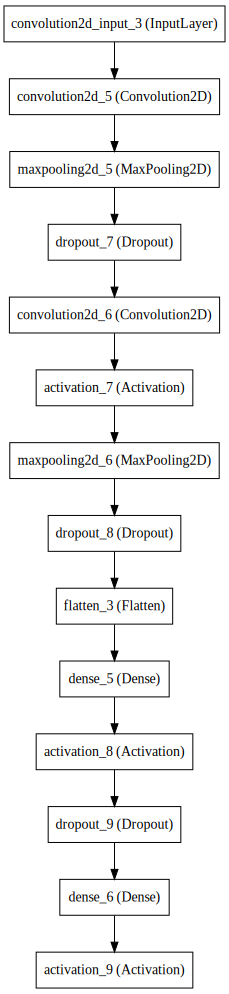

In [31]:
# Compile the model so we can get a view of what it looks like
# Note we'll do this in each training iteration later, but this'll keep the output tidy!
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

model, LossHistory = compile_model()
model.summary()
SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Training 
Train and use validation data to see if we're training effectively!


**********************************

Starting training iteration 1 with learning rate 0.003

Train on 20975 samples, validate on 1449 samples
Epoch 1/20
20975/20975 [==============================] - 401s - loss: 7.1907 - acc: 0.1158 - val_loss: 2.2917 - val_acc: 0.1511
Epoch 2/20
20975/20975 [==============================] - 398s - loss: 4.4993 - acc: 0.1481 - val_loss: 2.2834 - val_acc: 0.1801
Epoch 3/20
20975/20975 [==============================] - 399s - loss: 3.2737 - acc: 0.1698 - val_loss: 2.2718 - val_acc: 0.2153
Epoch 4/20
20975/20975 [==============================] - 394s - loss: 2.7061 - acc: 0.2033 - val_loss: 2.2569 - val_acc: 0.2581
Epoch 5/20
20975/20975 [==============================] - 399s - loss: 2.4332 - acc: 0.2274 - val_loss: 2.2330 - val_acc: 0.3223
Epoch 6/20
20975/20975 [==============================] - 392s - loss: 2.2839 - acc: 0.2523 - val_loss: 2.1989 - val_acc: 0.2802
Epoch 7/20
20975/20975 [==============================] - 400s - loss: 2.1640 - acc:

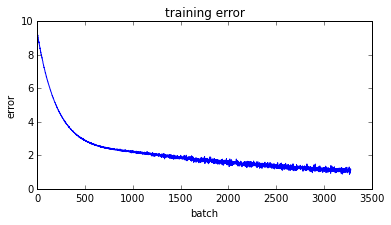

In [32]:
batch_size = 128
num_epochs = 20 #10
learning_rate = [0.003] # [0.001, 0.003, 0.01, 0.03, 0.1]

for i in range(len(learning_rate)):
    learningrate = learning_rate[i]
    print "\n**********************************"
    print "\nStarting training iteration {} with learning rate {}\n".format(i+1, learningrate)
    model, LossHistory = compile_model(learningrate, w_regularizer, b_regularizer)
    history = LossHistory()
    #model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=num_epochs,
    #          verbose=1, validation_data=(X_valid, y_valid), shuffle=True,
    #          callbacks=[history]) 
    hist = model.fit(X_train, y_train,            
              batch_size=batch_size, 
              nb_epoch=num_epochs,
              verbose=1,
              #validation_split = 0.10, 
              shuffle=True,
              validation_data=(X_valid, y_valid), 
              callbacks=[history])
    # validation_data=(X_train[validation_list], y_train[validation_list]),
    graph_training_loss_history(history.losses)
    model.save_weights('./model/saved_weights_lr_' + str(learningrate)+'.h5')
    #print('Score log_loss: ', get_log_loss_score(model, X_valid, y_valid))

In [33]:
model.save_weights('./model/saved_weights_' + keras_model + '_' + str(batch_size) + '_' + str(num_epochs) + '.h5')

In [41]:
hist.history.keys()


['acc', 'loss', 'val_acc', 'val_loss']

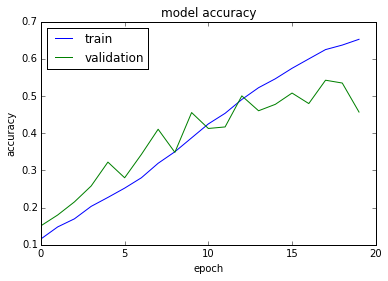

In [35]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

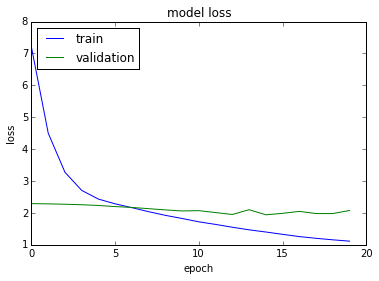

In [36]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

###Load the best weights from above
In this test, a learning rate of 0.003 worked best, so load this weights file now ready for testing

In [90]:
model.load_weights('model/saved_weights_lr_0.003.h5')

## Predict based on the test data

In [43]:
predictions = model.predict(test_data, batch_size = 128, verbose = 1)

79726/79726 [==============================] - 643s   


In [44]:
print predictions.shape

(79726, 10)


In [45]:
print predictions[0]

[  6.24912384e-04   1.72316752e-04   1.39586888e-02   1.74821631e-04
   2.34024905e-04   9.75843906e-01   4.18665214e-03   2.89488910e-03
   1.23334862e-03   6.76434778e-04]


In [46]:
import datetime
def create_submission(predictions, test_ids, test_info):
    result = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result.loc[:, 'img'] = pd.Series(test_ids, index=result.index)
    now = datetime.datetime.now()
    if not os.path.isdir('submission'):
        os.mkdir('submission')
    suffix = test_info + '_' + str(now.strftime("%Y-%m-%d-%H-%M"))
    sub_file = os.path.join('submission', 'submission_' + suffix + '.csv')
    result.to_csv(sub_file, index=False)

#+ str(score) \
test_info = 'loss_' \
                + '_h_' + str(image_height) \
                + '_w_' + str(image_width) \
                + '_ep_' + str(num_epochs)
create_submission(predictions, test_ids, test_info)

##Use Validation Data to Understand Accuracy of the Model

In [50]:
vpredictions = model.predict(X_valid, batch_size = 128, verbose = 1)

1449/1449 [==============================] - 11s    


In [51]:
print vpredictions


[[  6.34547055e-01   1.19403540e-03   6.94825721e-05 ...,   1.67880553e-05
    2.75434810e-03   2.97627091e-01]
 [  6.44880891e-01   2.97865132e-03   1.76933841e-04 ...,   4.80634335e-05
    4.85972641e-03   2.77138889e-01]
 [  6.72597170e-01   7.39449495e-03   5.47737465e-04 ...,   6.45421023e-05
    7.59685086e-03   2.28580207e-01]
 ..., 
 [  2.86424279e-01   4.95072268e-02   1.00864366e-01 ...,   5.73345087e-03
    7.60333985e-02   1.35453016e-01]
 [  2.46058658e-01   6.12950511e-02   1.21379420e-01 ...,   9.75283794e-03
    7.48897791e-02   1.62880376e-01]
 [  2.97412217e-01   6.38453737e-02   9.54688489e-02 ...,   7.19732745e-03
    6.64712489e-02   1.58114105e-01]]


In [52]:
print y_valid

[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]]


In [121]:
from skimage.transform import rotate

def probability_to_binary(predictions):
    results = []
    for pred in predictions:
        idx = np.argmax(pred)
        result = np.zeros(len(pred))
        result[idx] = 1
        results.append(result)
    return results  

In [162]:
y_predictions = probability_to_binary(vpredictions)

success = []
failed = []
c = 0

for yclass, ypredict in zip(y_valid, y_predictions):
    yc = np.argmax(yclass)
    yp = np.argmax(ypredict)
    if yc == yp:
        #print "Success: Class {}, {} predicted".format(np.argmax(yclass), np.argmax(ypredict))
        success.append([c, yp])
    else:
        #print "Failed!: Class {}, {} predicted".format(np.argmax(yclass), np.argmax(ypredict))
        failed.append([c, yp])
    c += 1
    
print "Successfully validated {} / {} = {}%".format(len(success), c, (float(len(success))/float(c))*100)
#print "Success: {}".format(success)
#print "Failed: {}".format(failed)
            

Successfully validated 662 / 1449 = 45.6866804693%


In [177]:
labels = [  'c0: safe driving',
            'texting - right',
            'c2: talking on the phone - right',
            'c3: texting - left',
            'c4: talking on the phone - left',
            'c5: operating the radio',
            'c6: drinking',
            'c7: reaching behind',
            'c8: hair and makeup',
            'c9: talking to passenger']

def show_image(image):
    img = image.squeeze()
    plt.axis("off")
    #plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.imshow(np.fliplr(rotate(img, 270)), cmap='gray', interpolation='nearest')  # Manipulation to display image in the correct orientation!
    plt.show() 
    #print image.shape
    #plt.imshow(image)

Sample of images validated correctly:
***************
Rendering image 641


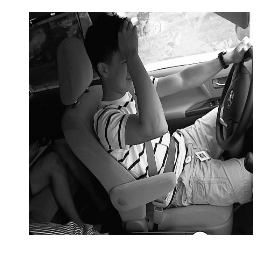

Classified correctly as c8: hair and makeup

***************
Rendering image 373


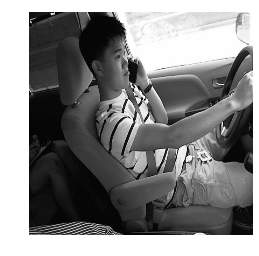

Classified correctly as c4: talking on the phone - left

***************
Rendering image 344


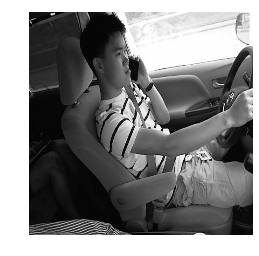

Classified correctly as c4: talking on the phone - left

***************
Rendering image 255


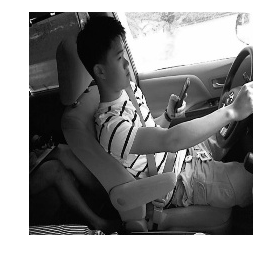

Classified correctly as c3: texting - left

***************
Rendering image 659


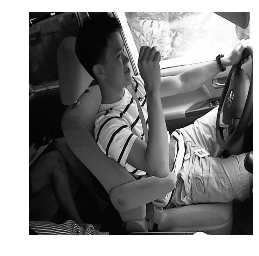

Classified correctly as c8: hair and makeup



In [179]:
#print success

print "Sample of images validated correctly:"
for s in np.random.choice(len(success), 5, replace = False):
    print "***************\nRendering image {}".format(s)
    image = X_valid[s]
    show_image(image)
    print "Classified correctly as {}\n".format(labels[np.argmax(y_valid[s])])
    
    
    
#print
#print np.random.choice(len(failed), 5, replace = False)

Sample of images validated incorrectly:
***************
Rendering image 4


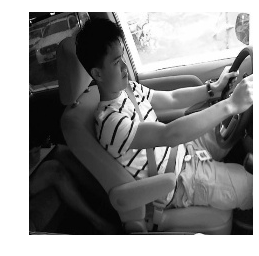

Class = c0: safe driving / predicted as c0: safe driving
***************
Rendering image 751


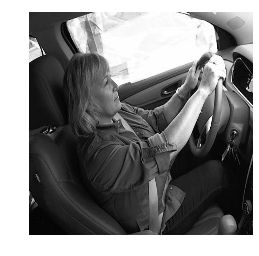

Class = c0: safe driving / predicted as c0: safe driving
***************
Rendering image 38


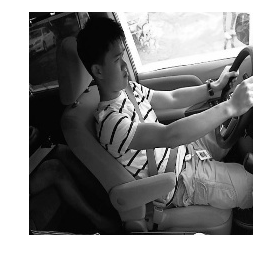

Class = c0: safe driving / predicted as c3: texting - left
***************
Rendering image 465


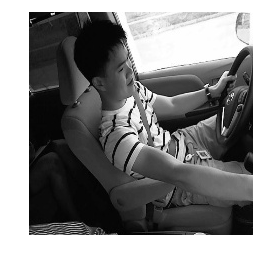

Class = c5: operating the radio / predicted as c0: safe driving
***************
Rendering image 188


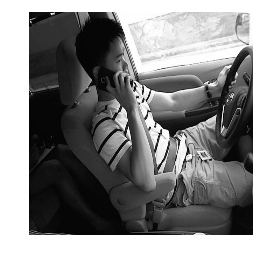

Class = c2: talking on the phone - right / predicted as c0: safe driving


In [181]:
print "Sample of images validated incorrectly:"
for f in np.random.choice(len(failed), 5, replace = False):
    print "***************\nRendering image {}".format(f)
    image = X_valid[f]
    show_image(image)
    print "Class = {} / predicted as {}".format(labels[np.argmax(y_valid[f])], labels[failed[f][1]])
    

## Additional NN metrics, etc

Display the weights, biases, etc. for the network

In [26]:
for layer in model.layers:
    print layer.get_config()
    print layer.get_weights()

{'W_constraint': None, 'b_constraint': None, 'name': 'convolution2d_3', 'activity_regularizer': None, 'trainable': True, 'dim_ordering': 'th', 'nb_col': 3, 'subsample': (1, 1), 'init': 'glorot_uniform', 'bias': True, 'nb_filter': 8, 'activation': 'relu', 'input_dtype': 'float32', 'batch_input_shape': (None, 1, 224, 224), 'W_regularizer': {'l2': 0.10000000149011612, 'name': 'WeightRegularizer', 'l1': 0.0}, 'nb_row': 3, 'b_regularizer': {'l2': 0.10000000149011612, 'name': 'WeightRegularizer', 'l1': 0.0}, 'border_mode': 'valid'}
[array([[[[ 0.15798764, -0.26940349,  0.24715555],
         [ 0.13878237, -0.12262621, -0.23275992],
         [ 0.16588999,  0.11729886, -0.19583708]]],


       [[[-0.73994195, -0.52082288, -0.4964388 ],
         [-0.60405433, -0.07172391,  0.60624444],
         [ 0.45547041,  0.93813646,  0.81139374]]],


       [[[-1.68558943, -1.23065007, -0.18032779],
         [-0.14056876,  0.58800739,  0.65498114],
         [ 0.34169093,  0.83168703,  0.9269051 ]]],


     

## Unused / broken code

###Visualise what the CNN has learnt
Inspired by https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py and https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

In [95]:
# the name of the layer we want to visualize
# (see model definition at keras/applications/vgg16.py)
layer_name = 'convolution2d_39 '
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
layer_output = layer_dict[layer_name].output

# Number of filters
n = 8

# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 64 filters.
kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters = kept_filters[:n * n]

# build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                         (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img

# save the result to disk
imsave('stitched_filters_%dx%d.png' % (n, n), stitched_filters)

KeyError: 'convolution2d_39 '